In [28]:
#Imports and Libraries Used
import requests
import json

#this API is from 
#https://www.themoviedb.org/settings/api

#airport data is found at
#https://openflights.org/data.html

import os, sys
currentdir = os.path.dirname(os.path.realpath("config.py"))
parentdir = os.path.dirname(currentdir)
sys.path.append(parentdir)

import config
import tmdbsimple as tmdb
import pandas as pd

from datetime import datetime

tmdb.API_KEY = config.api_key

In [102]:
####################################################################
## These methods created to pull and cleanse json data from 
## https://www.themoviedb.org/documentation/api

## movie_json_data() returns json dictionary from API

## collect_movie_info() returns dataframe with 
# 'id', 
# 'title', 
# 'release_date', 
# 'original_language', 
# 'original_title',
# 'genre_ids', 
# 'overview'

####################################################################

def movie_json_data(movie_keyword):
    
    #separate words in movie title by spaces
    movie_keyword=movie_keyword.split()
    
    #spaces in api need to be replaced by %20 in url for proper request
    separator='%20'
    
    movie_keyword=separator.join(movie_keyword)
    # looks like query=Godzilla%20vs%20SpaceGodzilla
    response = requests.get("https://api.themoviedb.org/3/search/movie?api_key=" 
                            + config.api_key 
                            + "&language=en-US&query="
                            + str(movie_keyword)
#                             + "&include_adult=false"
                           )

    #make sure request is successful
    if response.status_code == 200:
        
        jsonResponse = response.json()        #collect json response
    #     print(response.json().keys())
        json_data = json.loads(response.text) #cast to dictionary 
    #     print(type(json_data))
    #     print(json_data)
        return json_data                      #return dictionary
    else:
        empty = {}
        return empty


def collect_movie_info(json_data):          #pass in dictionary
    
    results_list = []
    for key, value in json_data.items():    #iterate through json tags
        if key == 'results':                #collect results which are
            results_list.append(value)      #the nested attributes we need

    deef = pd.DataFrame(results_list)
    # print(deef.head())
    # print(type(deef[2]))
    # print("type of deef")

    final = pd.DataFrame()

    for result in deef:
    #     print(deef[result][0])
    #     print(type(deef[result][0]))
        data = pd.DataFrame.from_dict(deef[result][0])
    #     data = pd.Series(deef[result][0])
    #     print(type(data))
    #     print(data.columns)
    #     data.to_frame()
    #     print(type(data))
    #     print("after")
    #     final.append(data,ignore_index=True)
    
    #iterating through 'results' to put all relevant columns into a df
        if 'popularity' and 'release_date' in data.columns:
            final = pd.concat([final,data], ignore_index=True)
            #drop unnecessary columns
            to_drop = ['popularity','video','vote_count','vote_average','backdrop_path',
                      'adult','poster_path']
            final.drop(to_drop,inplace=True,axis=1)
            final = final.drop_duplicates('id')
            final['release_date']= pd.to_datetime(final['release_date'], infer_datetime_format=True)
            return final
        else:
            empty_df = pd.DataFrame()
            return empty_df


In [56]:
#####################################################################
## This is an attempt to use the API's search feature
## However, this only returns about 76 movies when using 
## these key terms
#####################################################################

topics = ['ufo','alien','extraterrestrial', 'outer space']

tmdb_df = pd.DataFrame()

for topic in topics:
    
    json_data = movie_json_data(topic)
    
    movies_df = collect_movie_info(json_data)
    
    tmdb_df= pd.concat([movies_df,tmdb_df], ignore_index=True)


In [57]:
print(tmdb_df.info())
print(tmdb_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 76 non-null     int64         
 1   title              76 non-null     object        
 2   release_date       75 non-null     datetime64[ns]
 3   original_language  76 non-null     object        
 4   original_title     76 non-null     object        
 5   genre_ids          76 non-null     float64       
 6   overview           76 non-null     object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 4.3+ KB
None
       id                             title release_date original_language  \
0   16296    Killer Klowns from Outer Space   1988-05-27                en   
1   53985  Mutant Pumpkins from Outer Space   2009-04-01                en   
2   19483          It Came from Outer Space   1953-06-05                en   
3   1

In [41]:
####################################################################
## to beef up the short data set, an attempt to combine the search 
## results with additional data from wikipedia was made

#####################################################################
## Now to combine data sets
## This list is taken from
## ## This list is taken from https://en.wikipedia.org/wiki/List_of_films_featuring_extraterrestrials

# read in Alien Movie data
alien = pd.read_csv("alien_movies.csv")

# shape and data types of the data
print("What are the dimensions of the dataset?\n",alien.shape)
print("What are the datatypes for each variable?\n",alien.dtypes)
# compute descriptive statistics 
print("Descriptive Statistics\n",alien.describe())
# % of missing.


What are the dimensions of the dataset?
 (580, 4)
What are the datatypes for each variable?
 Title          object
Year            int64
Unnamed: 2    float64
Unnamed: 3    float64
dtype: object
Descriptive Statistics
               Year  Unnamed: 2  Unnamed: 3
count   580.000000         0.0         0.0
mean   1991.512069         NaN         NaN
std      21.687166         NaN         NaN
min    1902.000000         NaN         NaN
25%    1979.000000         NaN         NaN
50%    1996.000000         NaN         NaN
75%    2009.000000         NaN         NaN
max    2021.000000         NaN         NaN


In [42]:
#drop empty columns
alien.drop(alien.columns[[2,3]], axis = 1,inplace = True)
print(alien.shape)

#Sort by year
alien = alien.sort_values(by=["Year"])
# print(alien.Year)

#not working for some reason
#changing Title column to type String
alien.Title = alien.Title.astype(str)
alien = alien.rename(columns={"Title": "title"})

print(alien.dtypes)
#needs more testing. date format is wonky. returning 1970-01-01 00:00:00.000001902
#change year to datetime type
alien['Year']= pd.to_datetime(alien['Year'], infer_datetime_format=True)
print(alien.dtypes)
print(alien["Year"])

(580, 2)


In [112]:
#####################################################################
## The combined dataset was meh, so it was scrapped
#####################################################################
test = pd.concat([tmdb_df, alien], join="inner")
# test.info()
test.head()
# alien.head()

,title
0,Guardians of the Galaxy Vol. 2
524,A Trip to the Moon
175,Excursion to the Moon
330,A Message from Mars
523,A Trip to Mars (Himmelskibet)


In [83]:
#########################################################################
## since combining the API search results and the wikipedia list was trash,
## the third idea is to just use the search feature to search the movie
## titles from the wikipedia list to get a more specific release date
## of each movie
#########################################################################

import re

# To make sure the search is clear, all punctuation is removed from the 
# wikipedia movie list

clean_title = []
for x in alien['title']:
    alien['title'][x] = re.sub(r'[^\w\s]', '', x) 
    clean_title.append(alien['title'][x])# = alien['title'][x]
#     print(alien['title'][x])


print(clean_title)

['A Trip to the Moon', 'Excursion to the Moon', 'A Message from Mars', 'A Trip to Mars\xa0Himmelskibet', 'Algol Tragedy of Power', 'Aelita', 'Just Imagine', 'Flash Gordon\xa0serial', 'Flash Gordons Trip to Mars', 'Buck Rogers\xa0serial', 'Flash Gordon Conquers the Universe', 'Münchhausen', 'Superman\xa0serial', 'Flying Disc Man from Mars', 'Atom Man vs Superman', 'Flight to Mars', 'Rocketship XM', 'The Man from Planet X', 'The Day the Earth Stood Still', 'The Thing from Another World', 'Superman and the Mole Men', 'Zombies of the Stratosphere', 'Phantom from Space', 'Invaders from Mars', 'Robot Monster', 'It Came from Outer Space', 'Abbott and Costello Go to Mars', 'The War of the Worlds', 'CatWomen of the Moon', 'Target Earth', 'Killers from Space', 'Devil Girl from Mars', 'This Island Earth', 'Fire Maidens from Outer Space', 'It Conquered the World', 'Earth vs the Flying Saucers', 'Warning from Space', 'Invasion of the Body Snatchers', 'Forbidden Planet', 'The Brain from Planet Arous

In [103]:
##########################################################################

# Creation of final movie dataframe

#########################################################################


#iterate through list items from the cleaned movie list

test_df = pd.DataFrame()

for title in clean_title:
    
    json_data = movie_json_data(title)                  # get movie json
    print(json_data.items())
    movies_df = collect_movie_info(json_data)       # get cleaned movie df
    
    # add movie details to final dataframe of all movie details 
    test_df= pd.concat([movies_df,test_df], ignore_index=True)
    


dict_items([('page', 1), ('total_results', 7), ('total_pages', 1), ('results', [{'popularity': 12.746, 'vote_count': 1012, 'video': False, 'poster_path': '/7kIUCluYEFm2puW4lblsjS1f9kL.jpg', 'id': 775, 'adult': False, 'backdrop_path': '/jeC1kzwWnZTuXl7xF4E5D70BD8c.jpg', 'original_language': 'fr', 'original_title': 'Le Voyage dans la Lune', 'genre_ids': [12, 14, 878], 'title': 'A Trip to the Moon', 'vote_average': 8, 'overview': 'Professor Barbenfouillis and five of his colleagues from the Academy of Astronomy travel to the Moon aboard a rocket propelled by a giant cannon. Once on the lunar surface, the bold explorers face the many perils hidden in the caves of the mysterious satellite.', 'release_date': '1902-04-17'}, {'popularity': 1.967, 'vote_count': 5, 'video': False, 'poster_path': '/gAEWAFoljaxBlJlGhrHv7l6l8lP.jpg', 'id': 481264, 'adult': False, 'backdrop_path': '/ws0j8BpPvV1Go4ngBukdABHCn2A.jpg', 'original_language': 'es', 'original_title': 'Un viaje a la luna', 'genre_ids': [18]

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 1.684, 'id': 129089, 'video': False, 'vote_count': 3, 'vote_average': 6.2, 'title': "Flash Gordon's Trip to Mars", 'release_date': '1938-03-21', 'original_language': 'en', 'original_title': "Flash Gordon's Trip to Mars", 'genre_ids': [12, 878, 28], 'backdrop_path': None, 'adult': False, 'overview': 'A 15-episode serial starring Buster Crabbe.', 'poster_path': '/fdl9pTthUpLxueh3lK7gh9AtJ5L.jpg'}])])
dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 3.942, 'vote_count': 11, 'video': False, 'poster_path': '/eIHNQo0F1CEqMn6UN2E5KGlymMl.jpg', 'id': 68064, 'adult': False, 'backdrop_path': '/8jhMguVVMHMkv0Q6BLP1N0iu2FW.jpg', 'original_language': 'en', 'original_title': 'Flash Gordon Conquers the Universe', 'genre_ids': [28, 878], 'title': 'Flash Gordon Conquers the Univer

dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 0.925, 'vote_count': 1, 'video': False, 'poster_path': '/yqH1c20RdlGm9UbbKs6LW9WFahl.jpg', 'id': 253627, 'adult': False, 'backdrop_path': '/l1HZggHisVCeVeF9v2wqsKs75PE.jpg', 'original_language': 'en', 'original_title': 'Flying Disc Man from Mars', 'genre_ids': [28, 878], 'title': 'Flying Disc Man from Mars', 'vote_average': 5, 'overview': 'Mota is a Martian representative, who has come to impose interplanetary law on the Earth (which has become too dangerous); opposing his authority is Kent Fowler, who resists the alien plot, without understanding its details.', 'release_date': '1950-10-25'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 2.3, 'id': 106358, 'video': False, 'vote_count': 6, 'vote_average': 4.1, 'title': 'Atom Man vs Superman', 'release_date': 

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 9.828, 'id': 20424, 'video': False, 'vote_count': 98, 'vote_average': 6, 'title': 'Invaders from Mars', 'release_date': '1953-04-22', 'original_language': 'en', 'original_title': 'Invaders from Mars', 'genre_ids': [878, 53, 27], 'backdrop_path': '/f26rSgpMWGNOtW4pdIpUDQSnbj3.jpg', 'adult': False, 'overview': 'In the early hours of the night, young David Maclean sees a flying saucer land and disappear into the sand dunes just beyond his house. Slowly, all of the adults, including his once loving parents, begin to act strangely.', 'poster_path': '/pVR2c0bigL5w1K29H99svqHj2YH.jpg'}, {'popularity': 8.448, 'vote_count': 118, 'video': False, 'poster_path': '/4DfPiPEh35q3FAv1FvpzYls4iK2.jpg', 'id': 31909, 'adult': False, 'backdrop_path': '/i9IGAOKHgoVbPZnz0K2VFTPTTSN.jpg', 'original_language': 'en', 'original_title': 'Invaders from Mars', 'genre_ids': [12, 27, 9648, 878, 10751], 'title': 'Invaders f

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 2.599, 'vote_count': 24, 'video': False, 'poster_path': '/mNtL82TJgMDu3VXYD48jNLyDyT8.jpg', 'id': 43341, 'adult': False, 'backdrop_path': '/dgOEH9LyL9Dw0Ama8N7lPvxLvYh.jpg', 'original_language': 'en', 'original_title': 'Cat-Women of the Moon', 'genre_ids': [878], 'title': 'Cat-Women of the Moon', 'vote_average': 4, 'overview': 'Astronauts travel to the moon where they discover it is inhabited by attractive young women in black tights.', 'release_date': '1953-09-03'}])])
dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 24.846, 'vote_count': 25, 'video': False, 'poster_path': '/cqMH1aIvOUjeF9S0fog0zdntHtH.jpg', 'id': 443297, 'adult': False, 'backdrop_path': '/miNsHqbe8BJP7bLDjggMhAv0bM8.jpg', 'original_language': 'en', 'original_title': 'Moontrap: Target Earth', 'genre_ids': [28, 12, 878], 'title': 'Moontrap: Target Earth', 'vote_average': 4.1, 'ove

dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 4.221, 'vote_count': 26, 'video': False, 'poster_path': '/2V56EhYR3VsiXnnEMdWWPMsWO68.jpg', 'id': 27625, 'adult': False, 'backdrop_path': '/uyvuz1wjHiv1xchdJBB1Ujh6202.jpg', 'original_language': 'en', 'original_title': 'It Conquered the World', 'genre_ids': [27, 878, 53], 'title': 'It Conquered the World', 'vote_average': 4.5, 'overview': 'An alien from Venus tries to take over the world with the help of a disillusioned human scientist.', 'release_date': '1956-07-14'}, {'popularity': 3.065, 'id': 545478, 'video': False, 'vote_count': 1, 'vote_average': 10, 'title': 'How Big Oil Conquered the World', 'release_date': '2015-12-27', 'original_language': 'en', 'original_title': 'How Big Oil Conquered the World', 'genre_ids': [99], 'backdrop_path': '/gki3pLJGTKFKcOaZJUNvz2W0T4c.jpg', 'adult': False, 'overview': 'From farm to pharmaceutical, diesel truck to dinner plate, pipeline to plastic product,

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 14.805, 'id': 830, 'video': False, 'vote_count': 537, 'vote_average': 7.3, 'title': 'Forbidden Planet', 'release_date': '1956-03-23', 'original_language': 'en', 'original_title': 'Forbidden Planet', 'genre_ids': [878], 'backdrop_path': '/sYa6Dt5FyT6qZCMkUWs8RDylBHF.jpg', 'adult': False, 'overview': 'Starship C57D travels to planet Altair 4 in search of the crew of spaceship "Bellerophon", a scientific expedition that has been missing for 20 years, only to find themselves unwelcome by the expedition\'s lone survivor and warned of destruction by an invisible force if they don\'t turn back immediately.', 'poster_path': '/aq0OQfRS7hDDI8vyD0ICbH9eguC.jpg'}, {'popularity': 0.634, 'vote_count': 0, 'video': False, 'poster_path': '/6PLja2Ho9HQB1GP8ISVbbHcGZhM.jpg', 'id': 461156, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Amazing! Exploring the Far Reaches of F

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 0.6, 'vote_count': 0, 'video': False, 'poster_path': None, 'id': 649438, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'The Mysterians', 'genre_ids': [], 'title': 'The Mysterians', 'vote_average': 0, 'overview': 'Animation and bizarre creative imagery', 'release_date': '1973-03-03'}, {'popularity': 5.73, 'id': 43226, 'video': False, 'vote_count': 20, 'vote_average': 7, 'title': 'The Mysterians', 'release_date': '1957-12-28', 'original_language': 'ja', 'original_title': '地球防衛軍', 'genre_ids': [878], 'backdrop_path': '/iXBDDAAqu8k23lLS1BPS8fenO0k.jpg', 'adult': False, 'overview': 'In Japan, scientifically advanced invaders from the war-destroyed planet Mysteroid cause an entire village to vanish, then send a giant robot out to storm the city by night, after which they request a small patch of land on Earth and the right to marry earthling women, claiming to 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.256, 'id': 43120, 'video': False, 'vote_count': 8, 'vote_average': 3.8, 'title': 'Missile to the Moon', 'release_date': '1958-11-15', 'original_language': 'en', 'original_title': 'Missile to the Moon', 'genre_ids': [878], 'backdrop_path': '/qmuoXb3BkhvKubefb3N4j3FpITJ.jpg', 'adult': False, 'overview': "Escaped convicts Gary and Lon are caught hiding in a rocket by scientist Dirk Green, who forces them to pilot the ship to the moon. Dirk, who's secretly a moon being, wants to return to his home satellite. Dirk's partner Steve Dayton and his fiancé June stowaway on the ship by accident. Will they all make it back safely?  A remake of CAT WOMEN OF THE MOON.", 'poster_path': '/voOLnn1a1XFyfAAiOwbyuW0Ac8C.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.305, 'id': 27179, 'video': False, 'vote_count': 57, 'vote_average': 5.8, 'title': 'It!

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 2.811, 'vote_count': 20, 'video': False, 'poster_path': '/izcrOBaOIThJoUfBVSauiRBuvCp.jpg', 'id': 62472, 'adult': False, 'backdrop_path': '/5lPGMV2NIVZZfKT0ZktEOMTmqox.jpg', 'original_language': 'ja', 'original_title': '宇宙大戦争', 'genre_ids': [878], 'title': 'Battle in Outer Space', 'vote_average': 5.9, 'overview': 'In 1965, the space station JSS-3 is attacked by a fleet of UFOs. After the station is destroyed, the saucers make their way to Earth. They then begin a global siege on the planet, using absolute zero rays to manipulate gravity. In response, a global council meeting is held to determine the source of the attacks. There, a representative becomes suddenly stricken with head pain. It is later revealed that he has become mind controlled by the invaders. Revealing themselves to be the Natarl, the aliens declare war on humanity. In response, Earth prepares the SPIP rocket ships. Their plan

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.165, 'vote_count': 13, 'video': False, 'poster_path': '/yqF6j9heCTUnvqgM0tc7ao03i6X.jpg', 'id': 38946, 'adult': False, 'backdrop_path': '/c3knJX6oIeO1tn1xlBt3IEQQj80.jpg', 'original_language': 'en', 'original_title': 'Terror in the Midnight Sun', 'genre_ids': [878], 'title': 'Terror in the Midnight Sun', 'vote_average': 3.5, 'overview': 'After a herd of reindeer are mysteriously found dead following a meteor crash in a remote part of Lapland in northern Sweden, soldiers and a geologist are called out to investigate.', 'release_date': '1959-08-19'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 2.322, 'vote_count': 7, 'video': False, 'poster_path': '/pcO7GNXtK9CIw4ZLjniil3M018b.jpg', 'id': 97895, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'The Cape Canaveral Monsters', 'genre_ids': [878, 10770], 'tit

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.111, 'id': 17938, 'video': False, 'vote_count': 37, 'vote_average': 4.4, 'title': 'First Spaceship on Venus', 'release_date': '1960-02-26', 'original_language': 'de', 'original_title': 'Der schweigende Stern', 'genre_ids': [878], 'backdrop_path': '/nvSl7sgxZJ5vTcoIqIVy630yJwV.jpg', 'adult': False, 'overview': 'A mysterious magnetic spool found during a construction project is discovered to have originated from Venus. A rocket expedition to Venus is launched to discover the origin of the spool and the race that created it.', 'poster_path': '/akxbIcgOvh7PLufvkvq2PLjXewv.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.761, 'id': 29570, 'video': False, 'vote_count': 27, 'vote_average': 4.6, 'title': 'Journey to the Seventh Planet', 'release_date': '1962-03-10', 'original_language': 'en', 'original_title': 'Journey to the Seventh Planet'

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 8.37, 'vote_count': 140, 'video': False, 'poster_path': '/6GxD5h3PX0lLX9ucH2M8Uc5guM6.jpg', 'id': 15766, 'adult': False, 'backdrop_path': '/mLWEzNqJlfGt7X63rj0AJnjgKC7.jpg', 'original_language': 'ja', 'original_title': '三大怪獣\u3000地球最大の決戦', 'genre_ids': [28, 14, 878], 'title': 'Ghidorah, the Three-Headed Monster', 'vote_average': 7.3, 'overview': 'The Princess Mas Selina Salno is seemingly assassinated as a mysterious meteorite lands in Kurobe Valley. When a scientific expedition examines the meteorite, they discover the rock is growing, producing heat and has a strong magnetic pull. Soon a prophetess, with a striking resemblance to the princess, warns of great calamity in the return of Godzilla, Rodan, and the arrival of King Ghidorah.', 'release_date': '1964-12-20'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 4.681, 'vote_count': 50, 'vi

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 7.278, 'vote_count': 47, 'video': False, 'poster_path': '/yf0prpLbF8olIzTbYlQeT3TWZbg.jpg', 'id': 26581, 'adult': False, 'backdrop_path': '/sjqxkY3KFFzVg5oiW8QUxlpus2u.jpg', 'original_language': 'en', 'original_title': 'Dr. Who and the Daleks', 'genre_ids': [12, 878, 10751], 'title': 'Dr. Who and the Daleks', 'vote_average': 5.7, 'overview': "Scientist Doctor Who accidentally activates his new invention, the Tardis, a time machine disguised as a police telephone box. Doctor Who, his two grand-daughters, and Barbara's boyfriend Ian are transported through time and space to the planet Skaro, where a peaceful race of Thals are under threat of nuclear attack from the planet's other inhabitants: the robotic mutant Daleks.", 'release_date': '1965-08-23'}, {'popularity': 5.678, 'id': 16387, 'video': False, 'vote_count': 44, 'vote_average': 6.1, 'title': "Daleks' Invasion Earth: 2150 A.D.", 'release_

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.678, 'id': 16387, 'video': False, 'vote_count': 44, 'vote_average': 6.1, 'title': "Daleks' Invasion Earth: 2150 A.D.", 'release_date': '1966-08-05', 'original_language': 'en', 'original_title': "Daleks' Invasion Earth: 2150 A.D.", 'genre_ids': [10751, 878], 'backdrop_path': '/cvX3l6CAcUepdpVgUYNsAyrG6Tz.jpg', 'adult': False, 'overview': 'Doctor Who and his companions are hurled into the future and make a horrifying discovery: the Daleks have conquered Earth! The metal fiends have devastated entire continents and turned the survivors into Robomen.', 'poster_path': '/y5l0DjqEaqPLkP4A7yaj1a3FXI0.jpg'}])])
dict_items([('page', 1), ('total_results', 346), ('total_pages', 18), ('results', [{'popularity': 20.174, 'id': 4858, 'video': False, 'vote_count': 929, 'vote_average': 5.9, 'title': 'The Invasion', 'release_date': '2007-08-17', 'original_language': 'en', 'original_title': 'The Invasion', 'ge

dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 2.82, 'vote_count': 1, 'video': False, 'poster_path': None, 'id': 93120, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'What on Earth?', 'genre_ids': [99], 'title': 'What on Earth?', 'vote_average': 7, 'overview': 'No overview found.', 'release_date': '2009-01-01'}, {'popularity': 3.254, 'id': 80169, 'video': False, 'vote_count': 26, 'vote_average': 5.7, 'title': 'Thrive: What on Earth Will it Take?', 'release_date': '2011-11-11', 'original_language': 'en', 'original_title': 'Thrive: What on Earth Will it Take?', 'genre_ids': [99], 'backdrop_path': '/nZLnhGL3Zgus2LjvbBGiCNx6Py3.jpg', 'adult': False, 'overview': "An unconventional documentary that lifts the veil on what's really going on in our world by following the money upstream - uncovering the global consolidation of power in nearly every aspect of our lives. Weaving together breakthroughs in science,

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 9.105, 'vote_count': 121, 'video': False, 'poster_path': '/AvruSt4xRIbXO8gVxPzHupbf5A2.jpg', 'id': 26912, 'adult': False, 'backdrop_path': '/4thlb8BV5BFWtD1whfH5a21bmJ8.jpg', 'original_language': 'en', 'original_title': 'Quatermass and the Pit', 'genre_ids': [878], 'title': 'Quatermass and the Pit', 'vote_average': 6.8, 'overview': 'An ancient Martian spaceship is unearthed in London, and proves to have powerful psychic effects on the people around.', 'release_date': '1967-11-09'}])])
dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.498, 'id': 36530, 'video': False, 'vote_count': 22, 'vote_average': 2.7, 'title': 'Voyage to the Planet of Prehistoric Women', 'release_date': '1968-01-01', 'original_language': 'en', 'original_title': 'Voyage to the Planet of Prehis

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.614, 'vote_count': 51, 'video': False, 'poster_path': '/3MWnOwcLeySNqPtHpxqr7bJTZE5.jpg', 'id': 29290, 'adult': False, 'backdrop_path': '/eXsNAdsE8Ee2CySB9SiIIQ67rcx.jpg', 'original_language': 'en', 'original_title': 'The Green Slime', 'genre_ids': [18, 27, 878], 'title': 'The Green Slime', 'vote_average': 5, 'overview': 'A giant asteroid is heading toward Earth so some astronauts disembark from a nearby space station to blow it up. The mission is successful, and they return to the station unknowingly bringing back a gooey green substance that mutates into one-eyed tentacled monsters that feed off electricity. Soon the station is crawling with them, and people are being zapped left and right!', 'release_date': '1968-12-19'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 10.036, 'id': 3107, 'video': False, 'vote_count': 132, 'vote_average':

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 1.937, 'id': 113814, 'video': False, 'vote_count': 4, 'vote_average': 1.4, 'title': 'Invasion from Inner Earth', 'release_date': '1974-10-30', 'original_language': 'en', 'original_title': 'Invasion from Inner Earth', 'genre_ids': [18, 878], 'backdrop_path': None, 'adult': False, 'overview': 'A group of young pilots in a remote region of the Canadian wilderness begin to hear strange reports over their radios about planes crashing, cars stalling and a deadly plague which has gripped the planet. It becomes clear that earth is in the midst of an invasion. The group of pilots decide to barracade themselves in a cabin deep in the woods and wait for their impending doom.', 'poster_path': '/ylb04qD4v3sWQAYTb1s02d6FMU8.jpg'}])])
dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 9.449, 'vote_count': 114, 'video': False, 'poster_path': '/89uE2QQEWAiXgNBwMQX4P

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 6.605, 'vote_count': 36, 'video': False, 'poster_path': '/pdD0zSAiHpX2TEz4uuVdMB3KkGB.jpg', 'id': 39154, 'adult': False, 'backdrop_path': '/eW3uPACCQapCsMmYyrtvLUsLqFp.jpg', 'original_language': 'en', 'original_title': 'The Giant Spider Invasion', 'genre_ids': [27, 878], 'title': 'The Giant Spider Invasion', 'vote_average': 3.8, 'overview': 'A black hole hits North Wisconsin and opens a door to other dimensions. Giant 15 meter spiders emerge from it, who have an appetite for human flesh! Dr. Jenny Langer and Dr. Vance from the NASA try to save the world.', 'release_date': '1975-10-01'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 8.966, 'id': 19333, 'video': False, 'vote_count': 123, 'vote_average': 7.1, 'title': 'Terror of Mechagodzilla', 'release_date': '1975-03-15', 'original_language': 'ja', 'original_title': 'メカゴジラの逆襲', 'genre_ids': [

dict_items([('page', 1), ('total_results', 4), ('total_pages', 1), ('results', [{'popularity': 8.076, 'id': 991, 'video': False, 'vote_count': 306, 'vote_average': 6.5, 'title': 'The Man Who Fell to Earth', 'release_date': '1976-03-18', 'original_language': 'en', 'original_title': 'The Man Who Fell to Earth', 'genre_ids': [18, 878], 'backdrop_path': '/xvcOWLY6GHiD2LRrXbDwqqKjwQ4.jpg', 'adult': False, 'overview': 'Thomas Jerome Newton is an alien who has come to Earth in search of water to save his home planet. Aided by lawyer Oliver Farnsworth, Thomas uses his knowledge of advanced technology to create profitable inventions. While developing a method to transport water, Thomas meets Mary-Lou, a quiet hotel clerk, and begins to fall in love with her. Just as he is ready to leave Earth, Thomas is intercepted by the U.S. government, and his entire plan is threatened.', 'poster_path': '/gwmPVphE5DMFFGXGMhfEFyxOOYj.jpg'}, {'popularity': 3.686, 'id': 81516, 'video': False, 'vote_count': 3, '

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.865, 'vote_count': 38, 'video': False, 'poster_path': '/a5oiU1vqpWQfjLYLWcq6CDSnwmz.jpg', 'id': 30117, 'adult': False, 'backdrop_path': '/gTFfyrsVvlaYsS8Hh5j67ETe8hL.jpg', 'original_language': 'en', 'original_title': 'Warlords of Atlantis', 'genre_ids': [12, 14, 878], 'title': 'Warlords of Atlantis', 'vote_average': 5.9, 'overview': "Searching for the lost world of Atlantis, Prof. Aitken, his son Charles and Greg Collinson are betrayed by the crew of their expedition's ship, attracted by the fabulous treasures of Atlantis. The diving bell disabled, a deep sea monster attacks the boat. They are all dragged to the bottom of the sea where they meet the inhabitants of the lost continent, an advanced alien race that makes sailors their slaves.", 'release_date': '1978-05-01'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 1.545, 'vote_count': 22

dict_items([('page', 1), ('total_results', 148), ('total_pages', 8), ('results', [{'popularity': 130.867, 'vote_count': 197, 'video': False, 'poster_path': '/6Bbq8qQWpoApLZYWFFAuZ1r2gFw.jpg', 'id': 618354, 'adult': False, 'backdrop_path': '/bazlsLkNuhy3IuhviepqvlMm2hV.jpg', 'original_language': 'en', 'original_title': 'Superman: Man of Tomorrow', 'genre_ids': [28, 16, 878], 'title': 'Superman: Man of Tomorrow', 'vote_average': 7.4, 'overview': 'It’s the dawn of a new age of heroes, and Metropolis has just met its first. But as Daily Planet intern Clark Kent – working alongside reporter Lois Lane – secretly wields his alien powers of flight, super-strength and x-ray vision in the battle for good, there’s even greater trouble on the horizon.', 'release_date': '2020-08-23'}, {'popularity': 136.804, 'vote_count': 339, 'video': True, 'poster_path': '/9BqeqvGfMOfsbY5X4mljLTVKO1X.jpg', 'id': 630656, 'adult': False, 'backdrop_path': '/c3BQUy9AENkdd8us6OaB8GGBHc8.jpg', 'original_language': 'en'

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 1.744, 'vote_count': 12, 'video': False, 'poster_path': '/lDDl7pOfetW5MSUZOjVEomZr8Uo.jpg', 'id': 28482, 'adult': False, 'backdrop_path': None, 'original_language': 'es', 'original_title': 'Supersonic Man', 'genre_ids': [12, 35, 14], 'title': 'Supersonic Man', 'vote_average': 3.3, 'overview': "A masked superhero (Michael Coby) with a private-eye disguise thwarts a madman's (Cameron Mitchell) death-ray plot.", 'release_date': '1979-11-01'}])])
dict_items([('page', 1), ('total_results', 50), ('total_pages', 3), ('results', [{'popularity': 10.307, 'vote_count': 262, 'video': False, 'poster_path': '/9XRRSD7swlYrGBhZ8vOR2yngIKZ.jpg', 'id': 12473, 'adult': False, 'backdrop_path': '/k2qbXrACQIjwbaHal8cawfT5MPP.jpg', 'original_language': 'en', 'original_title': 'The Visitor', 'genre_ids': [80, 18, 10402], 'title': 'The Visitor', 'vote_average': 7.2, 'overview': 'A college professor travels to New Yor

dict_items([('page', 1), ('total_results', 649), ('total_pages', 33), ('results', [{'popularity': 39.952, 'id': 348, 'video': False, 'vote_count': 9683, 'vote_average': 8.1, 'title': 'Alien', 'release_date': '1979-05-25', 'original_language': 'en', 'original_title': 'Alien', 'genre_ids': [27, 878], 'backdrop_path': '/AmR3JG1VQVxU8TfAvljUhfSFUOx.jpg', 'adult': False, 'overview': 'During its return to the earth, commercial spaceship Nostromo intercepts a distress signal from a distant planet. When a three-member team of the crew discovers a chamber containing thousands of eggs on the planet, a creature inside one of the eggs attacks an explorer. The entire crew is unaware of the impending nightmare set to descend upon them when the alien parasite planted inside its unfortunate host is birthed.', 'poster_path': '/vfrQk5IPloGg1v9Rzbh2Eg3VGyM.jpg'}, {'popularity': 64.113, 'vote_count': 6051, 'video': False, 'poster_path': '/zecMELPbU5YMQpC81Z8ImaaXuf9.jpg', 'id': 126889, 'adult': False, 'ba

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 15.018, 'vote_count': 2843, 'video': False, 'poster_path': '/lSSA64WF0M0BXnjwr2quMh6shCl.jpg', 'id': 583, 'adult': False, 'backdrop_path': '/aRvoRaR4l7Bxzjch5ioi5dZzrsX.jpg', 'original_language': 'en', 'original_title': 'Life of Brian', 'genre_ids': [35], 'title': 'Life of Brian', 'vote_average': 7.8, 'overview': "Brian Cohen is an average young Jewish man, but through a series of ridiculous events, he gains a reputation as the Messiah. When he's not dodging his followers or being scolded by his shrill mother, the hapless Brian has to contend with the pompous Pontius Pilate and acronym-obsessed members of a separatist movement. Rife with Monty Python's signature absurdity, the tale finds Brian's life paralleling Biblical lore, albeit with many more laughs.", 'release_date': '1979-08-17'}])])
dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('pag

dict_items([('page', 1), ('total_results', 10), ('total_pages', 1), ('results', [{'popularity': 18.907, 'vote_count': 560, 'video': False, 'poster_path': '/lCNKMxy7P0QGm8l2KYWuXxMfeqD.jpg', 'id': 3604, 'adult': False, 'backdrop_path': '/5yHF5F2S85vtNzsF18EpJPFgpxF.jpg', 'original_language': 'en', 'original_title': 'Flash Gordon', 'genre_ids': [878], 'title': 'Flash Gordon', 'vote_average': 6.2, 'overview': 'A football player and his friends travel to the planet Mongo and find themselves fighting the tyrant, Ming the Merciless, to save Earth.', 'release_date': '1980-09-01'}, {'popularity': 2.892, 'vote_count': 20, 'video': False, 'poster_path': '/yxKTLVrHUz5MLRFXkNHDhoFrRPq.jpg', 'id': 3632, 'adult': False, 'backdrop_path': '/o8gFu8y8lRFbZhoAKnt0WszMIKQ.jpg', 'original_language': 'en', 'original_title': 'Flash Gordon', 'genre_ids': [28, 878], 'title': 'Flash Gordon', 'vote_average': 6.9, 'overview': 'Three earthlings visit the planet Mongo to thwart the evil schemes of Emperor Ming the 

dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 2.717, 'vote_count': 34, 'video': False, 'poster_path': '/3LLfieDmGmfQ0PTJfNIaLR2y69C.jpg', 'id': 42872, 'adult': False, 'backdrop_path': '/8pBcRyi6cZnUC48Gd4nksr3ZHOX.jpg', 'original_language': 'it', 'original_title': 'Alien 2 - Sulla terra', 'genre_ids': [27, 878], 'title': 'Alien 2: On Earth', 'vote_average': 2.8, 'overview': 'A group of cave explorers are confronted in an underground cavern by a mysterious living rock. Little do they know that it bears home to deadly, flesh-eating creatures, intent on wiping out the entire human population. An ultra low-budget, unofficial and unauthorized sequel to the 1979 film Alien, although the plot has little connection to the original film.', 'release_date': '1980-04-11'}, {'popularity': 0.6, 'vote_count': 1, 'video': False, 'poster_path': '/o14BZcvK64k1s1e3Ka4Zr8fUqVb.jpg', 'id': 441763, 'adult': False, 'backdrop_path': '/naXAK3Y6pGU3FxUo6akHFLj0K7

dict_items([('page', 1), ('total_results', 58), ('total_pages', 3), ('results', [{'popularity': 14.54, 'id': 11827, 'video': False, 'vote_count': 385, 'vote_average': 6.4, 'title': 'Heavy Metal', 'release_date': '1981-08-07', 'original_language': 'en', 'original_title': 'Heavy Metal', 'genre_ids': [16, 878, 12, 14, 10402], 'backdrop_path': '/9VK5BflMEg9ezT9nf4v8OEwq5zV.jpg', 'adult': False, 'overview': 'A glowing orb terrorizes a young girl with a collection of stories of dark fantasy, eroticism and horror.', 'poster_path': '/atUtWrDlLzT1yeVK2EoYtvbS963.jpg'}, {'popularity': 11.257, 'id': 16225, 'video': False, 'vote_count': 100, 'vote_average': 5.9, 'title': 'Heavy Metal 2000', 'release_date': '2000-04-19', 'original_language': 'en', 'original_title': 'Heavy Metal 2000', 'genre_ids': [28, 12, 16, 14, 878], 'backdrop_path': '/fClJrAmJQ90zg9gWnfHVYSMiDTv.jpg', 'adult': False, 'overview': "Upon discovery of a shard of what could be the Loc-Nar, a miner named Tyler becomes possessed with 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.001, 'id': 46364, 'video': False, 'vote_count': 47, 'vote_average': 3.9, 'title': 'Inseminoid', 'release_date': '1981-01-23', 'original_language': 'en', 'original_title': 'Inseminoid', 'genre_ids': [53, 27, 878], 'backdrop_path': '/tRQccqmAI1tPcC7ejKJzo3MfJ7T.jpg', 'adult': False, 'overview': 'A crew of interplanetary archaeologists is threatened when an alien creature impregnates one of their members, causing her to turn homicidal and murder them one by one.', 'poster_path': '/taeQeq3GBYzhCJmG9Zto14B9wd4.jpg'}])])
dict_items([('page', 1), ('total_results', 228), ('total_pages', 12), ('results', [{'popularity': 36.359, 'id': 1091, 'video': False, 'vote_count': 4179, 'vote_average': 8, 'title': 'The Thing', 'release_date': '1982-06-25', 'original_language': 'en', 'original_title': 'The Thing', 'genre_ids': [27, 9648, 878], 'backdrop_path': '/lS9oEknIMaNvIm2zpXg5MXDDmZx.jpg', 'adult': False, 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 15.189, 'vote_count': 643, 'video': False, 'poster_path': '/5nBnmNmmBCsdkB2uxPMcm1nfrnc.jpg', 'id': 2665, 'adult': False, 'backdrop_path': '/fRQU8Xz8YpWOppxbk016L0nX1Wr.jpg', 'original_language': 'en', 'original_title': 'Airplane II: The Sequel', 'genre_ids': [35], 'title': 'Airplane II: The Sequel', 'vote_average': 6.1, 'overview': 'A faulty computer causes a passenger space shuttle to head straight for the sun, and man-with-a-past, Ted Striker must save the day and get the shuttle back on track – again – all the while trying to patch up his relationship with Elaine.', 'release_date': '1982-12-10'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 8.554, 'vote_count': 66, 'video': False, 'poster_path': '/nRvRg0VFf5zW8aLnnzWQBs3v7LU.jpg', 'id': 42251, 'adult': False, 'backdrop_path': '/iaMCKsvCwB203ey43twIFiuS9UK.jpg', 'original_language': 'en'

dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('results', [{'popularity': 11.842, 'id': 11639, 'video': False, 'vote_count': 685, 'vote_average': 7.1, 'title': 'The Dark Crystal', 'release_date': '1982-12-17', 'original_language': 'en', 'original_title': 'The Dark Crystal', 'genre_ids': [14, 12, 10751, 16], 'backdrop_path': '/ayAJltbsnde8afEDtvK3fXVeAAn.jpg', 'adult': False, 'overview': 'On another planet in the distant past, a Gelfling embarks on a quest to find the missing shard of a magical crystal and restore order to his world, before the grotesque race of Skeksis find and use the crystal for evil.', 'poster_path': '/sMwbyGnMu1RzARnPkEKkeWXXSVN.jpg'}, {'popularity': 19.013, 'vote_count': 18, 'video': False, 'poster_path': '/d6liOscksEp37koLfdjzdu1BwrK.jpg', 'id': 627133, 'adult': False, 'backdrop_path': '/uGAAv3zIxH5zUNRqMMw9509BTOy.jpg', 'original_language': 'en', 'original_title': 'The Crystal Calls - Making The Dark Crystal: Age of Resistance', 'genre_ids':

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 3.842, 'vote_count': 20, 'video': False, 'poster_path': '/5UN3CRej4NBehFgNXWHMr1H38Sd.jpg', 'id': 52528, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Bloodbath at the House of Death', 'genre_ids': [35, 27], 'title': 'Bloodbath at the House of Death', 'vote_average': 5.6, 'overview': 'Six scientists arrive at the creepy Headstone Manor to investigate a strange phenomena which was the site of a mysterious massacre years earlier where 18 guests were killed in one night. It turns out that the house is the place of a satanic cult lead by a sinister monk who plans to kill the scientists who are inhabiting this house of Satan.', 'release_date': '1984-03-29'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.778, 'vote_count': 17, 'video': False, 'poster_path': '/cwrnrjnfA520ub1D3aJ5YzCY9HP.jpg', 'id': 36220, '

dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 8.962, 'id': 13820, 'video': False, 'vote_count': 332, 'vote_average': 6.7, 'title': 'Repo Man', 'release_date': '1984-02-20', 'original_language': 'en', 'original_title': 'Repo Man', 'genre_ids': [35, 878], 'backdrop_path': '/hzQ5k4NrwjafVCWSHG8r6wjEfSE.jpg', 'adult': False, 'overview': "A down and out young punk gets a job working with a seasoned repo man, but what awaits him in his new career is a series of outlandish adventures revolving around aliens, the CIA, and a most wanted '64 Chevy.", 'poster_path': '/1H9qUTymhZnihUQ4bfZ82IATauL.jpg'}, {'popularity': 0.804, 'id': 588790, 'video': False, 'vote_count': 0, 'vote_average': 0, 'title': 'Repo Man 2', 'release_date': '', 'original_language': 'en', 'original_title': 'Repo Man 2', 'genre_ids': [35], 'backdrop_path': None, 'adult': False, 'overview': 'A sequ

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.401, 'vote_count': 16, 'video': False, 'poster_path': '/pdKy8oLJm36O0DmEO5ZgVUH21FQ.jpg', 'id': 82407, 'adult': False, 'backdrop_path': '/m3jYdAfSrq5bAYhIUVajZG7qDtY.jpg', 'original_language': 'en', 'original_title': 'Bloodsuckers from Outer Space', 'genre_ids': [35, 27, 878], 'title': 'Bloodsuckers from Outer Space', 'vote_average': 4.5, 'overview': 'A mysterious and invisible alien presence has landed in rural Texas and has started turning the nearby townspeople into white-faced, bloodthirsty killers. As the local authorities begin to investigate the strange and violent goings on, a photographer and his girlfriend find themselves trapped in the midst of an unexpected rural bloodbath, which seeks to turn them into another pair of bloodsuckers from outer space...', 'release_date': '1984-01-03'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity'

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 15.568, 'id': 11884, 'video': False, 'vote_count': 421, 'vote_average': 6.5, 'title': 'The Last Starfighter', 'release_date': '1984-07-13', 'original_language': 'en', 'original_title': 'The Last Starfighter', 'genre_ids': [12, 878, 28], 'backdrop_path': '/2KjPXUYDoSbAtIQGjbEIcX6b7x5.jpg', 'adult': False, 'overview': 'A video game expert Alex Rogan finds himself transported to another planet after conquering The Last Starfighter video game only to find out it was just a test. He was recruited to join the team of best Starfighters to defend their world from the attack.', 'poster_path': '/an1H0DPADLDlEsiUy8vE9AWqrhm.jpg'}, {'popularity': 0.6, 'vote_count': 1, 'video': False, 'poster_path': '/oBB4npl8v18TjiF4nbCpCVI4WEG.jpg', 'id': 730574, 'adult': False, 'backdrop_path': '/iXVGdceBKHF9bOfxmRxrY59U9Bg.jpg', 'original_language': 'en', 'original_title': 'The Last Starfighter - Crossing the Frontier

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 14.938, 'id': 11864, 'video': False, 'vote_count': 553, 'vote_average': 6.9, 'title': 'Enemy Mine', 'release_date': '1985-12-12', 'original_language': 'en', 'original_title': 'Enemy Mine', 'genre_ids': [18, 878], 'backdrop_path': '/xStFRUQtjdQWiZEGN80rgkhN0Kh.jpg', 'adult': False, 'overview': 'A soldier from Earth crashlands on an alien world after sustaining battle damage. Eventually he encounters another survivor, but from the enemy species he was fighting; they band together to survive on this hostile world. In the end the human finds himself caring for his enemy in a completely unexpected way.', 'poster_path': '/a3dr9L8VIjhEvivzQ2M12VQDere.jpg'}])])
dict_items([('page', 1), ('total_results', 25), ('total_pages', 2), ('results', [{'popularity': 13.745, 'vote_count': 796, 'video': False, 'poster_path': '/wqNNm36j3nkucAucHEGAW5pNZcd.jpg', 'id': 10328, 'adult': False, 'backdrop_path': '/3poqx

dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 33), ('total_pages', 2), ('results', [{'popularity': 9.687, 'vote_count': 285, 'video': False, 'poster_path': '/oFJosj5ECYjf1jkvpTEjGNzPx2x.jpg', 'id': 9872, 'adult': False, 'backdrop_path': '/opKdoGhDNDJlpskVyCO9vhfwFH6.jpg', 'original_language': 'en', 'original_title': 'Explorers', 'genre_ids': [878, 10751], 'title': 'Explorers', 'vote_average': 6.3, 'overview': 'The visionary dreams of three curious and adventuresome young boys become an exciting reality in Explorers, the action-fantasy from director Joe Dante, who combines keen humor, warmth and fantasy with unexpected twists. In their makeshift laboratory, the boys use an amazing discovery and their ingenuity to build their own spaceship and launch themselves on a fantastic interplanetary journey.', 'release_date': '1985-07-12'}, {'popularity': 6.301, 'id': 697883, 'video': False, 'vote_count': 2, 'vote_a

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.487, 'vote_count': 18, 'video': False, 'poster_path': '/2qM0ZoEGMiIleKtKXzDuMp029GT.jpg', 'id': 75564, 'adult': False, 'backdrop_path': '/lBWVHgNCtuoV8AKAsUJc0QtcG0H.jpg', 'original_language': 'en', 'original_title': 'The Galaxy Invader', 'genre_ids': [80, 27, 878], 'title': 'The Galaxy Invader', 'vote_average': 3.3, 'overview': 'An alien is hunted by a gang of drunken hillbillies who saw him crash-land his spaceship.', 'release_date': '1985-04-01'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 14.339, 'vote_count': 935, 'video': False, 'poster_path': '/xY5TzGXJOB3L9rhZ1MbbPyVlW5J.jpg', 'id': 168, 'adult': False, 'backdrop_path': '/wN3dgwkiWSLrMVukPQIeccv5EJ6.jpg', 'original_language': 'en', 'original_title': 'Star Trek IV: The Voyage Home', 'genre_ids': [878, 12], 'title': 'Star Trek IV: The Voyage Home', 'vote_average': 7.2, 'overview':

dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('results', [{'popularity': 12.359, 'vote_count': 919, 'video': False, 'poster_path': '/iKkbN17OmFosaW6asCNZTTsyvpu.jpg', 'id': 10776, 'adult': False, 'backdrop_path': '/aWgucyNtB8o0vSBOLwiSg5XMWpV.jpg', 'original_language': 'en', 'original_title': 'Little Shop of Horrors', 'genre_ids': [27, 35], 'title': 'Little Shop of Horrors', 'vote_average': 6.9, 'overview': "Seymour Krelborn is a nerdy orphan working at Mushnik's, a flower shop in urban Skid Row. He harbors a crush on fellow co-worker Audrey Fulquard, and is berated by Mr. Mushnik daily. One day Seymour finds a very mysterious unidentified plant which he calls Audrey II. The plant seems to have a craving for blood and soon begins to sing for his supper.", 'release_date': '1986-12-19'}, {'popularity': 7.078, 'vote_count': 203, 'video': False, 'poster_path': '/s9MrumN9oCfv1rFoEvMLwucWD7V.jpg', 'id': 24452, 'adult': False, 'backdrop_path': '/sGz7JApiDtClRFxffIw3WgRK8

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 11.364, 'vote_count': 476, 'video': False, 'poster_path': '/dS4jmRcEAmeBjEf5cZAuDtTLOPo.jpg', 'id': 10122, 'adult': False, 'backdrop_path': '/8esvgUVVX4GGXLGuGvKDYFNqVdt.jpg', 'original_language': 'en', 'original_title': 'Flight of the Navigator', 'genre_ids': [10751, 878, 12], 'title': 'Flight of the Navigator', 'vote_average': 6.9, 'overview': "12-year-old David is accidentally knocked out in the forest near his home, but when he awakens eight years have passed. His family is overjoyed to have him back, but is just as perplexed as he is that he hasn't aged. When a NASA scientist discovers a UFO nearby, David gets the chance to unravel the mystery and recover the life he lost.", 'release_date': '1986-07-30'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 18.381, 'vote_count': 304, 'video': False, 'poster_path': '/j4HTorvJdGOuIgGyE56fMCLmcCg

dict_items([('page', 1), ('total_results', 4), ('total_pages', 1), ('results', [{'popularity': 10.87, 'vote_count': 120, 'video': False, 'poster_path': '/bSsC9tosljXWbg525kgTrKCMost.jpg', 'id': 24194, 'adult': False, 'backdrop_path': '/4nvT1gW1c5G1WbxAQveZhbr13AK.jpg', 'original_language': 'en', 'original_title': 'TerrorVision', 'genre_ids': [27, 878, 53], 'title': 'TerrorVision', 'vote_average': 5.8, 'overview': "A family's new satellite TV system starts receiving signals from another planet, and soon it becomes the passageway to an alien world.", 'release_date': '1986-02-14'}, {'popularity': 0.6, 'vote_count': 0, 'video': False, 'poster_path': '/ud5b8qfO3HlC9QKY3ZPpkRndGHo.jpg', 'id': 689374, 'adult': False, 'backdrop_path': '/xl7LwFkvcbQ8Tfm5AGH60uWA97Q.jpg', 'original_language': 'en', 'original_title': 'Terrorvision - Wired Up and Scary', 'genre_ids': [99, 10402], 'title': 'Terrorvision - Wired Up and Scary', 'vote_average': 0, 'overview': "Leigh Brooks directs this documentary whi

dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 17.275, 'id': 957, 'video': False, 'vote_count': 1954, 'vote_average': 6.8, 'title': 'Spaceballs', 'release_date': '1987-06-24', 'original_language': 'en', 'original_title': 'Spaceballs', 'genre_ids': [35, 878], 'backdrop_path': '/6nrSsD6sbxj27gfzTmuL74y7HRq.jpg', 'adult': False, 'overview': 'When the nefarious Dark Helmet hatches a plan to snatch Princess Vespa and steal her planet\'s air, space-bum-for-hire Lone Starr and his clueless sidekick fly to the rescue. Along the way, they meet Yogurt, who puts Lone Starr wise to the power of "The Schwartz." Can he master it in time to save the day?', 'poster_path': '/o624HTt93iIJIc1Sg5hNkDTnk5l.jpg'}, {'popularity': 3.248, 'vote_count': 4, 'video': False, 'poster_path': '/pjcNOi9frxmWcnkcVLDJJvVxYn9.jpg', 'id': 56297, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Spaceballs: The Documentary', 'genre_ids': [99

dict_items([('page', 1), ('total_results', 38), ('total_pages', 2), ('results', [{'popularity': 9.506, 'vote_count': 96, 'video': False, 'poster_path': '/dxqwma5Ds2UYhTwi0btsE2qSbVa.jpg', 'id': 196830, 'adult': False, 'backdrop_path': '/cjAtoqbbcIP5UfJbTlV2L3xSQoI.jpg', 'original_language': 'en', 'original_title': 'Stranded', 'genre_ids': [27, 878], 'title': 'Stranded', 'vote_average': 3.6, 'overview': 'The Lunar Base Ark explores ore and unexpectedly is hit by a meteor shower and has severe damages. Colonel Gerard Brauchman sends the crewwoman Ava Cameron to repair a wing that is full of CO2. Dr. Lance Krauss warns that the gas may cause paranoia and hallucinations. Ava brings a sample of the meteor for analysis and Dr. Krauss finds that there are spores attached to the meteor. Ava accidentally cuts her finger in a sample but she hides the cut from the doctor. Soon Ava gets pregnant and delivers an alien offspring. However, neither Col. Brauchman nor Dr. Kraus believes in her words an

dict_items([('page', 1), ('total_results', 8), ('total_pages', 1), ('results', [{'popularity': 7.849, 'vote_count': 181, 'video': False, 'poster_path': '/eXvLbKo8Z61RuUa6Y91iKKAq93O.jpg', 'id': 10128, 'adult': False, 'backdrop_path': '/npNbRiUGU29nz464ERJiAkxH997.jpg', 'original_language': 'en', 'original_title': 'Alien Nation', 'genre_ids': [80, 878, 53], 'title': 'Alien Nation', 'vote_average': 6.1, 'overview': 'A few years from now, Earth will have the first contact with an alien civilisation. These aliens, known as Newcomers, slowly begin to be integrated into human society after years of quarantine.', 'release_date': '1988-10-07'}, {'popularity': 7.751, 'vote_count': 12, 'video': False, 'poster_path': '/ofg8WBe7vgtxNcS7TKoTYyQKotI.jpg', 'id': 50291, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Alien Nation: Millennium', 'genre_ids': [18, 878, 10770], 'title': 'Alien Nation: Millennium', 'vote_average': 5.3, 'overview': "It's 1999, and as the

dict_items([('page', 1), ('total_results', 17), ('total_pages', 1), ('results', [{'popularity': 7.731, 'id': 20196, 'video': False, 'vote_count': 154, 'vote_average': 4.1, 'title': 'Mac and Me', 'release_date': '1988-08-12', 'original_language': 'en', 'original_title': 'Mac and Me', 'genre_ids': [10751, 14, 878], 'backdrop_path': '/gX3G6dkVUEAif2WWYSRFNHeIAyF.jpg', 'adult': False, 'overview': "A Mysterious Alien Creature (MAC) escaping from nefarious NASA agents, is befriended by a young boy in a wheelchair. Together, they try to find MAC's family from whom he has been separated.", 'poster_path': '/2wWHOzyuefnFkbh6aUWmUtEQdAs.jpg'}, {'popularity': 0.605, 'vote_count': 0, 'video': False, 'poster_path': '/nq2r7nTunil4ZPsPr1uAazGt1fH.jpg', 'id': 637383, 'adult': False, 'backdrop_path': None, 'original_language': 'es', 'original_title': 'En tierra de machos, el joto es rey', 'genre_ids': [], 'title': 'In a Land of Macho Men, The Queer is King', 'vote_average': 0, 'overview': 'At a stage of

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 10.771, 'id': 11285, 'video': False, 'vote_count': 281, 'vote_average': 6, 'title': 'Cocoon: The Return', 'release_date': '1988-09-13', 'original_language': 'en', 'original_title': 'Cocoon: The Return', 'genre_ids': [35, 878], 'backdrop_path': '/vypiZhwslEy1ByuzvJzDMBhs3f0.jpg', 'adult': False, 'overview': 'The reinvigorated elderly group that left Earth comes back to visit their relatives. Will they all decide to go back to the planet where no one grows old, or will they be tempted to remain on Earth?', 'poster_path': '/xBsXdBl8qCXoQsWX6vfsVjWOMGk.jpg'}])])
dict_items([('page', 1), ('total_results', 102), ('total_pages', 6), ('results', [{'popularity': 6.72, 'vote_count': 21, 'video': False, 'poster_path': '/t2lwEOhGUSg2WJEJMnAhOIMEbx4.jpg', 'id': 40222, 'adult': False, 'backdrop_path': '/eLHSLBX6svkE1146PGEjJgHklMZ.jpg', 'original_language': 'en', 'original_title': 'The Brain', 'genre_ids':

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 16.085, 'id': 16296, 'video': False, 'vote_count': 513, 'vote_average': 6.3, 'title': 'Killer Klowns from Outer Space', 'release_date': '1988-05-27', 'original_language': 'en', 'original_title': 'Killer Klowns from Outer Space', 'genre_ids': [35, 27, 878], 'backdrop_path': '/30Z4DjbSJEW9oZv4hAksiAmji7r.jpg', 'adult': False, 'overview': 'Aliens disguised as clowns crash land on Earth in a rural town to capture unsuspecting victims in cotton candy cocoons for later consumption.', 'poster_path': '/AtMEp5pLpJr4wOMCxVezTKi2okL.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 9.753, 'vote_count': 223, 'video': False, 'poster_path': '/lwFR24fEGf8Q6mGMsGcQuQTLL9T.jpg', 'id': 2210, 'adult': False, 'backdrop_path': '/6qQZ54iVgQWOFaVWss77yHy8YHu.jpg', 'original_language': 'en', 'original_title': 'Earth Girls Are Easy', 'genre_ids': [35, 10402, 878]

dict_items([('page', 1), ('total_results', 7), ('total_pages', 1), ('results', [{'popularity': 5.438, 'id': 40028, 'video': False, 'vote_count': 27, 'vote_average': 4.5, 'title': 'Not of This Earth', 'release_date': '1988-05-20', 'original_language': 'en', 'original_title': 'Not of This Earth', 'genre_ids': [27, 878], 'backdrop_path': '/gsblesGQT04voA1YCZiXpD5C4wS.jpg', 'adult': False, 'overview': 'A science fiction vampire movie. The Vampire is an emissary from an embattled world near destruction who teleports to Earth to see if they can live here. He finds that our blood is nourishing and that at least one source of it is a steady stream of transfusions. He hypnotizes a Dr. to provide them and has his blond nurse move in to administer them.', 'poster_path': '/tr7EqCC0dEmT2xPoAqpQuC971dn.jpg'}, {'popularity': 2.498, 'vote_count': 4, 'video': False, 'poster_path': '/CiBH52eCnNbsc6xduRXnsIGgzL.jpg', 'id': 137847, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'origina

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.095, 'id': 67317, 'video': False, 'vote_count': 11, 'vote_average': 5.5, 'title': 'Dr. Alien', 'release_date': '1989-10-12', 'original_language': 'en', 'original_title': 'Dr. Alien', 'genre_ids': [35, 878], 'backdrop_path': None, 'adult': False, 'overview': "When the mysterious and sexy Ms. Xenobia takes over the biology class at the local college, the dating life of supergeek Wesley Littlejohn takes a serious turn. Littlejohn agrees to be a lab rat for the professor's unusual vitamin research study. Now, thanks to some out-of-this-world supplements, he's been transformed into the campus stud. But Xenobia has ulterior extraterrestrial motives in this sci-fi sex comedy.", 'poster_path': '/hzoAMerr8LWCep49RkLTYyq4F.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.708, 'id': 3688, 'video': False, 'vote_count': 18, 'vote_average': 4.9, '

dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 9.447, 'id': 11959, 'video': False, 'vote_count': 184, 'vote_average': 6.9, 'title': 'UHF', 'release_date': '1989-07-21', 'original_language': 'en', 'original_title': 'UHF', 'genre_ids': [35], 'backdrop_path': '/moopuztpYJY4ceEH7AMVO31NrO5.jpg', 'adult': False, 'overview': 'The eccentric new manager of a UHF television channel tries to save the station from financial ruin with an odd array of programming.', 'poster_path': '/wxx5YQLKVH1WMSRXQAUnC76r4iY.jpg'}, {'popularity': 0.6, 'id': 655898, 'video': True, 'vote_count': 0, 'vote_average': 0, 'title': 'UHF - Absolutamente ao Vivo - Coliseu de Lisboa', 'release_date': '', 'original_language': 'en', 'original_title': 'UHF - Absolutamente ao Vivo - Coliseu de Lisboa', 'genre_ids': [], 'backdrop_path': None, 'adult': False, 'overview': "Concert recorded at Coliseu dos Recreios, in Lisbon, on September 23, 2006, during the tour of the album Há Rock

dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('results', [{'popularity': 0.6, 'id': 508499, 'video': False, 'vote_count': 1, 'vote_average': 10, 'title': 'UFO abduction : a true story', 'release_date': '1991-03-01', 'original_language': 'en', 'original_title': 'UFO abduction : a true story', 'genre_ids': [99], 'backdrop_path': None, 'adult': False, 'overview': 'An alien encounter and craft in North Charleston.', 'poster_path': '/94Ba2Bx2yOq4u2rJUNbDr8obxAR.jpg'}, {'popularity': 0.884, 'id': 68854, 'video': False, 'vote_count': 0, 'vote_average': 0, 'title': 'The Secret KGB UFO Abduction Files', 'release_date': '2000-01-01', 'original_language': 'en', 'original_title': 'The Secret KGB UFO Abduction Files', 'genre_ids': [], 'backdrop_path': None, 'adult': False, 'overview': "When researchers began looking into just how much the Soviet government knew about UFOs and extraterrestrial visitation, they were not surprised to learn that the Russians took the subject very 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 8.907, 'id': 92562, 'video': False, 'vote_count': 11, 'vote_average': 5.7, 'title': 'Metamorphosis : The Alien Factor', 'release_date': '1990-11-05', 'original_language': 'en', 'original_title': 'Metamorphosis : The Alien Factor', 'genre_ids': [27, 878], 'backdrop_path': '/a6zKx32XDi7qwpcdUfYqkoW7eMz.jpg', 'adult': False, 'overview': "A virus from outer space transforms a bio-researcher into a blood thirsty monster. But chief, Dr.Vialini doesn't like the cops and public to be involved in this secret experiment. But he becomes lunch very soon.", 'poster_path': '/cx8mDA9Pb6HmyZ0bHQ71JN8OAMO.jpg'}])])
dict_items([('page', 1), ('total_results', 95), ('total_pages', 5), ('results', [{'popularity': 29.71, 'vote_count': 1831, 'video': False, 'poster_path': '/7OAAsKvYwEq23ppBSq8NfJ0iUuo.jpg', 'id': 169, 'adult': False, 'backdrop_path': '/fs9EBp6yycHzIxifuAnt2OTAG1y.jpg', 'original_language': 'en', 'o

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.701, 'vote_count': 50, 'video': False, 'poster_path': '/vchyoV7mnaUd46meVO81yolXH2D.jpg', 'id': 34086, 'adult': False, 'backdrop_path': '/y1YSlMSI2taNDEFcLMdb0zMCUmQ.jpg', 'original_language': 'en', 'original_title': 'Spaced Invaders', 'genre_ids': [35, 10751, 878], 'title': 'Spaced Invaders', 'vote_average': 4.9, 'overview': 'A crew of Martians overhears a radio broadcast of Orson Welles\' "War of the Worlds" coming from Earth, and, thinking the Martian fleet is attacking Earth, they land their broken-down ship in a backwater mid-American town. As luck would have it, they land on Halloween and get mistaken for trick-or-treaters. Comedy ensues as the Martians try to get taken seriously.', 'release_date': '1990-04-27'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 12.639, 'vote_count': 510, 'video': False, 'poster_path': '/qxKeykPNGbKAK0DJ

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 12.381, 'vote_count': 103, 'video': False, 'poster_path': '/cmKLc3gLssZmTw4ToFU3aoYO5l5.jpg', 'id': 11504, 'adult': False, 'backdrop_path': '/wpdTT1MSHGQKzy8Dzy3G3fHLFwi.jpg', 'original_language': 'en', 'original_title': 'Suburban Commando', 'genre_ids': [28, 35, 878, 10751], 'title': 'Suburban Commando', 'vote_average': 4.8, 'overview': 'Shep Ramsey is an interstellar hero, righting wrongs, etc. His ship is damaged after a fight with an interstellar nasty and he must hide out on Earth until it can recharge. He leaves his power suit at home, but still finds himself unable to allow wrongs to go unrighted and so mixes it up with bad drivers, offensive paperboys, muggers and the like.', 'release_date': '1991-10-04'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 6.167, 'vote_count': 15, 'video': False, 'poster_path': '/dsp7IvVDZ44XPvR7g5aQb2Vgb

dict_items([('page', 1), ('total_results', 649), ('total_pages', 33), ('results', [{'popularity': 24.514, 'vote_count': 3582, 'video': False, 'poster_path': '/hlabk6APJUeihZDaSD9N6iI0f4g.jpg', 'id': 8077, 'adult': False, 'backdrop_path': '/84QWF39Gk9xWj9GOqPdvOmkUDQc.jpg', 'original_language': 'en', 'original_title': 'Alien³', 'genre_ids': [878, 28, 27], 'title': 'Alien³', 'vote_average': 6.3, 'overview': 'After escaping with Newt and Hicks from the alien planet, Ripley crash lands on Fiorina 161, a prison planet and host to a correctional facility. Unfortunately, although Newt and Hicks do not survive the crash, a more unwelcome visitor does. The prison does not allow weapons of any kind, and with aid being a long time away, the prisoners must simply survive in any way they can.', 'release_date': '1992-05-22'}, {'popularity': 39.952, 'id': 348, 'video': False, 'vote_count': 9683, 'vote_average': 8.1, 'title': 'Alien', 'release_date': '1979-05-25', 'original_language': 'en', 'original_

dict_items([('page', 1), ('total_results', 14), ('total_pages', 1), ('results', [{'popularity': 10.339, 'vote_count': 149, 'video': False, 'poster_path': '/w7AnAlh5wyR0ItcSg7CeFHDYONW.jpg', 'id': 12525, 'adult': False, 'backdrop_path': '/6du6Kv8v8v38PEfwViiO9IeBFKX.jpg', 'original_language': 'en', 'original_title': 'Critters 4', 'genre_ids': [35, 27, 878], 'title': 'Critters 4', 'vote_average': 4.9, 'overview': "Just before bounty hunter Charile triggers his gun to destroy the last two Critter-eggs, he gets a message that it would be illegal to extinguish the race from the galaxy. He's sent a transporter where he puts the eggs - unfortunately the transporter takes him with it and then gets lost in space.", 'release_date': '1992-08-20'}, {'popularity': 30.645, 'vote_count': 562, 'video': False, 'poster_path': '/6ItArDJyUoh6mxwPaGJodCQFUBL.jpg', 'id': 3980, 'adult': False, 'backdrop_path': '/5pQYxty9FGMfjXiLVdQxO4Zxdxm.jpg', 'original_language': 'en', 'original_title': 'Critters', 'genre

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.003, 'id': 27295, 'video': False, 'vote_count': 50, 'vote_average': 4.9, 'title': 'Mom and Dad Save the World', 'release_date': '1992-07-24', 'original_language': 'en', 'original_title': 'Mom and Dad Save the World', 'genre_ids': [12, 35, 10751, 878], 'backdrop_path': '/vLz8eVyKtaopvQXT8x3micGNekm.jpg', 'adult': False, 'overview': 'Emperor Spengo sees Marge Nelson and using a giant magnet, kidnaps her and her husband Dick, hoping to make Marge his before blowing up the Earth. The Emperor and other inhabitants of his planet are somewhat less than bright, and Dick begins reliving episodes of Flash Gordon and Buck Rogers in order to rescue Marge, save the Earth, and restore the rightful emperor to the throne.', 'poster_path': '/grRXYyHbkp5ckh1zyQztgXbRIJX.jpg'}])])
dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 8)

dict_items([('page', 1), ('total_results', 244), ('total_pages', 13), ('results', [{'popularity': 38.162, 'id': 426865, 'video': False, 'vote_count': 261, 'vote_average': 6.9, 'title': 'UFO', 'release_date': '2018-09-04', 'original_language': 'en', 'original_title': 'UFO', 'genre_ids': [878, 28, 53], 'backdrop_path': '/ib6uBItL5c7zgPgeXMMX809VeOs.jpg', 'adult': False, 'overview': 'A college student, who sees a UFO, uses his exceptional math skills to investigate the sighting with his friends while the FBI follows closely behind.', 'poster_path': '/jdy1GTdaAXqhsCVOpIXokifYdCh.jpg'}, {'popularity': 10.932, 'vote_count': 86, 'video': False, 'poster_path': '/qh40LJPtEl04BNk9soYwL9w6cPt.jpg', 'id': 146631, 'adult': False, 'backdrop_path': '/kjMFnngbARSnaxqq1JFVxZnilJc.jpg', 'original_language': 'en', 'original_title': 'U.F.O.', 'genre_ids': [28, 12, 35, 27, 878], 'title': 'U.F.O.', 'vote_average': 3.4, 'overview': 'A group of friends awake one morning to find all electricity and power shut 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 3.772, 'id': 38160, 'video': False, 'vote_count': 8, 'vote_average': 4.1, 'title': 'Alien Intruder', 'release_date': '1993-01-01', 'original_language': 'en', 'original_title': 'Alien Intruder', 'genre_ids': [878], 'backdrop_path': None, 'adult': False, 'overview': 'Set in the year 2022, a group of convicts sentenced to life in prison are led on a mission into uncharted deep space by Commander Skyler (Williams) to salvage a lost ship. As incentive to go on this dangerous mission, the convicts are given the opportunity to spend their weekends in a virtual reality world where they could live out their sexual fantasies with any woman they choose. However, a woman who is not part of the program appears in it (Scoggins), kills each virtual woman and seduces each convict. When she begins to appear outside the program, the men quickly turn on each other.', 'poster_path': '/qMBhCqkmwZt6puWgfkAjJEBukIG

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 10.108, 'id': 39466, 'video': False, 'vote_count': 105, 'vote_average': 6.6, 'title': 'Godzilla vs. SpaceGodzilla', 'release_date': '1994-12-10', 'original_language': 'ja', 'original_title': 'ゴジラvsスペースゴジラ', 'genre_ids': [878, 28, 12, 14], 'backdrop_path': '/hCUHRxNmZCtZ8SPl4K7bQKYnhQX.jpg', 'adult': False, 'overview': 'A mysterious extraterrestrial being resembling Godzilla rapidly approaches Earth. The monster, dubbed SpaceGodzilla, lands to challenge the King of the Monsters.', 'poster_path': '/b3nsQAexD4lHvSOlMyRBo3lWqBk.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 2.899, 'vote_count': 5, 'video': False, 'poster_path': '/2f67VpuLX7i6hsrWTnZn1YkLn4T.jpg', 'id': 41575, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Plan 10 from Outer Space', 'genre_ids': [35, 878], 'title': 'Plan 10 from Outer S

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 25.99, 'vote_count': 399, 'video': False, 'poster_path': '/h18blchYYeoAfQHsEMGYUNbht0C.jpg', 'id': 9070, 'adult': False, 'backdrop_path': '/p2toj2VDTihQrkEcWifhHADjhdX.jpg', 'original_language': 'en', 'original_title': 'Mighty Morphin Power Rangers: The Movie', 'genre_ids': [28, 12, 14, 878, 10751], 'title': 'Mighty Morphin Power Rangers: The Movie', 'vote_average': 5.5, 'overview': 'Power up with six incredible teens who out-maneuver and defeat evil everywhere as the Mighty Morphin Power Ranger, But this time the Power Rangers may have met their match, when they face off with the most sinister monster the galaxy has ever seen.', 'release_date': '1995-06-30'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.939, 'id': 12561, 'video': False, 'vote_count': 124, 'vote_average': 7.7, 'title': 'Godzilla vs. Destoroyah', 'release_date': '1995-12-0

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.321, 'vote_count': 16, 'video': False, 'poster_path': '/a1kleo90Dz97h05PiSFJQ8syN2V.jpg', 'id': 57597, 'adult': False, 'backdrop_path': '/eChLr5Z5wAiK9OTUiTteuCwNgkU.jpg', 'original_language': 'en', 'original_title': 'Xtro 3: Watch the Skies', 'genre_ids': [27, 878], 'title': 'Xtro 3: Watch the Skies', 'vote_average': 4.2, 'overview': 'Marines on a deserted island are ordered to disfuse bombs, but then an alien creature terrorizes them.', 'release_date': '1995-11-14'}])])
dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 22.095, 'id': 75, 'video': False, 'vote_count': 3775, 'vote_average': 6.3, 'title': 'Mars Attacks!', 'release_date': '1996-12-12', 'original_language': 'en', 'original_title': 'Mars Attacks!', 'genre_ids': [35, 14, 878], 'backdrop_path': '/ELsTifJ2lu4vsMhoHeZ5EnncHw.jpg', 'adult': False, 'overview': "'We come in peace' is not wha

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 15.85, 'id': 199, 'video': False, 'vote_count': 1159, 'vote_average': 7.2, 'title': 'Star Trek: First Contact', 'release_date': '1996-11-22', 'original_language': 'en', 'original_title': 'Star Trek: First Contact', 'genre_ids': [878, 28, 12, 53], 'backdrop_path': '/13zoJs9NYW3mtqncZUOucUIVs7r.jpg', 'adult': False, 'overview': 'The Borg, a relentless race of cyborgs, are on a direct course for Earth. Violating orders to stay away from the battle, Captain Picard and the crew of the newly-commissioned USS Enterprise E pursue the Borg back in time to prevent the invaders from changing Federation history and assimilating the galaxy.', 'poster_path': '/vrC1lkTktFQ4AqBfqf4PXoDDLcw.jpg'}])])
dict_items([('page', 1), ('total_results', 32), ('total_pages', 2), ('results', [{'popularity': 12.396, 'vote_count': 443, 'video': False, 'poster_path': '/kvUTa1ipwchyXZdMMDrXk0ojfEO.jpg', 'id': 10547, 'adult': 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 3.906, 'vote_count': 5, 'video': False, 'poster_path': '/pcMTIoXy9vBhaDK8j5BcBRpLNuY.jpg', 'id': 133714, 'adult': False, 'backdrop_path': '/7wRlBdXzDBOozGdHcELR0FujbEt.jpg', 'original_language': 'en', 'original_title': 'Within the Rock', 'genre_ids': [27, 878], 'title': 'Within the Rock', 'vote_average': 4.4, 'overview': "Space miners sent to stop a moon's collision course with the earth discover a hibernating creature that soon revives and starts slaughtering the mining crew.", 'release_date': '1996-06-08'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.998, 'vote_count': 48, 'video': False, 'poster_path': '/cI69vlDUuSrkSM5sFvBPgxptdt5.jpg', 'id': 10960, 'adult': False, 'backdrop_path': '/r6Yt0MUo7Lx5u5Q9i076otOFzUW.jpg', 'original_language': 'en', 'original_title': 'Project: ALF', 'genre_ids': [35, 878, 10751, 10770], 'title': 'Project: 

dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 22.379, 'id': 2300, 'video': False, 'vote_count': 3923, 'vote_average': 6.8, 'title': 'Space Jam', 'release_date': '1996-11-15', 'original_language': 'en', 'original_title': 'Space Jam', 'genre_ids': [16, 10751, 35, 878, 12], 'backdrop_path': '/54lisrR60aaS9w7VjIrzX2rxCct.jpg', 'adult': False, 'overview': 'Swackhammer, an evil alien theme park owner, needs a new attraction at Moron Mountain. When his gang, the Nerdlucks, heads to Earth to kidnap Bugs Bunny and the Looney Tunes, Bugs challenges them to a basketball game to determine their fate. The aliens agree, but they steal the powers of NBA basketball players, including Larry Bird and Charles Barkley -- so Bugs gets some help from superstar Michael Jordan.', 'poster_path': '/6h3FIr5CQFCBV8Xrv7XZLZbIQR0.jpg'}, {'popularity': 10.351, 'vote_count': 0, 'video': False, 'poster_path': '/jUjdfJ7JqfTKOsEeNUvdHK2hn0t.jpg', 'id': 379686, 'adult': Fa

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 35.733, 'id': 18, 'video': False, 'vote_count': 7695, 'vote_average': 7.5, 'title': 'The Fifth Element', 'release_date': '1997-05-02', 'original_language': 'en', 'original_title': 'The Fifth Element', 'genre_ids': [12, 14, 28, 53, 878], 'backdrop_path': '/wgvc3PmjQGtYYDWaeuV867mnFDs.jpg', 'adult': False, 'overview': 'In 2257, a taxi driver is unintentionally given the task of saving a young girl who is part of the key that will ensure the survival of humanity.', 'poster_path': '/fPtlCO1yQtnoLHOwKtWz7db6RGU.jpg'}])])
dict_items([('page', 1), ('total_results', 10), ('total_pages', 1), ('results', [{'popularity': 23.093, 'id': 563, 'video': False, 'vote_count': 3096, 'vote_average': 6.9, 'title': 'Starship Troopers', 'release_date': '1997-11-07', 'original_language': 'en', 'original_title': 'Starship Troopers', 'genre_ids': [12, 28, 53, 878], 'backdrop_path': '/h3WZqzEBWmHYC7DCQ5aidnbV5oe.jpg', 

dict_items([('page', 1), ('total_results', 209), ('total_pages', 11), ('results', [{'popularity': 10.849, 'id': 1811, 'video': False, 'vote_count': 77, 'vote_average': 6.6, 'title': 'Nowhere', 'release_date': '1997-05-09', 'original_language': 'en', 'original_title': 'Nowhere', 'genre_ids': [878, 18, 35], 'backdrop_path': '/aOBISdN7oKNQKF1yOrVcy6ibjZq.jpg', 'adult': False, 'overview': 'Described as "90210 on acid", the film tells the story of a day in the lives of a group of high school kids in Los Angeles and the strange lives they lead.', 'poster_path': '/9CaVnvBRbzsM7mcJoIMncpHSBBN.jpg'}, {'popularity': 26.436, 'vote_count': 25, 'video': False, 'poster_path': '/4KbRpO0ifVMt5xInsNLry5mb5KN.jpg', 'id': 564082, 'adult': False, 'backdrop_path': '/6xvblwhm03QygPvqs3W6VqmFTVV.jpg', 'original_language': 'en', 'original_title': '30 Miles from Nowhere', 'genre_ids': [35, 27], 'title': '30 Miles from Nowhere', 'vote_average': 4.4, 'overview': "When five college pals return to rural Wisconsin 

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 24.345, 'id': 8078, 'video': False, 'vote_count': 3080, 'vote_average': 6.1, 'title': 'Alien Resurrection', 'release_date': '1997-11-12', 'original_language': 'en', 'original_title': 'Alien Resurrection', 'genre_ids': [878, 27, 28], 'backdrop_path': '/f8XUY6srsxTabJ8h353izrqaKfs.jpg', 'adult': False, 'overview': 'Two hundred years after Lt. Ripley died, a group of scientists clone her, hoping to breed the ultimate weapon. But the new Ripley is full of surprises … as are the new aliens. Ripley must team with a band of smugglers to keep the creatures from reaching Earth.', 'poster_path': '/kzslFL1n01WI5lEcYzFSUi3Quik.jpg'}, {'popularity': 4.28, 'id': 70866, 'video': False, 'vote_count': 7, 'vote_average': 6.7, 'title': "One Step Beyond: Making 'Alien: Resurrection'", 'release_date': '2003-12-02', 'original_language': 'en', 'original_title': "One Step Beyond: Making 'Alien: Resurrection'", 'genr

dict_items([('page', 1), ('total_results', 7), ('total_pages', 1), ('results', [{'popularity': 18.815, 'vote_count': 1752, 'video': False, 'poster_path': '/4WRQwCnM70ddDaYmH4QBz01kB11.jpg', 'id': 2666, 'adult': False, 'backdrop_path': '/bmAzESah8IUNRQX5MqeyUrhE5Pr.jpg', 'original_language': 'en', 'original_title': 'Dark City', 'genre_ids': [9648, 878], 'title': 'Dark City', 'vote_average': 7.3, 'overview': 'A man struggles with memories of his past, including a wife he cannot remember, in a nightmarish world with no sun and run by beings with telekinetic powers who seek the souls of humans.', 'release_date': '1998-02-27'}, {'popularity': 3.73, 'vote_count': 18, 'video': False, 'poster_path': '/2ebeoSMmCMAi1nzNulv7FDzfWsJ.jpg', 'id': 36331, 'adult': False, 'backdrop_path': '/rTsqBr9vFNah1D4B50563Iglgs4.jpg', 'original_language': 'en', 'original_title': 'Dark City', 'genre_ids': [80, 18, 9648, 10749], 'title': 'Dark City', 'vote_average': 6, 'overview': "Danny Haley's bookie operation is

dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 10.015, 'vote_count': 111, 'video': False, 'poster_path': '/q9lMEcT641gXaNkDxi9G2Hq2JDz.jpg', 'id': 20182, 'adult': False, 'backdrop_path': '/ApJKJPmjAP7IB4AOOWYaJiwbp4F.jpg', 'original_language': 'en', 'original_title': 'Alien Abduction: Incident in Lake County', 'genre_ids': [18, 27, 878], 'title': 'Alien Abduction: Incident in Lake County', 'vote_average': 7.2, 'overview': 'After a mysterious blackout, a son goes out to investigate and captures footage of actual aliens. When the aliens follow he and his brothers back to their home all hell breaks lose.', 'release_date': '1998-01-20'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 25.329, 'vote_count': 390, 'video': False, 'poster_path': '/bTZOYPnbnTaeiiybtByzWkeb1Gl.jpg', 'id': 10216, 'adult': False, 'bac

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 8.225, 'vote_count': 161, 'video': False, 'poster_path': '/sy7ldSCQVv8LZ1G6xZgFRNqeKOA.jpg', 'id': 10643, 'adult': False, 'backdrop_path': '/qrBJKeouFUNaiGVDyHM4VJVNSUY.jpg', 'original_language': 'ja', 'original_title': 'ゴジラ2000 ミレニアム', 'genre_ids': [28, 12, 27, 878], 'title': 'Godzilla 2000: Millennium', 'vote_average': 7, 'overview': "An independent group of researchers called the Godzilla Prediction Network (GPN) actively track Godzilla as he makes landfall in Nemuro.  Matters are further complicated when a giant meteor is discovered in the Ibaragi Prefecture. The mysterious rock begins to levitate as it's true intentions for the world and Godzilla are revealed.", 'release_date': '1999-12-11'}])])
dict_items([('page', 1), ('total_results', 123), ('total_pages', 7), ('results', [{'popularity': 244.455, 'vote_count': 5, 'video': False, 'poster_path': '/mfP8YFMSzmvyeR1l6bJv3hCmMn7.jpg', 'id':

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 15.166, 'vote_count': 1415, 'video': False, 'poster_path': '/fZXSwgZknp81vmciTb86rw0MejV.jpg', 'id': 926, 'adult': False, 'backdrop_path': '/olWRQUJhBTD5GR1SNNIMJYDG6ka.jpg', 'original_language': 'en', 'original_title': 'Galaxy Quest', 'genre_ids': [35, 10751, 878], 'title': 'Galaxy Quest', 'vote_average': 7, 'overview': "The stars of a 1980s sci-fi show—now eking out a living through re-runs and sci-fi conventions—are beamed aboard an alien spacecraft. Believing the cast's heroic on-screen dramas are historical documents of real-life adventures, the band of aliens turn to the cast members for help in their quest to overcome the oppressive regime in their solar system.", 'release_date': '1999-12-23'}, {'popularity': 7.623, 'id': 637963, 'video': False, 'vote_count': 13, 'vote_average': 7.2, 'title': 'Never Surrender: A Galaxy Quest Documentary', 'release_date': '2019-11-26', 'original_languag

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.171, 'vote_count': 21, 'video': False, 'poster_path': '/6sareIPADgI6YlS5Orc6DB8B4Ju.jpg', 'id': 82401, 'adult': False, 'backdrop_path': '/h9tOfwccsf1hYZi6izEbT1NX86Z.jpg', 'original_language': 'en', 'original_title': 'Can of Worms', 'genre_ids': [35, 10751, 878, 10770], 'title': 'Can of Worms', 'vote_average': 4.6, 'overview': 'A teen is visited by aliens after he broadcasts a message into space.', 'release_date': '1999-04-10'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 12.429, 'vote_count': 177, 'video': False, 'poster_path': '/sr3j6B3fLrZKnOvembNERKSayCv.jpg', 'id': 20410, 'adult': False, 'backdrop_path': '/zWNSygfmyghMvtc74CAObNQwOka.jpg', 'original_language': 'en', 'original_title': 'Scooby-Doo and the Alien Invaders', 'genre_ids': [12, 16, 35, 9648, 878, 10751], 'title': 'Scooby-Doo and the Alien Invaders', 'vote_average': 6.6, 'o

dict_items([('page', 1), ('total_results', 8), ('total_pages', 1), ('results', [{'popularity': 16.701, 'vote_count': 615, 'video': False, 'poster_path': '/5JWy5CgAhMhgVfMyHkkM9ALI99W.jpg', 'id': 8870, 'adult': False, 'backdrop_path': '/tYPQ3RDDah2dDX69msm22wcujrY.jpg', 'original_language': 'en', 'original_title': 'Red Planet', 'genre_ids': [28, 878, 53], 'title': 'Red Planet', 'vote_average': 5.5, 'overview': 'Astronauts search for solutions to save a dying Earth by searching on Mars, only to have the mission go terribly awry.', 'release_date': '2000-11-10'}, {'popularity': 3.738, 'id': 26241, 'video': False, 'vote_count': 14, 'vote_average': 4.1, 'title': 'Red Planet Mars', 'release_date': '1952-05-15', 'original_language': 'en', 'original_title': 'Red Planet Mars', 'genre_ids': [878], 'backdrop_path': '/s83MJNZx1V6HCyLJlA8zqNKU9qy.jpg', 'adult': False, 'overview': 'Husband-and-wife scientists (Peter Graves, Andrea King) pick up a pie-in-the-sky TV message supposedly from Mars.', 'pos

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 9.912, 'vote_count': 104, 'video': False, 'poster_path': '/2VtgMZPj3uDLz0zOQqZ74SUZGK4.jpg', 'id': 10416, 'adult': False, 'backdrop_path': '/kaH2D6SnJQHeOeNwnkjOac6Gt9j.jpg', 'original_language': 'en', 'original_title': 'What Planet Are You From?', 'genre_ids': [35, 18, 878, 10749], 'title': 'What Planet Are You From?', 'vote_average': 5.5, 'overview': "A highly-evolved planet, whose denizens feel no emotion and reproduce by cloning, plans to take over Earth from the inside by sending an operative, fashioned with a humming, mechanical penis, to impregnate an earthling and stay until the birth. The alien, Harold Anderson, goes to Phoenix as a banker and sets to work finding a mate. His approaches to women are inept, and the humming phallus doesn't help, but on the advice of a banking colleague, he cruises an AA meeting, meets Susan, and somehow convinces her to marry. The clock starts to tick:

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.656, 'id': 29742, 'video': False, 'vote_count': 68, 'vote_average': 5.7, 'title': 'Zenon: The Zequel', 'release_date': '2001-01-12', 'original_language': 'en', 'original_title': 'Zenon: The Zequel', 'genre_ids': [10770, 12, 35, 10751, 878], 'backdrop_path': '/zru7JSKyWSwhT1ZmR021AiX4yvU.jpg', 'adult': False, 'overview': "Zenon Kar is 15 and lives on a space station which the military has taken over and is dismantling. She receives a mysterious signal and must convince everyone that it's from aliens who have come to help them.", 'poster_path': '/uiRIpiOf6PQPVTPxhBIvjgYxX8n.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.44, 'vote_count': 50, 'video': False, 'poster_path': '/nGUjqu7DotLx6yfakAeqaj8D1FO.jpg', 'id': 18841, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'The Lost Skeleton of Cadavra',

dict_items([('page', 1), ('total_results', 4), ('total_pages', 1), ('results', [{'popularity': 30.787, 'id': 608, 'video': False, 'vote_count': 7282, 'vote_average': 6.3, 'title': 'Men in Black II', 'release_date': '2002-07-03', 'original_language': 'en', 'original_title': 'Men in Black II', 'genre_ids': [28, 12, 35, 878], 'backdrop_path': '/4jQHLKqVpvWoW8letxMwiN02ySI.jpg', 'adult': False, 'overview': "Kay and Jay reunite to provide our best, last and only line of defense against a sinister seductress who levels the toughest challenge yet to the MIB's untarnished mission statement – protecting Earth from the scum of the universe. It's been four years since the alien-seeking agents averted an intergalactic disaster of epic proportions. Now it's a race against the clock as Jay must convince Kay – who not only has absolutely no memory of his time spent with the MIB, but is also the only living person left with the expertise to save the galaxy – to reunite with the MIB before the earth su

dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 34.255, 'id': 11544, 'video': False, 'vote_count': 4157, 'vote_average': 7.5, 'title': 'Lilo & Stitch', 'release_date': '2002-06-21', 'original_language': 'en', 'original_title': 'Lilo & Stitch', 'genre_ids': [16, 10751], 'backdrop_path': '/w102m4HoCP5uxhW8Yh7Hv7QShix.jpg', 'adult': False, 'overview': 'As Stitch, a runaway genetic experiment from a faraway planet, wreaks havoc on the Hawaiian Islands, he becomes the mischievous adopted alien "puppy" of an independent little girl named Lilo and learns about loyalty, friendship, and \'ohana, the Hawaiian tradition of family.', 'poster_path': '/d73UqZWyw3MUMpeaFcENgLZ2kWS.jpg'}, {'popularity': 23.743, 'vote_count': 955, 'video': False, 'poster_path': '/vcn7a7ENxi5TBTlka4wYLzmKQIp.jpg', 'id': 20760, 'adult': False, 'backdrop_path': '/5blbwmFZekM3ffqxDoveupJck5C.jpg', 'original_language': 'en', 'original_title': 'Lilo & Stitch 2: Stitch Has a Glit

dict_items([('page', 1), ('total_results', 35), ('total_pages', 2), ('results', [{'popularity': 8.165, 'vote_count': 88, 'video': False, 'poster_path': '/1jsZWzOvONfEW2wZSdLUhb28Gvz.jpg', 'id': 5493, 'adult': False, 'backdrop_path': '/3gMpouNApsCE5BF1APSIG5nwoIb.jpg', 'original_language': 'ja', 'original_title': 'リターナー', 'genre_ids': [28, 12, 878], 'title': 'Returner', 'vote_average': 6.6, 'overview': 'After an alien invasion threatens to annihilate the human race, a young Japanese girl, named Milly, travels back in time from 2084 to October 2002, and enlists the reluctant aid of skilled Tokyo gunman, named Miyamoto, to discover and prevent the start of the war. However, trouble ensues when the two protagonists are forced to deal with a Japanese mafia boss, named Mizoguchi, who is somehow involved in the start of the war by keeping the first alien spaceship and its alien pilot captive, while our two heroes race against the clock to find a way to stop the oncoming destruction from the v

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 30.978, 'vote_count': 9279, 'video': False, 'poster_path': '/oZNPzxqM2s5DyVWab09NTQScDQt.jpg', 'id': 1894, 'adult': False, 'backdrop_path': '/msYmRFJfXy0zsFd73PAEqdetKpO.jpg', 'original_language': 'en', 'original_title': 'Star Wars: Episode II - Attack of the Clones', 'genre_ids': [12, 28, 878], 'title': 'Star Wars: Episode II - Attack of the Clones', 'vote_average': 6.5, 'overview': 'Following an assassination attempt on Senator Padmé Amidala, Jedi Knights Anakin Skywalker and Obi-Wan Kenobi investigate a mysterious plot that could change the galaxy forever.', 'release_date': '2002-05-15'}])])
dict_items([('page', 1), ('total_results', 9), ('total_pages', 1), ('results', [{'popularity': 8.324, 'id': 2103, 'video': False, 'vote_count': 831, 'vote_average': 6, 'title': 'Solaris', 'release_date': '2002-11-27', 'original_language': 'en', 'original_title': 'Solaris', 'genre_ids': [18, 878, 9648, 

dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('results', [{'popularity': 9.543, 'vote_count': 79, 'video': False, 'poster_path': '/aNBMcjrncjGd9Yn6TJW3SkQJhMJ.jpg', 'id': 22076, 'adult': False, 'backdrop_path': '/hWTqjvMryjtCLMxo90iSqZ89tT4.jpg', 'original_language': 'en', 'original_title': 'Alien Hunter', 'genre_ids': [28, 12, 878], 'title': 'Alien Hunter', 'vote_average': 5.2, 'overview': 'Government agents find evidence of extraterrestrial life at the South Pole.', 'release_date': '2003-07-19'}, {'popularity': 6.461, 'id': 24198, 'video': False, 'vote_count': 22, 'vote_average': 2.5, 'title': 'AVH: Alien vs. Hunter', 'release_date': '2007-12-18', 'original_language': 'en', 'original_title': 'AVH: Alien vs. Hunter', 'genre_ids': [27, 878, 28], 'backdrop_path': None, 'adult': False, 'overview': 'A journalist named Lee Custler (William Katt) is out jogging when a flying object passes behind him and crashes. Sheriff Joel Armstrong (Collin Brock) picks him up and th

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.607, 'vote_count': 218, 'video': False, 'poster_path': '/AsvPgdcSlHocAbMp3yGZXjPiKKF.jpg', 'id': 11049, 'adult': False, 'backdrop_path': '/8TlMT5ZoLoGSX9u8ao6UVW3GFT9.jpg', 'original_language': 'ja', 'original_title': 'Interstella 5555: The 5tory of the 5ecret 5tar 5ystem', 'genre_ids': [12, 16, 10402, 878], 'title': 'Interstella 5555: The 5tory of the 5ecret 5tar 5ystem', 'vote_average': 7.7, 'overview': 'Four talented alien musicians are kidnapped by a record producer who disguises them as humans. Shep, a space pilot in love with bass player Stella, follows them to Earth. Reprogrammed to forget their real identities and renamed The Crescendolls, the group quickly becomes a huge success playing soulless corporate pop. At a concert, Shep manages to free all the musicians except Stella, and the band sets out to rediscover who they really are -- and to rescue Stella.', 'release_date': '2003-0

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 6.948, 'id': 15767, 'video': False, 'vote_count': 156, 'vote_average': 7, 'title': 'Godzilla: Final Wars', 'release_date': '2004-12-04', 'original_language': 'ja', 'original_title': 'ゴジラ ファイナルウォーズ', 'genre_ids': [28, 12, 878, 14, 53], 'backdrop_path': '/yKsXhELLRph50ZLSnyzzrcxLNx8.jpg', 'adult': False, 'overview': "Humanity final rids themselves of Godzilla, in-prisoning him in an icy tomb at the South Pole. All is peaceful until various monsters emerge to lay waste to Earth's cities. Overwhelmed, humanity is seemingly saved by a race of benevolent aliens known as  Xiliens. But not all is what it seems with these bizarre visitors. If humanity wishes to survive they must reluctantly resurrect their most hated enemy, Godzilla.", 'poster_path': '/gDMMBnSqiHwG5J80w9HQkQiEJZd.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 13.396, 'vote_coun

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 20.009, 'vote_count': 2822, 'video': False, 'poster_path': '/2DKoPom57PVtJWcJlq7bS7JpahU.jpg', 'id': 395, 'adult': False, 'backdrop_path': '/pqxOr1Lnhwa7TRQ0B58yG1TqtOV.jpg', 'original_language': 'en', 'original_title': 'AVP: Alien vs. Predator', 'genre_ids': [28, 12, 27, 878], 'title': 'AVP: Alien vs. Predator', 'vote_average': 5.8, 'overview': 'When scientists discover something in the Arctic that appears to be a buried Pyramid, they send a research team out to investigate. Little do they know that they are about to step into a hunting ground where Aliens are grown as sport for the Predator race.', 'release_date': '2004-08-12'}, {'popularity': 35.211, 'vote_count': 1727, 'video': False, 'poster_path': '/5iTwPDNtvK6ZZF607BHBbU3HO0B.jpg', 'id': 440, 'adult': False, 'backdrop_path': '/dQq1Xp2cRPWSV4lZ8Upy1IY0rXm.jpg', 'original_language': 'en', 'original_title': 'Aliens vs Predator: Requiem', 

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 8.079, 'vote_count': 15, 'video': False, 'poster_path': '/crjEnEwbmhXg6g3EjiEIbjU5YfK.jpg', 'id': 539498, 'adult': False, 'backdrop_path': '/nhoXXnSYUnsM4XifSvSBy73H7vc.jpg', 'original_language': 'en', 'original_title': 'Alien Siege', 'genre_ids': [878, 28, 12], 'title': 'Alien Siege', 'vote_average': 3.5, 'overview': "After an alien spacecraft destroys Washington, D.C., the residents of a small town must fight off a unit of alien soldiers on the hunt for the President of the United States and the mysterious device he's carrying after his escape chopper crash lands nearby.", 'release_date': '2018-07-31'}, {'popularity': 6.031, 'vote_count': 11, 'video': False, 'poster_path': '/2xSoiYUHM8RB6Y7CC8mb8CacH2G.jpg', 'id': 22077, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Alien Siege', 'genre_ids': [878], 'title': 'Alien Siege', 'vote_average': 4.9, 'overvie

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 23.743, 'vote_count': 955, 'video': False, 'poster_path': '/vcn7a7ENxi5TBTlka4wYLzmKQIp.jpg', 'id': 20760, 'adult': False, 'backdrop_path': '/5blbwmFZekM3ffqxDoveupJck5C.jpg', 'original_language': 'en', 'original_title': 'Lilo & Stitch 2: Stitch Has a Glitch', 'genre_ids': [16, 10751, 35, 878], 'title': 'Lilo & Stitch 2: Stitch Has a Glitch', 'vote_average': 6.6, 'overview': 'Now, we find the rowdy extraterrestrial getting used to life with his new ohana. However, a malfunction in the ultimate creation of Dr. Jumba soon emerges, which reinstates his destructive programming and threatens to both ruin his friendship with Lilo and to short him out for good!', 'release_date': '2005-01-22'}])])
dict_items([('page', 1), ('total_results', 26), ('total_pages', 2), ('results', [{'popularity': 28.199, 'vote_count': 5730, 'video': False, 'poster_path': '/6Biy7R9LfumYshur3YKhpj56MpB.jpg', 'id': 74, 'adul

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 6.821, 'vote_count': 41, 'video': False, 'poster_path': '/u1lWE0yHpn5QmH6uLyFKG6Po7rW.jpg', 'id': 14907, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Alien Apocalypse', 'genre_ids': [35, 18, 27, 878, 53], 'title': 'Alien Apocalypse', 'vote_average': 3.7, 'overview': 'An astronaut doctor Ivan Hood and his fellow astronaut Kelly return from their mission in space to find the world has been taken over by aliens. Now Dr. Ivan Hood and Kelly must lead a revolution to free the human slaves from their alien masters.', 'release_date': '2005-03-26'}])])
dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 5.567, 'vote_count': 22, 'video': False, 'poster_path': '/tPhCFmtnHUwKtzVY7SglwioOnGW.jpg', 'id': 34812, 'adult': False, 'backdrop_path': '/AuKhpfMuRJUKeveYT5IZFbfDwri.jpg', 'original_language': 'en', 'original_title': 

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 11.544, 'id': 21078, 'video': False, 'vote_count': 58, 'vote_average': 6.3, 'title': 'Tom and Jerry Blast Off to Mars!', 'release_date': '2005-01-18', 'original_language': 'en', 'original_title': 'Tom and Jerry Blast Off to Mars!', 'genre_ids': [16, 10751], 'backdrop_path': '/nzciRn3mFSmZRT8txRk3F55At9i.jpg', 'adult': False, 'overview': 'While carrying on their usual hi-jinks, they inadvertantly stow-away on a spaceship bound for Mars. They meet up with the local Martian residents and cause them to invade the Earth, aided by the "Invincitron", a vacuum-wielding giant robot. Tom, Jerry and their Martian ally, Peep, save the day.', 'poster_path': '/SJTTth72RWUpbzyqZOY4uBB29Z.jpg'}, {'popularity': 0.6, 'id': 528734, 'video': True, 'vote_count': 0, 'vote_average': 0, 'title': 'Tom and Jerry Blast Off to Mars!: Blasting Off', 'release_date': '2005-01-18', 'original_language': 'en', 'original_title

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 19.457, 'vote_count': 2922, 'video': False, 'poster_path': '/ijSsWy2RWxTJzw3UMwFbXkjr5ny.jpg', 'id': 1452, 'adult': False, 'backdrop_path': '/8eRscFbRYl681zDfkjv1jjW1KAA.jpg', 'original_language': 'en', 'original_title': 'Superman Returns', 'genre_ids': [28, 12, 878], 'title': 'Superman Returns', 'vote_average': 5.6, 'overview': 'Superman returns to discover his 5-year absence has allowed Lex Luthor to walk free, and that those he was closest to felt abandoned and have moved on. Luthor plots his ultimate revenge that could see millions killed and change the face of the planet forever, as well as ridding himself of the Man of Steel.', 'release_date': '2006-06-28'}, {'popularity': 7.109, 'vote_count': 2, 'video': False, 'poster_path': '/eC1XKswKSoyDyJXXZszLTuwUHli.jpg', 'id': 324249, 'adult': False, 'backdrop_path': '/htEbSMVfIZJiwo3OjXJKYXrE3fF.jpg', 'original_language': 'en', 'original_title'

dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 10.479, 'vote_count': 467, 'video': False, 'poster_path': '/iwI3R8ZR3MQ5dnTx9tHSiS81i4W.jpg', 'id': 13060, 'adult': False, 'backdrop_path': '/ij1JW3l6SS7j2sLgDRkhut1QHW.jpg', 'original_language': 'en', 'original_title': 'Lifted', 'genre_ids': [16, 878, 10751], 'title': 'Lifted', 'vote_average': 7.6, 'overview': "When an overconfident teen alien gets behind the controls of a spaceship, he must attempt to abduct a slumbering farmer under the watchful eye of a critical instructor. But abducting humans requires precision and a gentle touch, and within a few missteps it's painfully clear why more humans don't go missing every year.", 'release_date': '2006-12-28'}, {'popularity': 6.815, 'id': 75910, 'video': False, 'vote_count': 21, 'vote_average': 7.2, 'title': 'Lifted', 'release_date': '2010-08-13', 'original_language': 'en', 'original_title': 'Lifted', 'genre_ids': [18, 10751], 'backdrop_path': 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 24.375, 'vote_count': 120, 'video': False, 'poster_path': '/k55zLxB2Qm6bfPv4Q1guTia6tDo.jpg', 'id': 15212, 'adult': False, 'backdrop_path': '/zbtJEdZqcHOtmLsGHUvGxJB2j5.jpg', 'original_language': 'en', 'original_title': 'Species: The Awakening', 'genre_ids': [27, 878, 53], 'title': 'Species: The Awakening', 'vote_average': 4.6, 'overview': 'A scientist, Dr Holander, takes his niece Miranda to Mexico in an attempt to reverse the effects of the alien DNA he used to create her. However the treatment goes horribly wrong, and sets Miranda on a killing spree as she sets out to find a mate.', 'release_date': '2007-10-02'}])])
dict_items([('page', 1), ('total_results', 53), ('total_pages', 3), ('results', [{'popularity': 46.17, 'vote_count': 9133, 'video': False, 'poster_path': '/2jLxKF73SAPkyhIWrnv67IH7kJ1.jpg', 'id': 559, 'adult': False, 'backdrop_path': '/6MQmtWk4cFwSDyNvIgoJRBIHUT3.jpg', 'origina

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 20.377, 'vote_count': 183, 'video': False, 'poster_path': '/kjz6a24K9GGjs1c6G0L9p1v61cw.jpg', 'id': 16000, 'adult': False, 'backdrop_path': '/ak5mFZeF9plBpXGscFL6ZWtIosh.jpg', 'original_language': 'en', 'original_title': 'Ben 10: Race Against Time', 'genre_ids': [28, 878, 10751], 'title': 'Ben 10: Race Against Time', 'vote_average': 5.7, 'overview': '"Ben 10: Race Against Time" has Ben back in his hometown of Bellwood. Even though he\'s back in school and leaving his hero adventures behind him, it seems that Ben will be facing his greatest challenge yet.', 'release_date': '2008-02-11'}])])
dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.395, 'vote_count': 22, 'video': False, 'poster_path': '/vdgI2z1waA5NFVtv373AhzPOKaF.jpg', 'id': 19279, 'adult': False, 'backdr

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 6.461, 'id': 24198, 'video': False, 'vote_count': 22, 'vote_average': 2.5, 'title': 'AVH: Alien vs. Hunter', 'release_date': '2007-12-18', 'original_language': 'en', 'original_title': 'AVH: Alien vs. Hunter', 'genre_ids': [27, 878, 28], 'backdrop_path': None, 'adult': False, 'overview': 'A journalist named Lee Custler (William Katt) is out jogging when a flying object passes behind him and crashes. Sheriff Joel Armstrong (Collin Brock) picks him up and they go to check it out. They find an abandoned caravan close to where the object crashed. As they discover the object and realize it is a spaceship, an Alien emerges. The Alien (resembling a giant spider with a lizard-like head and torso) then chases them, after which Lee flees to the car. However Armstrong makes a stand, trips, falls and is killed by the Alien that then leaves. A terrified Tammy finds Lee and they call the local authorities b

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 15.671, 'id': 11260, 'video': False, 'vote_count': 953, 'vote_average': 5.2, 'title': 'Meet Dave', 'release_date': '2008-07-08', 'original_language': 'en', 'original_title': 'Meet Dave', 'genre_ids': [35, 878, 12, 10751], 'backdrop_path': '/xw5ohWPLROEmlDJ1S5EdO55e0b6.jpg', 'adult': False, 'overview': 'A crew of miniature aliens operate a spaceship that has a human form. While trying to save their planet, the aliens encounter a new problem, as their ship becomes smitten with an Earth woman.', 'poster_path': '/3Qfav5aVRcZmq854olMjJ795JJ2.jpg'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 23.735, 'id': 13688, 'video': False, 'vote_count': 355, 'vote_average': 7, 'title': 'CJ7', 'release_date': '2008-01-30', 'original_language': 'cn', 'original_title': '長江七號', 'genre_ids': [35, 18, 10751, 14, 878], 'backdrop_path': '/azr1H7x95gxHT1Q7055P8Mmnl

dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 32.513, 'vote_count': 1156, 'video': False, 'poster_path': '/veee7dll1xMwK14dGt0xsQekYYs.jpg', 'id': 12180, 'adult': False, 'backdrop_path': '/sNNFLEcAuy4C3RyXCnKoArn7Aty.jpg', 'original_language': 'en', 'original_title': 'Star Wars: The Clone Wars', 'genre_ids': [28, 12, 16, 878], 'title': 'Star Wars: The Clone Wars', 'vote_average': 5.9, 'overview': "Set between Episode II and III, The Clone Wars is the first computer animated Star Wars film. Anakin and Obi Wan must find out who kidnapped Jabba the Hutt's son and return him safely. The Seperatists will try anything to stop them and ruin any chance of a diplomatic agreement between the Hutts and the Republic.", 'release_date': '2008-08-05'}, {'popularity': 6.417, 'id': 184902, 'video': True, 'vote_count': 11, 'vote_average': 7, 'title': 'Star Wars: The Clone Wars - Darth Maul Returns', 'release_date': '2012-09-11', 'original_language': 'en',

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 11.863, 'vote_count': 6075, 'video': False, 'poster_path': '/6jcxahM7BDAAeKkP4IF8WLFsJ3K.jpg', 'id': 8373, 'adult': False, 'backdrop_path': '/z0Q4R2h9Z94PXUpjPXL7HpjvvMF.jpg', 'original_language': 'en', 'original_title': 'Transformers: Revenge of the Fallen', 'genre_ids': [878, 28, 12], 'title': 'Transformers: Revenge of the Fallen', 'vote_average': 6.1, 'overview': "Sam Witwicky leaves the Autobots behind for a normal life. But when his mind is filled with cryptic symbols, the Decepticons target him and he is dragged back into the Transformers' war.", 'release_date': '2009-06-19'}])])
dict_items([('page', 1), ('total_results', 18), ('total_pages', 1), ('results', [{'popularity': 23.709, 'vote_count': 3565, 'video': False, 'poster_path': '/7xkAVXnrSW5SgpTo8Z5U3a1ZOW2.jpg', 'id': 13811, 'adult': False, 'backdrop_path': '/tXaGqMpfd7Xc2YConVTxWgper1V.jpg', 'original_language': 'en', 'original_ti

dict_items([('page', 1), ('total_results', 68), ('total_pages', 4), ('results', [{'popularity': 28.069, 'vote_count': 6708, 'video': False, 'poster_path': '/tuGlQkqLxnodDSk6mp5c2wvxUEd.jpg', 'id': 17654, 'adult': False, 'backdrop_path': '/vR5aTnCCnBrHY33E4robIUmJ4nN.jpg', 'original_language': 'en', 'original_title': 'District 9', 'genre_ids': [878], 'title': 'District 9', 'vote_average': 7.4, 'overview': "Thirty years ago, aliens arrive on Earth. Not to conquer or give aid, but to find refuge from their dying planet. Separated from humans in a South African area called District 9, the aliens are managed by Multi-National United, which is unconcerned with the aliens' welfare but will do anything to master their advanced technology. When a company field agent contracts a mysterious virus that begins to alter his DNA, there is only one place he can hide: District 9.", 'release_date': '2009-08-05'}, {'popularity': 20.081, 'id': 10045, 'video': False, 'vote_count': 1221, 'vote_average': 6.7

dict_items([('page', 1), ('total_results', 7), ('total_pages', 1), ('results', [{'popularity': 29.313, 'id': 15512, 'video': False, 'vote_count': 3241, 'vote_average': 6.1, 'title': 'Monsters vs Aliens', 'release_date': '2009-03-19', 'original_language': 'en', 'original_title': 'Monsters vs Aliens', 'genre_ids': [16, 10751, 12, 878], 'backdrop_path': '/gUIyXIjQIFlmeXVcmVDAaKhhk04.jpg', 'adult': False, 'overview': 'When Susan Murphy is unwittingly clobbered by a meteor full of outer space gunk on her wedding day, she mysteriously grows to 49-feet-11-inches. The military jumps into action and captures Susan, secreting her away to a covert government compound. She is renamed Ginormica and placed in confinement with a ragtag group of Monsters...', 'poster_path': '/iVei1uT1IkbKcM2JRca9KEoTRXM.jpg'}, {'popularity': 3.76, 'vote_count': 11, 'video': True, 'poster_path': '/pPZuSbIIWvlpXUnI9tRtEw4dhwM.jpg', 'id': 486327, 'adult': False, 'backdrop_path': '/v6tT86zRldK6ohlcHm3NvXzlE6t.jpg', 'origi

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 21.583, 'vote_count': 1561, 'video': False, 'poster_path': '/9SkZkXKlwHgdxsnz0vmPFAkBS1o.jpg', 'id': 19898, 'adult': False, 'backdrop_path': '/2M5V8VcK02o4R5cxe7Ew1ltaxKr.jpg', 'original_language': 'en', 'original_title': 'Pandorum', 'genre_ids': [28, 27, 9648, 878, 53], 'title': 'Pandorum', 'vote_average': 6.5, 'overview': "Two crew members wake up on an abandoned spacecraft with no idea who they are, how long they've been asleep, or what their mission is. The two soon discover they're actually not alone – and the reality of their situation is more horrifying than they could have imagined.", 'release_date': '2009-09-08'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 16.444, 'id': 20856, 'video': False, 'vote_count': 700, 'vote_average': 5.6, 'title': 'Aliens in the Attic', 'release_date': '2009-07-31', 'original_language': 'en', 'original_

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 27.541, 'vote_count': 180, 'video': False, 'poster_path': '/9D1KSrLM9RnpcKWV7SeNEfDOWIn.jpg', 'id': 25642, 'adult': False, 'backdrop_path': '/jania0P7zjjwBOrrNtTkqC6oqFB.jpg', 'original_language': 'en', 'original_title': 'Ben 10 Alien Swarm', 'genre_ids': [12], 'title': 'Ben 10 Alien Swarm', 'vote_average': 6.3, 'overview': "Ben tenison is back in this all new Comedy Central, Movie, Based on the current Alien Force story. Alien swarm picks up with Ben 10 as a full fledged plumber but he's about to leave the ranks to do what he believes is right.", 'release_date': '2009-11-25'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 17.627, 'vote_count': 1156, 'video': False, 'poster_path': '/9kFqOiQg1VtBKelhappX9iGQDAw.jpg', 'id': 13836, 'adult': False, 'backdrop_path': '/eJJ7pFCQOL8kvjsoFD3V7CAqL0d.jpg', 'original_language': 'en', 'original_title': 

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 35.304, 'id': 38055, 'video': False, 'vote_count': 4682, 'vote_average': 6.9, 'title': 'Megamind', 'release_date': '2010-10-28', 'original_language': 'en', 'original_title': 'Megamind', 'genre_ids': [16, 28, 35, 10751, 878], 'backdrop_path': '/irpJXGiVr539uuspcQcNdkhS2lq.jpg', 'adult': False, 'overview': 'Bumbling supervillain Megamind finally defeats his nemesis, the superhero Metro Man. But without a hero, he loses all purpose and must find new meaning to his life.', 'poster_path': '/7l5OY9oeJyaB2XJKrg0du7pmi1C.jpg'}, {'popularity': 12.681, 'vote_count': 95, 'video': False, 'poster_path': '/eK7CRKR2iV5DUuakH6T8cuZ00HX.jpg', 'id': 57718, 'adult': False, 'backdrop_path': '/mOfZF0uhKvBByQfPEr7R1kUG8KI.jpg', 'original_language': 'en', 'original_title': 'Megamind: The Button of Doom', 'genre_ids': [28, 16, 35, 10751], 'title': 'Megamind: The Button of Doom', 'vote_average': 6, 'overview': 'For t

dict_items([('page', 1), ('total_results', 392), ('total_pages', 20), ('results', [{'popularity': 366.019, 'vote_count': 321, 'video': False, 'poster_path': '/r4Lm1XKP0VsTgHX4LG4syAwYA2I.jpg', 'id': 590223, 'adult': False, 'backdrop_path': '/lA5fOBqTOQBQ1s9lEYYPmNXoYLi.jpg', 'original_language': 'en', 'original_title': 'Love and Monsters', 'genre_ids': [28, 12, 35, 878], 'title': 'Love and Monsters', 'vote_average': 7.6, 'overview': 'Seven years after the Monsterpocalypse, Joel Dawson, along with the rest of humanity, has been living underground ever since giant creatures took control of the land. After reconnecting over radio with his high school girlfriend Aimee, who is now 80 miles away at a coastal colony, Joel begins to fall for her again. As Joel realizes that there’s nothing left for him underground, he decides against all logic to venture out to Aimee, despite all the dangerous monsters that stand in his way.', 'release_date': '2020-10-16'}, {'popularity': 51.948, 'vote_count':

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 3.686, 'vote_count': 9, 'video': False, 'poster_path': '/6ok9TbeTxJyRctxn0No4DFbLJP4.jpg', 'id': 82018, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Darkening Sky', 'genre_ids': [27, 878, 53], 'title': 'Darkening Sky', 'vote_average': 4.4, 'overview': 'When an alien abduction nightmare is revealed to have been much more than a dream, a skeptical grad student studying the "modern mythology" of UFOs and ETs finds himself confronting an impossible reality involving shape-shifting extraterrestrials, implanted objects, organ harvesting and humans possessed by a malevolent alien presence unlike anything he has ever heard about. All while dealing with a growing suspicion that he is somehow the center of the aliens\' plan.', 'release_date': '2010-11-01'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 3.315, 'i

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.987, 'vote_count': 28, 'video': False, 'poster_path': '/teHSAlo6brhGKvvftsBlR1GrhaH.jpg', 'id': 64687, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Iron Invader', 'genre_ids': [28, 14, 878, 10770], 'title': 'Iron Invader', 'vote_average': 3.5, 'overview': "A local artist uses the wreckage of a crashed Russian satellite in his giant sculpture for the town's centennial celebration. But soon a mysterious alien substance brings the giant sculpture to life; creating an iron monster whose only instinct is to survive at any cost.", 'release_date': '2011-02-12'}])])
dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('results', [{'popularity': 10.077, 'vote_count': 121, 'video': False, 'poster_path': '/pUmYsh07P2Bq6ip2RZmOq6mr2vF.jpg', 'id': 246400, 'adult': False, 'backdrop_path': '/vHRbyJFN2bgFsMeVJVJdvQwmyB4.jpg', 'original_language': 'en',

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 26.345, 'vote_count': 3520, 'video': False, 'poster_path': '/1YmVv4v6CtKmwvzaQe4xiZwQF1u.jpg', 'id': 46529, 'adult': False, 'backdrop_path': '/Ao14fVOBzhaBZY5HzzqwogJpMtZ.jpg', 'original_language': 'en', 'original_title': 'I Am Number Four', 'genre_ids': [28, 12, 878, 53], 'title': 'I Am Number Four', 'vote_average': 6.1, 'overview': 'A teenage fugitive with an incredible secret races to stay one step ahead of the mysterious forces seeking destroy him in this sci-fi action thriller. With three dead and one on the run, the race to find the elusive Number Four begins. Outwardly normal teen John Smith never gets too comfortable in the same identity, and along with his guardian, Henri, he is constantly moving from town to town. With each passing day, John gains a stronger grasp on his extraordinary new powers, and his bond to the beings that share his fantastic fate grows stronger.', 'release_dat

dict_items([('page', 1), ('total_results', 4), ('total_pages', 1), ('results', [{'popularity': 33.912, 'id': 44912, 'video': False, 'vote_count': 5312, 'vote_average': 5.2, 'title': 'Green Lantern', 'release_date': '2011-06-16', 'original_language': 'en', 'original_title': 'Green Lantern', 'genre_ids': [12, 28, 53, 878], 'backdrop_path': '/8EZ3hY4zhSorcRt4WtoaydsG3Ts.jpg', 'adult': False, 'overview': 'For centuries, a small but powerful force of warriors called the Green Lantern Corps has sworn to keep intergalactic order. Each Green Lantern wears a ring that grants him superpowers. But when a new enemy called Parallax threatens to destroy the balance of power in the Universe, their fate and the fate of Earth lie in the hands of the first human ever recruited.', 'poster_path': '/fj21HwUprqjjwTdkKC1XZurRSpV.jpg'}, {'popularity': 24.23, 'id': 65291, 'video': False, 'vote_count': 315, 'vote_average': 6.6, 'title': 'Green Lantern: Emerald Knights', 'release_date': '2011-04-09', 'original_l

dict_items([('page', 1), ('total_results', 134), ('total_pages', 7), ('results', [{'popularity': 2.201, 'vote_count': 4, 'video': False, 'poster_path': '/sypXg8QbHNEild9vIYGqDvqePKL.jpg', 'id': 123945, 'adult': False, 'backdrop_path': '/eIJrTFganHcbnsEwrXSWYPcUQlg.jpg', 'original_language': 'pt', 'original_title': 'Area Q', 'genre_ids': [878, 53], 'title': 'Area Q.', 'vote_average': 3.8, 'overview': 'A year after the disappearance of his son, Thomas Mathews, an investigative journalist, still has no information and begins his own obsessive search. However, the obsession has him losing his house and job so his boss sends him on special assignment in Brazil. In Brazil, Mathews investigates close encounter sightings that have taken place in the small cities of Quixada and Quixeramobim-also known as Area Q. While there, he realizes he will face the biggest discovery of his life.', 'release_date': '2012-04-13'}, {'popularity': 17.766, 'vote_count': 347, 'video': False, 'poster_path': '/nnXY

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 17.001, 'vote_count': 666, 'video': False, 'poster_path': '/4bLqU6YncqvKETzvPZPPoVrLUYM.jpg', 'id': 50357, 'adult': False, 'backdrop_path': '/8VGl5abqCdFhaJSbZ8eyZL83QbQ.jpg', 'original_language': 'en', 'original_title': 'Apollo 18', 'genre_ids': [27, 53, 878], 'title': 'Apollo 18', 'vote_average': 5.2, 'overview': "Officially, Apollo 17 was the last manned mission to the moon. But a year later in 1973, three American astronauts were sent on a secret mission to the moon funded by the US Department of Defense. What you are about to see is the actual footage which the astronauts captured on that mission. While NASA denies its authenticity, others say it's the real reason we've never gone back to the moon.", 'release_date': '2011-07-20'}, {'popularity': 0.6, 'vote_count': 1, 'video': False, 'poster_path': '/aUhICjIupZxFGMQun9eDsKOX4bJ.jpg', 'id': 389714, 'adult': False, 'backdrop_path': None, 'o

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 21.528, 'id': 49849, 'video': False, 'vote_count': 3751, 'vote_average': 5.5, 'title': 'Cowboys & Aliens', 'release_date': '2011-07-29', 'original_language': 'en', 'original_title': 'Cowboys & Aliens', 'genre_ids': [28, 878, 53, 37], 'backdrop_path': '/hwkhL81vsCSjf3ARs6DGpMIZe8n.jpg', 'adult': False, 'overview': 'A stranger stumbles into the desert town of Absolution with no memory of his past and a futuristic shackle around his wrist. With the help of mysterious beauty Ella and the iron-fisted Colonel Dolarhyde, he finds himself leading an unlikely posse of cowboys, outlaws, and Apache warriors against a common enemy from beyond this world in an epic showdown for survival.', 'poster_path': '/9uZsGCP4rvOHVGCpMpYq5gNCuNI.jpg'}])])
dict_items([('page', 1), ('total_results', 4), ('total_pages', 1), ('results', [{'popularity': 15.349, 'id': 71469, 'video': False, 'vote_count': 901, 'vote_average

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 6.397, 'vote_count': 15, 'video': False, 'poster_path': '/xygKSvK44jnQo3O3fUzsdZdDXQp.jpg', 'id': 79582, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Aliens vs. Avatars', 'genre_ids': [27, 878, 53], 'title': 'Aliens vs. Avatars', 'vote_average': 2.6, 'overview': 'Six college friends blowing off steam on a camping trip, find themselves caught up in a cat and mouse hunt with an Alien monster. Not knowing what to do or who to trust, they struggle to protect themselves. Reluctantly, they join forces with another, seemingly friendly, alien, Ava, who orbits the Earth and appears to them in the form of an avatar. Having only one chance at stopping the monster, they must race to locate and repair the Ava’s earth sent robot, before it slaughters them one by one.', 'release_date': '2011-09-20'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1)

dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 9.315, 'vote_count': 259, 'video': False, 'poster_path': '/dGAIjxYqP9YBLHeAmaE1NstSnqW.jpg', 'id': 84204, 'adult': False, 'backdrop_path': '/ui4PGuwc9SakCxj0qWbQZ129Uis.jpg', 'original_language': 'en', 'original_title': 'Grabbers', 'genre_ids': [878, 35, 53, 27, 9648], 'title': 'Grabbers', 'vote_average': 6.1, 'overview': 'Something sinister has come to the shores of Erin Island, unbeknownst to the quaint population of this sleepy fishing village resting somewhere off Ireland’s coast. First, some fishermen go missing. Then there is the rash of whale carcasses suddenly washing up on the beach. When the murders start, it’s up to two mismatched cops – an irresponsible alcoholic and his new partner, a by-the-book woman from the mainland – to protect the townsfolk from the giant, bloodsucking, tentacled aliens that prey upon them. Their only weapon, they discover, is booze. If they want to survive

dict_items([('page', 1), ('total_results', 27), ('total_pages', 2), ('results', [{'popularity': 37.191, 'vote_count': 8843, 'video': False, 'poster_path': '/omy5CiDMQnGqQUEJ9gNLOGPZQFW.jpg', 'id': 70981, 'adult': False, 'backdrop_path': '/18uKzESYT9CXi1kT4R3TzgAg93u.jpg', 'original_language': 'en', 'original_title': 'Prometheus', 'genre_ids': [878, 12, 9648], 'title': 'Prometheus', 'vote_average': 6.4, 'overview': 'A team of explorers discover a clue to the origins of mankind on Earth, leading them on a journey to the darkest corners of the universe. There, they must fight a terrifying battle to save the future of the human race.', 'release_date': '2012-05-30'}, {'popularity': 4.65, 'vote_count': 5, 'video': False, 'poster_path': '/4RARhXYiwEmXWriWbvH0w32nsDO.jpg', 'id': 150061, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Prometheus Trap', 'genre_ids': [878], 'title': 'Prometheus Trap', 'vote_average': 2.9, 'overview': "In the future, mankind's 

dict_items([('page', 1), ('total_results', 244), ('total_pages', 13), ('results', [{'popularity': 38.162, 'id': 426865, 'video': False, 'vote_count': 261, 'vote_average': 6.9, 'title': 'UFO', 'release_date': '2018-09-04', 'original_language': 'en', 'original_title': 'UFO', 'genre_ids': [878, 28, 53], 'backdrop_path': '/ib6uBItL5c7zgPgeXMMX809VeOs.jpg', 'adult': False, 'overview': 'A college student, who sees a UFO, uses his exceptional math skills to investigate the sighting with his friends while the FBI follows closely behind.', 'poster_path': '/jdy1GTdaAXqhsCVOpIXokifYdCh.jpg'}, {'popularity': 10.932, 'vote_count': 86, 'video': False, 'poster_path': '/qh40LJPtEl04BNk9soYwL9w6cPt.jpg', 'id': 146631, 'adult': False, 'backdrop_path': '/kjMFnngbARSnaxqq1JFVxZnilJc.jpg', 'original_language': 'en', 'original_title': 'U.F.O.', 'genre_ids': [28, 12, 35, 27, 878], 'title': 'U.F.O.', 'vote_average': 3.4, 'overview': 'A group of friends awake one morning to find all electricity and power shut 

dict_items([('page', 1), ('total_results', 39), ('total_pages', 2), ('results', [{'popularity': 5.024, 'vote_count': 3, 'video': False, 'poster_path': '/zpRw90uIokHJ2DxWvTmPDsN8E94.jpg', 'id': 630291, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'VHS Nasty', 'genre_ids': [99, 27], 'title': 'VHS Nasty', 'vote_average': 5, 'overview': 'In the 80’s, a legendary cult following like no other developed during the VHS era, those that loved The Video Nasty! Explore all the greatest cult video titles such as Faces of Death to Cannibal Holocaust.', 'release_date': '2019-09-10'}, {'popularity': 2.915, 'id': 472703, 'video': False, 'vote_count': 5, 'vote_average': 6.6, 'title': 'VHS Revolution', 'release_date': '2017-08-28', 'original_language': 'en', 'original_title': 'VHS Revolution', 'genre_ids': [99], 'backdrop_path': '/4srb6uNSMaNCUISUHvgrPruckMK.jpg', 'adult': False, 'overview': 'Using testimonies by pioneers and witnesses of the times, delve into the f

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 2.557, 'vote_count': 7, 'video': False, 'poster_path': None, 'id': 149234, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'War of the Worlds the True Story', 'genre_ids': [28, 27, 878], 'title': 'War of the Worlds the True Story', 'vote_average': 4.3, 'overview': "What if the Earth/Mars battle from H.G. Wells' classic novel The War of the Worlds wasn't fiction but actually fact? Like the famous 1938 Orson Welles radio broadcast that caused Americans to believe an actual invasion was in progress, the movie assumes an Earth/Mars War in 1900 actually occurred and is presented as the first hand memoir of journalist Bertie Wells, the last living survivor as he struggles to find his wife amidst the destruction of humankind at the hands of terrifying alien invaders.", 'release_date': '2012-06-14'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages',

dict_items([('page', 1), ('total_results', 48), ('total_pages', 3), ('results', [{'popularity': 33.17, 'vote_count': 3943, 'video': False, 'poster_path': '/9b0Im7SfedHiajTwzSL9zGyBI7M.jpg', 'id': 44833, 'adult': False, 'backdrop_path': '/6MoLU0Ujt07rHUTHmAs3ns3uiIx.jpg', 'original_language': 'en', 'original_title': 'Battleship', 'genre_ids': [53, 28, 12, 878], 'title': 'Battleship', 'vote_average': 5.7, 'overview': "When mankind beams a radio signal into space, a reply comes from ‘Planet G’, in the form of several alien crafts that splash down in the waters off Hawaii. Lieutenant Alex Hopper is a weapons officer assigned to the USS John Paul Jones, part of an international naval coalition which becomes the world's last hope for survival as they engage the hostile alien force of unimaginable strength. While taking on the invaders, Hopper must also try to live up to the potential that his brother, and his fiancée's father—an Admiral—expect of him.", 'release_date': '2012-04-11'}, {'popul

dict_items([('page', 1), ('total_results', 13), ('total_pages', 1), ('results', [{'popularity': 31.198, 'vote_count': 7840, 'video': False, 'poster_path': '/e7kebbtwqzqam6l11aQNl7lXMs0.jpg', 'id': 41154, 'adult': False, 'backdrop_path': '/44mAbdjGrJJQ4hzkKx2Z2EsninZ.jpg', 'original_language': 'en', 'original_title': 'Men in Black 3', 'genre_ids': [28, 35, 878], 'title': 'Men in Black 3', 'vote_average': 6.5, 'overview': "Agents J and K are back...in time. J has seen some inexplicable things in his 15 years with the Men in Black, but nothing, not even aliens, perplexes him as much as his wry, reticent partner. But when K's life and the fate of the planet are put at stake, Agent J will have to travel back in time to put things right. J discovers that there are secrets to the universe that K never told him - secrets that will reveal themselves as he teams up with the young Agent K to save his partner, the agency, and the future of humankind.", 'release_date': '2012-05-23'}, {'popularity':

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 14.89, 'id': 96826, 'video': False, 'vote_count': 31, 'vote_average': 6.2, 'title': 'Ben 10: Destroy All Aliens', 'release_date': '2012-03-11', 'original_language': 'en', 'original_title': 'Ben 10: Destroy All Aliens', 'genre_ids': [16, 878, 10751, 28], 'backdrop_path': '/66viVL7ML2Vr8IHVJrVw8OjEmMW.jpg', 'adult': False, 'overview': 'Based on the original animated series Ben 10.  Ben becomes targeted by an evil Mechamorph Warrior, named "Retaliator," who mistakenly blames Ben for something he did not do and attempts to destroy all aliens.', 'poster_path': '/qoILNllyC6YXHyT4V9YOhMJlPuO.jpg'}])])
dict_items([('page', 1), ('total_results', 7), ('total_pages', 1), ('results', [{'popularity': 17.441, 'vote_count': 3789, 'video': False, 'poster_path': '/kpglnOBYmKn0AkkWDzGxzKHDbds.jpg', 'id': 107985, 'adult': False, 'backdrop_path': '/cYDzmKptAh4hu3SFuto0cZGNB86.jpg', 'original_language': 'en', 'or

dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 3.98, 'id': 202244, 'video': False, 'vote_count': 13, 'vote_average': 4.1, 'title': 'Unaware', 'release_date': '2013-03-12', 'original_language': 'en', 'original_title': 'Unaware', 'genre_ids': [878, 27], 'backdrop_path': None, 'adult': False, 'overview': 'In July 2010, a vacationing couple discovered something disturbing on a ranch in rural Texas. Armed with a home camcorder, they captured their experience on video.', 'poster_path': '/1SGGTo7ZdS5sbYcCWotRyswsz5o.jpg'}, {'popularity': 0.61, 'id': 528407, 'video': False, 'vote_count': 0, 'vote_average': 0, 'title': 'Unaware of the Nightmare', 'release_date': '2018-06-16', 'original_language': 'en', 'original_title': 'Unaware of the Nightmare', 'genre_ids': [27], 'backdrop_path': None, 'adult': False, 'overview': "After leaving a party early, Mia walks home alone while listening to music. But she isn't alone for long - A silent threat becomes a

dict_items([('page', 1), ('total_results', 40), ('total_pages', 2), ('results', [{'popularity': 24.356, 'id': 72710, 'video': False, 'vote_count': 3280, 'vote_average': 6.3, 'title': 'The Host', 'release_date': '2013-03-22', 'original_language': 'en', 'original_title': 'The Host', 'genre_ids': [28, 12, 10749, 878, 53], 'backdrop_path': '/j69L2Fhp6LpVNyn0FqQtoQGlw3r.jpg', 'adult': False, 'overview': 'A parasitic alien soul is injected into the body of Melanie Stryder. Instead of carrying out her race\'s mission of taking over the Earth, "Wanda" (as she comes to be called) forms a bond with her host and sets out to aid other free humans.', 'poster_path': '/ok2sl6rGITZ0W94DeRU4VkB2ssW.jpg'}, {'popularity': 13.873, 'vote_count': 5, 'video': False, 'poster_path': '/c8NBk0FsyhePuFvHmA1XP1XrHrI.jpg', 'id': 655977, 'adult': False, 'backdrop_path': '/8I134Ot35xzJ0tEWiyFQmdvi23V.jpg', 'original_language': 'en', 'original_title': 'The Host', 'genre_ids': [80, 9648, 53], 'title': 'The Host', 'vote

dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 96.565, 'vote_count': 9109, 'video': False, 'poster_path': '/mmznhaQDwlHWpUwKuNxtQiubbmM.jpg', 'id': 68726, 'adult': False, 'backdrop_path': '/ig7qUy7drkEFZNCK7gi0hMn1WMN.jpg', 'original_language': 'en', 'original_title': 'Pacific Rim', 'genre_ids': [28, 878, 12], 'title': 'Pacific Rim', 'vote_average': 6.8, 'overview': "When legions of monstrous creatures, known as Kaiju, started rising from the sea, a war began that would take millions of lives and consume humanity's resources for years on end. To combat the giant Kaiju, a special type of weapon was devised: massive robots, called Jaegers, which are controlled simultaneously by two pilots whose minds are locked in a neural bridge. But even the Jaegers are proving nearly defenseless in the face of the relentless Kaiju. On the verge of defeat, the forces defending mankind have no choice but to turn to two unlikely heroes—a washed-up former pi

dict_items([('page', 1), ('total_results', 10), ('total_pages', 1), ('results', [{'popularity': 7.912, 'vote_count': 65, 'video': False, 'poster_path': '/1SxL9zFvBbeNe2A39eTqLOrDmrh.jpg', 'id': 210910, 'adult': False, 'backdrop_path': '/d9XuB0HmNfEvJ6jiQMLgBZoUIrj.jpg', 'original_language': 'en', 'original_title': 'Almost Human', 'genre_ids': [27, 878], 'title': 'Almost Human', 'vote_average': 4.8, 'overview': 'Mark Fisher disappeared from his home in a brilliant flash of blue light almost two years ago. His friend Seth Hampton was the last to see him alive. Now a string of grisly, violent murders leads Seth to believe that Mark is back, and something evil is living inside of him.', 'release_date': '2013-09-19'}, {'popularity': 1.54, 'vote_count': 0, 'video': False, 'poster_path': '/gRGmCgrOPz7oClOCqG1JhGowDPH.jpg', 'id': 588987, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Almost Human', 'genre_ids': [99], 'title': 'Almost Human', 'vote_average'

dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 19.752, 'vote_count': 5143, 'video': False, 'poster_path': '/iXMvYIlzzJBs352CfeiQcBvovZt.jpg', 'id': 82700, 'adult': False, 'backdrop_path': '/958IEMxVqU3FFOdZll3PcFLoyef.jpg', 'original_language': 'en', 'original_title': 'After Earth', 'genre_ids': [878, 28, 12], 'title': 'After Earth', 'vote_average': 5.2, 'overview': "One thousand years after cataclysmic events forced humanity's escape from Earth, Nova Prime has become mankind's new home. Legendary General Cypher Raige returns from an extended tour of duty to his estranged family, ready to be a father to his 13-year-old son, Kitai. When an asteroid storm damages Cypher and Kitai's craft, they crash-land on a now unfamiliar and dangerous Earth. As his father lies dying in the cockpit, Kitai must trek across the hostile terrain to recover their rescue beacon. His whole life, Kitai has wanted nothing more than to be a soldier like his father.

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 46.005, 'id': 91314, 'video': False, 'vote_count': 5807, 'vote_average': 5.9, 'title': 'Transformers: Age of Extinction', 'release_date': '2014-06-25', 'original_language': 'en', 'original_title': 'Transformers: Age of Extinction', 'genre_ids': [878, 28, 12], 'backdrop_path': '/alItugxBbjNC10ezLSisplhSKJ.jpg', 'adult': False, 'overview': 'As humanity picks up the pieces, following the conclusion of "Transformers: Dark of the Moon," Autobots and Decepticons have all but vanished from the face of the planet. However, a group of powerful, ingenious businessman and scientists attempt to learn from past Transformer incursions and push the boundaries of technology beyond what they can control - all while an ancient, powerful Transformer menace sets Earth in his cross-hairs.', 'poster_path': '/jyzrfx2WaeY60kYZpPYepSjGz4S.jpg'}])])
dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 9.869, 'vote_count': 443, 'video': False, 'poster_path': '/yiNPza51nLvVTWTB9q4ifzfUlml.jpg', 'id': 238603, 'adult': False, 'backdrop_path': '/k2m5T5HvDKgjGueqmGMFrBI1RjZ.jpg', 'original_language': 'en', 'original_title': 'Earth to Echo', 'genre_ids': [10751, 12, 878], 'title': 'Earth to Echo', 'vote_average': 5.8, 'overview': 'After a construction project begins digging in their neighbourhood, best friends Tuck, Munch and Alex inexplicably begin to receive strange, encoded messages on their cell phones. Convinced something bigger is going on, they go to their parents and the authorities. The three embark on a secret adventure to crack the code and follow it to its source, and discover a mysterious being from another world who desperately needs their help. The journey that follows will change all their lives forever.', 'release_date': '2014-06-14'}])])
dict_items([('page', 1), ('total_results'

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 12.722, 'id': 145221, 'video': False, 'vote_count': 184, 'vote_average': 4.4, 'title': 'Monsters: Dark Continent', 'release_date': '2014-10-09', 'original_language': 'en', 'original_title': 'Monsters: Dark Continent', 'genre_ids': [53, 18, 878], 'backdrop_path': '/jAEBOMDIK11njs2jWPggn1xTNWi.jpg', 'adult': False, 'overview': 'Seven years on from the events of Monsters, and the ‘Infected Zones’ have spread worldwide. Humans have been knocked off the top of the food chain, with disparate communities struggling for survival. American soldiers are being sent abroad to protect US interests from the Monsters, but the war is far from being won.', 'poster_path': '/xsquzD20i67qKs1DyVwCCBPtX4z.jpg'}])])
dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('results', [{'popularity': 66.336, 'id': 283995, 'video': False, 'vote_count': 15617, 'vote_average': 7.6, 'title': 'Guardians of the 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 8.617, 'vote_count': 90, 'video': False, 'poster_path': '/vXEKVaCbCUd53CYKkI0B7u1LBB6.jpg', 'id': 94590, 'adult': False, 'backdrop_path': '/kn9EON3F8BHEqQ02hrlACFHEJpA.jpg', 'original_language': 'en', 'original_title': 'Angry Video Game Nerd: The Movie', 'genre_ids': [12, 35, 878], 'title': 'Angry Video Game Nerd: The Movie', 'vote_average': 5.7, 'overview': 'Based on the hit web series of the same name, the science fiction/adventure/comedy, Angry Video Game Nerd: The Movie, follows a disgruntled gamer who must overcome his fear of the worst video game of all time in order to save his fans. Hilarity ensues as a simple road trip becomes an extravagant pursuit of the unexpected.', 'release_date': '2014-07-21'}])])
dict_items([('page', 1), ('total_results', 62), ('total_pages', 4), ('results', [{'popularity': 14.323, 'vote_count': 333, 'video': False, 'poster_path': '/mmiG916iIh6w378qBjRfTonqOWb

dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('results', [{'popularity': 13.745, 'vote_count': 328, 'video': False, 'poster_path': '/uOfXM61tr3sDoyyAaNTDyfxxyaE.jpg', 'id': 218784, 'adult': False, 'backdrop_path': '/frTXhzfhoVPVwPJKJx40svhmPeW.jpg', 'original_language': 'en', 'original_title': 'Freaks of Nature', 'genre_ids': [35, 27, 878], 'title': 'Freaks of Nature', 'vote_average': 6.1, 'overview': 'In the town of Dillford, humans, vampires and zombies were all living in peace - until the alien apocalypse arrived. Now three teenagers-one human, one vampire, and one zombie-have to team up to figure out how to get rid of the visitors.', 'release_date': '2015-10-30'}, {'popularity': 0.6, 'id': 697588, 'video': False, 'vote_count': 0, 'vote_average': 0, 'title': 'Freaks of Nature', 'release_date': '2020-03-24', 'original_language': 'en', 'original_title': 'Freaks of Nature', 'genre_ids': [878, 18], 'backdrop_path': None, 'adult': False, 'overview': 'Three people fi

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 70.085, 'vote_count': 16758, 'video': False, 'poster_path': '/4ssDuvEDkSArWEdyBl2X5EHvYKU.jpg', 'id': 99861, 'adult': False, 'backdrop_path': '/8i6ZDk97Vyh0jHohMG4vFeFuKJh.jpg', 'original_language': 'en', 'original_title': 'Avengers: Age of Ultron', 'genre_ids': [28, 12, 878], 'title': 'Avengers: Age of Ultron', 'vote_average': 7.3, 'overview': 'When Tony Stark tries to jumpstart a dormant peacekeeping program, things go awry and Earth’s Mightiest Heroes are put to the ultimate test as the fate of the planet hangs in the balance. As the villainous Ultron emerges, it is up to The Avengers to stop him from enacting his terrible plans, and soon uneasy alliances and unexpected action pave the way for an epic and unique global adventure.', 'release_date': '2015-04-22'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 38.25, 'vote_count': 5223, 'vid

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 19.764, 'vote_count': 899, 'video': False, 'poster_path': '/tnBt9yPCQwnXLwioqfgnL5hqGM6.jpg', 'id': 86828, 'adult': False, 'backdrop_path': '/2Kl9gGF5tIpcPELGOlTgdSStGGg.jpg', 'original_language': 'en', 'original_title': 'Absolutely Anything', 'genre_ids': [35, 878], 'title': 'Absolutely Anything', 'vote_average': 5.8, 'overview': 'Eccentric aliens give a man the power to do anything he wants to determine if Earth is worth saving.', 'release_date': '2015-06-26'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 8.192, 'id': 321039, 'video': False, 'vote_count': 39, 'vote_average': 5, 'title': 'The Phoenix Incident', 'release_date': '2015-06-16', 'original_language': 'en', 'original_title': 'The Phoenix Incident', 'genre_ids': [27, 53, 878], 'backdrop_path': '/ndx5KCJZ6X3NV9qg5FVz6obJh83.jpg', 'adult': False, 'overview': "A number of 'missing pe

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 29.062, 'vote_count': 4486, 'video': False, 'poster_path': '/37vpRkrD4OxQN0MQ7C59eszkylh.jpg', 'id': 299687, 'adult': False, 'backdrop_path': '/iaLu7WlCaK3jy2wz0uDcqiJxCd9.jpg', 'original_language': 'en', 'original_title': 'The 5th Wave', 'genre_ids': [12, 878, 28], 'title': 'The 5th Wave', 'vote_average': 5.9, 'overview': '16-year-old Cassie Sullivan tries to survive in a world devastated by the waves of an alien invasion that has already decimated the population and knocked mankind back to the Stone Age.', 'release_date': '2016-01-14'}])])
dict_items([('page', 1), ('total_results', 467), ('total_pages', 24), ('results', [{'popularity': 17.082, 'vote_count': 1498, 'video': False, 'poster_path': '/ngUaHgSZGkKy1Izwjk7qwZLOC5A.jpg', 'id': 841, 'adult': False, 'backdrop_path': '/5wJ2tckpvwcxGCAgZiccodwEJpf.jpg', 'original_language': 'en', 'original_title': 'Dune', 'genre_ids': [28, 12, 878], 'ti

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 15.863, 'vote_count': 145, 'video': False, 'poster_path': '/uCReqCoNQhYPc0Vmbyeq2sm8exO.jpg', 'id': 377448, 'adult': False, 'backdrop_path': '/nTElLly4wOEkvkI9jKY3MAmBrKv.jpg', 'original_language': 'en', 'original_title': "The Rocky Horror Picture Show: Let's Do the Time Warp Again", 'genre_ids': [10770, 27, 35, 10402, 53, 878], 'title': "The Rocky Horror Picture Show: Let's Do the Time Warp Again", 'vote_average': 5.2, 'overview': 'A straitlaced, square couple, seeking shelter from a storm, find themselves in the castle of a transsexual alien mad scientist intent on creating a buff bodybuilder.', 'release_date': '2016-10-20'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 11.009, 'vote_count': 153, 'video': False, 'poster_path': '/k5bZS2NsgVswuThBfyJYaV6T6zu.jpg', 'id': 347689, 'adult': False, 'backdrop_path': '/6UWkQY3osYYH70kzHCxAtadzE4e.

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 36.261, 'id': 47933, 'video': False, 'vote_count': 4609, 'vote_average': 5.2, 'title': 'Independence Day: Resurgence', 'release_date': '2016-06-22', 'original_language': 'en', 'original_title': 'Independence Day: Resurgence', 'genre_ids': [28, 12, 878], 'backdrop_path': '/ou70x2658dVnbycIRaC37sEeafS.jpg', 'adult': False, 'overview': 'We always knew they were coming back. Using recovered alien technology, the nations of Earth have collaborated on an immense defense program to protect the planet. But nothing can prepare us for the aliens’ advanced and unprecedented force. Only the ingenuity of a few brave men and women can bring our world back from the brink of extinction.', 'poster_path': '/jzpvh0Ic7jL9GX4NLE1Tx2GUCrN.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 17.488, 'vote_count': 439, 'video': False, 'poster_path': '/9qV7qgEEis1zH

dict_items([('page', 1), ('total_results', 8), ('total_pages', 1), ('results', [{'popularity': 29.161, 'vote_count': 500, 'video': False, 'poster_path': '/AuEzNLF8yvzd169guYEFisqvy5z.jpg', 'id': 286567, 'adult': False, 'backdrop_path': '/wxzNQbkQe8eOXz8iR3yerkT7EYu.jpg', 'original_language': 'en', 'original_title': 'Max Steel', 'genre_ids': [28, 12, 878], 'title': 'Max Steel', 'vote_average': 5.6, 'overview': 'The adventures of teenager Max McGrath and alien companion Steel, who must harness and combine their tremendous new powers to evolve into the turbo-charged superhero Max Steel.', 'release_date': '2016-10-14'}, {'popularity': 4.895, 'id': 498437, 'video': False, 'vote_count': 3, 'vote_average': 6.3, 'title': 'Max Steel: Endangered Species', 'release_date': '2004-01-05', 'original_language': 'en', 'original_title': 'Max Steel: Endangered Species', 'genre_ids': [16, 28, 878], 'backdrop_path': None, 'adult': False, 'overview': 'Max Steel must win the sport champion at the same time h

dict_items([('page', 1), ('total_results', 12), ('total_pages', 1), ('results', [{'popularity': 2.037, 'id': 661286, 'video': False, 'vote_count': 4, 'vote_average': 9, 'title': 'The Summers of IT: Chapter One', 'release_date': '2019-12-10', 'original_language': 'en', 'original_title': 'The Summers of IT: Chapter One', 'genre_ids': [99], 'backdrop_path': '/nXXhswchGwLP13zj5C2f8PA3X3P.jpg', 'adult': False, 'overview': 'This documentary focuses on the actors and their journey over two summers to create the remake to the original IT, by Stephen King. The documentary originally released as bonus material, bundled with IT: Chapter Two.', 'poster_path': '/7l6r0zevn39WFKkESeHKFcDIDeZ.jpg'}, {'popularity': 78.925, 'id': 346364, 'video': False, 'vote_count': 14414, 'vote_average': 7.2, 'title': 'It', 'release_date': '2017-09-06', 'original_language': 'en', 'original_title': 'It', 'genre_ids': [27], 'backdrop_path': '/tcheoA2nPATCm2vvXw2hVQoaEFD.jpg', 'adult': False, 'overview': 'In a small town

dict_items([('page', 1), ('total_results', 105), ('total_pages', 6), ('results', [{'popularity': 9.484, 'vote_count': 51, 'video': False, 'poster_path': '/sTexeAs91LXC3qp8SbI73pYsqVr.jpg', 'id': 65869, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Attraction', 'genre_ids': [53, 10749], 'title': 'Attraction', 'vote_average': 7.5, 'overview': 'A writer/radio advice show host fails to heed his own advice as he stalks his ex-girlfriend and then becomes involved with an actress friend of hers.', 'release_date': '2001-04-22'}, {'popularity': 12.753, 'id': 10998, 'video': False, 'vote_count': 833, 'vote_average': 6.8, 'title': 'Fatal Attraction', 'release_date': '1987-09-11', 'original_language': 'en', 'original_title': 'Fatal Attraction', 'genre_ids': [18, 53], 'backdrop_path': '/hPfThuvFlN8EUspGTWqpFsplhRb.jpg', 'adult': False, 'overview': "A married man's one night stand comes back to haunt him when that lover begins to stalk him and his family.", 'po

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 55.447, 'vote_count': 5364, 'video': False, 'poster_path': '/jfIpMh79fGRqYJ6PwZLCntzgxlF.jpg', 'id': 339964, 'adult': False, 'backdrop_path': '/5rYnygKCkmqWuMv1O5yAnzGF8gV.jpg', 'original_language': 'en', 'original_title': 'Valerian and the City of a Thousand Planets', 'genre_ids': [12, 878, 28], 'title': 'Valerian and the City of a Thousand Planets', 'vote_average': 6.6, 'overview': 'In the 28th century, Valerian and Laureline are special operatives charged with keeping order throughout the human territories. On assignment from the Minister of Defense, the two undertake a mission to Alpha, an ever-expanding metropolis where species from across the universe have converged over centuries to share knowledge, intelligence, and cultures. At the center of Alpha is a mysterious dark force which threatens the peaceful existence of the City of a Thousand Planets, and Valerian and Laureline must race 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 13.223, 'vote_count': 183, 'video': False, 'poster_path': '/q0BbjmTPSqF1QnZxHNc1GQ4JIHc.jpg', 'id': 443319, 'adult': False, 'backdrop_path': '/3RXc6plqoqXUFTsgMe41HBml9Pp.jpg', 'original_language': 'en', 'original_title': 'Phoenix Forgotten', 'genre_ids': [27, 9648, 878], 'title': 'Phoenix Forgotten', 'vote_average': 5.8, 'overview': '20 years after three teenagers disappeared in the wake of mysterious lights appearing above Phoenix, Arizona, unseen footage from that night has been discovered, chronicling the final hours of their fateful expedition.', 'release_date': '2017-04-21'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 58.459, 'vote_count': 4153, 'video': False, 'poster_path': '/s5HQf2Gb3lIO2cRcFwNL9sn1o1o.jpg', 'id': 335988, 'adult': False, 'backdrop_path': '/1n00NlOGRFZVs8coBxyZLm5l4EC.jpg', 'original_language': 'en', 'original_tit

dict_items([('page', 1), ('total_results', 4), ('total_pages', 1), ('results', [{'popularity': 22.593, 'vote_count': 241, 'video': False, 'poster_path': '/yq2DGzM0kNWtGwkplGAcEEM4eSH.jpg', 'id': 455551, 'adult': False, 'backdrop_path': '/bsSpMkGcjsMGjMS40W6v2B4mp3A.jpg', 'original_language': 'en', 'original_title': 'The Recall', 'genre_ids': [27, 878], 'title': 'The Recall', 'vote_average': 4.3, 'overview': 'When five friends vacation at a remote lake house, they expect nothing less then a good time, unaware that Earth is under attack by an alien invasion and mass-abductions.', 'release_date': '2017-06-02'}, {'popularity': 1.474, 'id': 295627, 'video': False, 'vote_count': 16, 'vote_average': 6.5, 'title': 'Spawn: The Recall', 'release_date': '2014-09-13', 'original_language': 'en', 'original_title': 'Spawn: The Recall', 'genre_ids': [27, 53], 'backdrop_path': '/8Y3XWdWd1PRY0cQXLyLnqFfneDb.jpg', 'adult': False, 'overview': 'A former witch loses her son while shopping. Knowing evil forc

dict_items([('page', 1), ('total_results', 16), ('total_pages', 1), ('results', [{'popularity': 96.335, 'id': 520901, 'video': False, 'vote_count': 204, 'vote_average': 4.8, 'title': 'Doom: Annihilation', 'release_date': '2019-09-30', 'original_language': 'en', 'original_title': 'Doom: Annihilation', 'genre_ids': [28, 878, 27, 9648], 'backdrop_path': '/kNGW6f47HUk0hISjj1AvXoLNL3L.jpg', 'adult': False, 'overview': "A group of UAC Marines responds to a distress call from a top-secret scientific base on Phobos, a Martian moon, only to discover it's been overrun by demons.", 'poster_path': '/oowcnpfbQq9qabM1G5lWrWe63UN.jpg'}, {'popularity': 35.635, 'id': 300668, 'video': False, 'vote_count': 6048, 'vote_average': 6.3, 'title': 'Annihilation', 'release_date': '2018-02-22', 'original_language': 'en', 'original_title': 'Annihilation', 'genre_ids': [878, 27], 'backdrop_path': '/5zfVNTrkhMu673zma6qhFzG01ig.jpg', 'adult': False, 'overview': "A biologist signs up for a dangerous, secret expeditio

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 21.752, 'id': 384521, 'video': False, 'vote_count': 2220, 'vote_average': 5.6, 'title': 'The Cloverfield Paradox', 'release_date': '2018-02-04', 'original_language': 'en', 'original_title': 'The Cloverfield Paradox', 'genre_ids': [9648, 53, 27, 878], 'backdrop_path': '/lX4jScWnurasu6Kxuqo9819mjM2.jpg', 'adult': False, 'overview': 'Orbiting above a planet on the brink of war, scientists test a device to solve an energy crisis and end up face-to-face with a dark alternate reality.', 'poster_path': '/dJe4s2h9hac0Fu3pQVV4OuWe8kU.jpg'}])])
dict_items([('page', 1), ('total_results', 10), ('total_pages', 1), ('results', [{'popularity': 98.024, 'vote_count': 12336, 'video': False, 'poster_path': '/to0spRl1CMDvyUbOnbb4fTk3VAd.jpg', 'id': 383498, 'adult': False, 'backdrop_path': '/3P52oz9HPQWxcwHOwxtyrVV1LKi.jpg', 'original_language': 'en', 'original_title': 'Deadpool 2', 'genre_ids': [28, 35, 12], 'ti

dict_items([('page', 1), ('total_results', 46), ('total_pages', 3), ('results', [{'popularity': 50.171, 'id': 429415, 'video': False, 'vote_count': 1214, 'vote_average': 6, 'title': 'Extinction', 'release_date': '2018-07-26', 'original_language': 'en', 'original_title': 'Extinction', 'genre_ids': [28, 18, 878, 53], 'backdrop_path': '/mPNGcX1j5SFeDETkvcJA9POaNx8.jpg', 'adult': False, 'overview': 'A chief mechanic at a factory, haunted by apocalyptic nightmares, becomes a hero when Earth is invaded by a mysterious army bent on destruction.', 'poster_path': '/qjnNdjrZIdi7d316SjjkgEjJRSg.jpg'}, {'popularity': 18.885, 'id': 338676, 'video': False, 'vote_count': 442, 'vote_average': 6, 'title': 'Extinction', 'release_date': '2015-08-07', 'original_language': 'en', 'original_title': 'Extinction', 'genre_ids': [18, 27, 878], 'backdrop_path': '/5Z28IqF9iaaP9XXog3EPK0tdkJf.jpg', 'adult': False, 'overview': 'And suddenly, overnight, the world came to a halt. Two men, two survivors, one kid, and h

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 15.257, 'vote_count': 233, 'video': False, 'poster_path': '/v6mPfyGshwXd1R6kQlMEyZ8Zu2s.jpg', 'id': 341689, 'adult': False, 'backdrop_path': '/yyztx3Sl9AhkdjuWrPBFOnzreNk.jpg', 'original_language': 'en', 'original_title': 'How to Talk to Girls at Parties', 'genre_ids': [35, 10402, 878, 10749], 'title': 'How to Talk to Girls at Parties', 'vote_average': 6.2, 'overview': 'Croydon, 1977. A trio of punk teenagers goes to a party to meet girls, but they find that girls there are very different from what they expected.', 'release_date': '2017-10-06'}])])
dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 53), ('total_pages', 3), ('results', [{'popularity': 11.451, 'vote_count': 105, 'video': False, 'poster_path': '/mVitHYL2bAea3CMYQg4iWLvVL9w.jpg', 'id': 503346, 'adult': False, 'backdrop_path': '/o7n2xA2MSu9rk2DXrAJA0SMrBc

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 78.312, 'vote_count': 3308, 'video': False, 'poster_path': '/v5HlmJK9bdeHxN2QhaFP1ivjX3U.jpg', 'id': 268896, 'adult': False, 'backdrop_path': '/oMaj75G2WFw66xI1TREg1hrToSg.jpg', 'original_language': 'en', 'original_title': 'Pacific Rim: Uprising', 'genre_ids': [28, 14, 878, 12], 'title': 'Pacific Rim: Uprising', 'vote_average': 6.1, 'overview': 'It has been ten years since The Battle of the Breach and the oceans are still, but restless. Vindicated by the victory at the Breach, the Jaeger program has evolved into the most powerful global defense force in human history. The PPDC now calls upon the best and brightest to rise up and become the next generation of heroes when the Kaiju threat returns.', 'release_date': '2018-03-21'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.53, 'vote_count': 13, 'video': False, 'poster_path': '/5SlQPLBhaB7E

dict_items([('page', 1), ('total_results', 8), ('total_pages', 1), ('results', [{'popularity': 62.909, 'vote_count': 8926, 'video': False, 'poster_path': '/nAU74GmpUk7t5iklEp3bufwDq4n.jpg', 'id': 447332, 'adult': False, 'backdrop_path': '/roYyPiQDQKmIKUEhO912693tSja.jpg', 'original_language': 'en', 'original_title': 'A Quiet Place', 'genre_ids': [27, 18, 878], 'title': 'A Quiet Place', 'vote_average': 7.3, 'overview': 'A family is forced to live in silence while hiding from creatures that hunt by sound.', 'release_date': '2018-04-03'}, {'popularity': 103.198, 'vote_count': 0, 'video': False, 'poster_path': '/4q2hz2m8hubgvijz8Ez0T2Os2Yv.jpg', 'id': 520763, 'adult': False, 'backdrop_path': '/z2UtGA1WggESspi6KOXeo66lvLx.jpg', 'original_language': 'en', 'original_title': 'A Quiet Place Part II', 'genre_ids': [18, 878, 53], 'title': 'A Quiet Place Part II', 'vote_average': 0, 'overview': 'Following the events at home, the Abbott family now face the terrors of the outside world. Forced to ve

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 54.243, 'vote_count': 5731, 'video': False, 'poster_path': '/4oD6VEccFkorEBTEDXtpLAaz0Rl.jpg', 'id': 348350, 'adult': False, 'backdrop_path': '/7LZ0K4FsALrt7OeNIGOVLNuKQRU.jpg', 'original_language': 'en', 'original_title': 'Solo: A Star Wars Story', 'genre_ids': [12, 878], 'title': 'Solo: A Star Wars Story', 'vote_average': 6.6, 'overview': 'Through a series of daring escapades deep within a dark and dangerous criminal underworld, Han Solo meets his mighty future copilot Chewbacca and encounters the notorious gambler Lando Calrissian.', 'release_date': '2018-05-15'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 177.288, 'vote_count': 15600, 'video': False, 'poster_path': '/or06FN3Dka5tukK1e9sl16pB3iy.jpg', 'id': 299534, 'adult': False, 'backdrop_path': '/orjiB3oUIsyz60hoEqkiGpy5CeO.jpg', 'original_language': 'en', 'original_title': 'Avenger

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 153.263, 'vote_count': 5856, 'video': False, 'poster_path': '/db32LaOibwEliAmSL2jjDF6oDdj.jpg', 'id': 181812, 'adult': False, 'backdrop_path': '/SPkEiZGxq5aHWQ2Zw7AITwSEo2.jpg', 'original_language': 'en', 'original_title': 'Star Wars: The Rise of Skywalker', 'genre_ids': [28, 12, 878], 'title': 'Star Wars: The Rise of Skywalker', 'vote_average': 6.6, 'overview': 'The surviving Resistance faces the First Order once again as the journey of Rey, Finn and Poe Dameron continues. With the power and knowledge of generations behind them, the final battle begins.', 'release_date': '2019-12-18'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 162.268, 'id': 429617, 'video': False, 'vote_count': 8628, 'vote_average': 7.6, 'title': 'Spider-Man: Far from Home', 'release_date': '2019-06-28', 'original_language': 'en', 'original_title': 'Spider-Man: Far fro

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 64.215, 'vote_count': 354, 'video': False, 'poster_path': '/suORidtGKPO6tWwNqiwGvNo85z3.jpg', 'id': 565743, 'adult': False, 'backdrop_path': '/lVSMgZUBE4XTVaPBEBAczre4f1W.jpg', 'original_language': 'en', 'original_title': 'The Vast of Night', 'genre_ids': [18, 9648, 878], 'title': 'The Vast of Night', 'vote_average': 6.4, 'overview': 'At the dawn of the space-race, two radio-obsessed teens discover a strange frequency over the airwaves in what becomes the most important night of their lives and in the history of their small town.', 'release_date': '2020-05-15'}])])
dict_items([('page', 1), ('total_results', 10), ('total_pages', 1), ('results', [{'popularity': 234.877, 'vote_count': 5195, 'video': False, 'poster_path': '/zfE0R94v1E8cuKAerbskfD3VfUt.jpg', 'id': 474350, 'adult': False, 'backdrop_path': '/8moTOzunF7p40oR5XhlDvJckOSW.jpg', 'original_language': 'en', 'original_title': 'It Chapter T

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 103.198, 'vote_count': 0, 'video': False, 'poster_path': '/4q2hz2m8hubgvijz8Ez0T2Os2Yv.jpg', 'id': 520763, 'adult': False, 'backdrop_path': '/z2UtGA1WggESspi6KOXeo66lvLx.jpg', 'original_language': 'en', 'original_title': 'A Quiet Place Part II', 'genre_ids': [18, 878, 53], 'title': 'A Quiet Place Part II', 'vote_average': 0, 'overview': 'Following the events at home, the Abbott family now face the terrors of the outside world. Forced to venture into the unknown, they realize that the creatures that hunt by sound are not the only threats that lurk beyond the sand path.', 'release_date': '2021-04-21'}, {'popularity': 1.96, 'vote_count': 0, 'video': False, 'poster_path': None, 'id': 762441, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'A Quiet Place Spinoff', 'genre_ids': [27], 'title': 'A Quiet Place Spinoff', 'vote_average': 0, 'overview': "A spinoff of t

dict_items([('page', 1), ('total_results', 7), ('total_pages', 1), ('results', [{'popularity': 12.746, 'vote_count': 1012, 'video': False, 'poster_path': '/7kIUCluYEFm2puW4lblsjS1f9kL.jpg', 'id': 775, 'adult': False, 'backdrop_path': '/jeC1kzwWnZTuXl7xF4E5D70BD8c.jpg', 'original_language': 'fr', 'original_title': 'Le Voyage dans la Lune', 'genre_ids': [12, 14, 878], 'title': 'A Trip to the Moon', 'vote_average': 8, 'overview': 'Professor Barbenfouillis and five of his colleagues from the Academy of Astronomy travel to the Moon aboard a rocket propelled by a giant cannon. Once on the lunar surface, the bold explorers face the many perils hidden in the caves of the mysterious satellite.', 'release_date': '1902-04-17'}, {'popularity': 1.967, 'vote_count': 5, 'video': False, 'poster_path': '/gAEWAFoljaxBlJlGhrHv7l6l8lP.jpg', 'id': 481264, 'adult': False, 'backdrop_path': '/ws0j8BpPvV1Go4ngBukdABHCn2A.jpg', 'original_language': 'es', 'original_title': 'Un viaje a la luna', 'genre_ids': [18]

dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 1.684, 'id': 129089, 'video': False, 'vote_count': 3, 'vote_average': 6.2, 'title': "Flash Gordon's Trip to Mars", 'release_date': '1938-03-21', 'original_language': 'en', 'original_title': "Flash Gordon's Trip to Mars", 'genre_ids': [12, 878, 28], 'backdrop_path': None, 'adult': False, 'overview': 'A 15-episode serial starring Buster Crabbe.', 'poster_path': '/fdl9pTthUpLxueh3lK7gh9AtJ5L.jpg'}])])
dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 3.942, 'vote_count': 11, 'video': False, 'poster_path': '/eIHNQo0F1CEqMn6UN2E5KGlymMl.jpg', 'id': 68064, 'adult': False, 'backdrop_path': '/8jhMguVVMHMkv0Q6BLP1N0iu2FW.jpg', 'original_language': 'en', 'original_title': 'Flash Gordon Conqu

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 0.925, 'vote_count': 1, 'video': False, 'poster_path': '/yqH1c20RdlGm9UbbKs6LW9WFahl.jpg', 'id': 253627, 'adult': False, 'backdrop_path': '/l1HZggHisVCeVeF9v2wqsKs75PE.jpg', 'original_language': 'en', 'original_title': 'Flying Disc Man from Mars', 'genre_ids': [28, 878], 'title': 'Flying Disc Man from Mars', 'vote_average': 5, 'overview': 'Mota is a Martian representative, who has come to impose interplanetary law on the Earth (which has become too dangerous); opposing his authority is Kent Fowler, who resists the alien plot, without understanding its details.', 'release_date': '1950-10-25'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 2.3, 'id': 106358, 'video': False, 'vote_count': 6, 'vote_average': 4.1, 'title': 'Atom Man vs Superman', 'release_date': '1950-07-20', 'original_language': 'en', 'original_title': 'Atom Man vs Superman', 'g

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 9.828, 'id': 20424, 'video': False, 'vote_count': 98, 'vote_average': 6, 'title': 'Invaders from Mars', 'release_date': '1953-04-22', 'original_language': 'en', 'original_title': 'Invaders from Mars', 'genre_ids': [878, 53, 27], 'backdrop_path': '/f26rSgpMWGNOtW4pdIpUDQSnbj3.jpg', 'adult': False, 'overview': 'In the early hours of the night, young David Maclean sees a flying saucer land and disappear into the sand dunes just beyond his house. Slowly, all of the adults, including his once loving parents, begin to act strangely.', 'poster_path': '/pVR2c0bigL5w1K29H99svqHj2YH.jpg'}, {'popularity': 8.448, 'vote_count': 118, 'video': False, 'poster_path': '/4DfPiPEh35q3FAv1FvpzYls4iK2.jpg', 'id': 31909, 'adult': False, 'backdrop_path': '/i9IGAOKHgoVbPZnz0K2VFTPTTSN.jpg', 'original_language': 'en', 'original_title': 'Invaders from Mars', 'genre_ids': [12, 27, 9648, 878, 10751], 'title': 'Invaders f

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 2.599, 'vote_count': 24, 'video': False, 'poster_path': '/mNtL82TJgMDu3VXYD48jNLyDyT8.jpg', 'id': 43341, 'adult': False, 'backdrop_path': '/dgOEH9LyL9Dw0Ama8N7lPvxLvYh.jpg', 'original_language': 'en', 'original_title': 'Cat-Women of the Moon', 'genre_ids': [878], 'title': 'Cat-Women of the Moon', 'vote_average': 4, 'overview': 'Astronauts travel to the moon where they discover it is inhabited by attractive young women in black tights.', 'release_date': '1953-09-03'}])])
dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 24.846, 'vote_count': 25, 'video': False, 'poster_path': '/cqMH1aIvOUjeF9S0fog0zdntHtH.jpg', 'id': 443297, 'adult': False, 'backdrop_path': '/miNsHqbe8BJP7bLDjggMhAv0bM8.jpg', 'original_language': 'en', 'original_title': 'Moontrap: Target Earth', 'genre_ids': [28, 12, 878], 'title': 'Moontrap: Target Earth', 'vote_average': 4.1, 'ove

dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 4.221, 'vote_count': 26, 'video': False, 'poster_path': '/2V56EhYR3VsiXnnEMdWWPMsWO68.jpg', 'id': 27625, 'adult': False, 'backdrop_path': '/uyvuz1wjHiv1xchdJBB1Ujh6202.jpg', 'original_language': 'en', 'original_title': 'It Conquered the World', 'genre_ids': [27, 878, 53], 'title': 'It Conquered the World', 'vote_average': 4.5, 'overview': 'An alien from Venus tries to take over the world with the help of a disillusioned human scientist.', 'release_date': '1956-07-14'}, {'popularity': 3.065, 'id': 545478, 'video': False, 'vote_count': 1, 'vote_average': 10, 'title': 'How Big Oil Conquered the World', 'release_date': '2015-12-27', 'original_language': 'en', 'original_title': 'How Big Oil Conquered the World', 'genre_ids': [99], 'backdrop_path': '/gki3pLJGTKFKcOaZJUNvz2W0T4c.jpg', 'adult': False, 'overview': 'From farm to pharmaceutical, diesel truck to dinner plate, pipeline to plastic product,

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 14.805, 'id': 830, 'video': False, 'vote_count': 537, 'vote_average': 7.3, 'title': 'Forbidden Planet', 'release_date': '1956-03-23', 'original_language': 'en', 'original_title': 'Forbidden Planet', 'genre_ids': [878], 'backdrop_path': '/sYa6Dt5FyT6qZCMkUWs8RDylBHF.jpg', 'adult': False, 'overview': 'Starship C57D travels to planet Altair 4 in search of the crew of spaceship "Bellerophon", a scientific expedition that has been missing for 20 years, only to find themselves unwelcome by the expedition\'s lone survivor and warned of destruction by an invisible force if they don\'t turn back immediately.', 'poster_path': '/aq0OQfRS7hDDI8vyD0ICbH9eguC.jpg'}, {'popularity': 0.634, 'vote_count': 0, 'video': False, 'poster_path': '/6PLja2Ho9HQB1GP8ISVbbHcGZhM.jpg', 'id': 461156, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Amazing! Exploring the Far Reaches of F

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 0.6, 'vote_count': 0, 'video': False, 'poster_path': None, 'id': 649438, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'The Mysterians', 'genre_ids': [], 'title': 'The Mysterians', 'vote_average': 0, 'overview': 'Animation and bizarre creative imagery', 'release_date': '1973-03-03'}, {'popularity': 5.73, 'id': 43226, 'video': False, 'vote_count': 20, 'vote_average': 7, 'title': 'The Mysterians', 'release_date': '1957-12-28', 'original_language': 'ja', 'original_title': '地球防衛軍', 'genre_ids': [878], 'backdrop_path': '/iXBDDAAqu8k23lLS1BPS8fenO0k.jpg', 'adult': False, 'overview': 'In Japan, scientifically advanced invaders from the war-destroyed planet Mysteroid cause an entire village to vanish, then send a giant robot out to storm the city by night, after which they request a small patch of land on Earth and the right to marry earthling women, claiming to 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.256, 'id': 43120, 'video': False, 'vote_count': 8, 'vote_average': 3.8, 'title': 'Missile to the Moon', 'release_date': '1958-11-15', 'original_language': 'en', 'original_title': 'Missile to the Moon', 'genre_ids': [878], 'backdrop_path': '/qmuoXb3BkhvKubefb3N4j3FpITJ.jpg', 'adult': False, 'overview': "Escaped convicts Gary and Lon are caught hiding in a rocket by scientist Dirk Green, who forces them to pilot the ship to the moon. Dirk, who's secretly a moon being, wants to return to his home satellite. Dirk's partner Steve Dayton and his fiancé June stowaway on the ship by accident. Will they all make it back safely?  A remake of CAT WOMEN OF THE MOON.", 'poster_path': '/voOLnn1a1XFyfAAiOwbyuW0Ac8C.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.305, 'id': 27179, 'video': False, 'vote_count': 57, 'vote_average': 5.8, 'title': 'It!

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 2.811, 'vote_count': 20, 'video': False, 'poster_path': '/izcrOBaOIThJoUfBVSauiRBuvCp.jpg', 'id': 62472, 'adult': False, 'backdrop_path': '/5lPGMV2NIVZZfKT0ZktEOMTmqox.jpg', 'original_language': 'ja', 'original_title': '宇宙大戦争', 'genre_ids': [878], 'title': 'Battle in Outer Space', 'vote_average': 5.9, 'overview': 'In 1965, the space station JSS-3 is attacked by a fleet of UFOs. After the station is destroyed, the saucers make their way to Earth. They then begin a global siege on the planet, using absolute zero rays to manipulate gravity. In response, a global council meeting is held to determine the source of the attacks. There, a representative becomes suddenly stricken with head pain. It is later revealed that he has become mind controlled by the invaders. Revealing themselves to be the Natarl, the aliens declare war on humanity. In response, Earth prepares the SPIP rocket ships. Their plan

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.165, 'vote_count': 13, 'video': False, 'poster_path': '/yqF6j9heCTUnvqgM0tc7ao03i6X.jpg', 'id': 38946, 'adult': False, 'backdrop_path': '/c3knJX6oIeO1tn1xlBt3IEQQj80.jpg', 'original_language': 'en', 'original_title': 'Terror in the Midnight Sun', 'genre_ids': [878], 'title': 'Terror in the Midnight Sun', 'vote_average': 3.5, 'overview': 'After a herd of reindeer are mysteriously found dead following a meteor crash in a remote part of Lapland in northern Sweden, soldiers and a geologist are called out to investigate.', 'release_date': '1959-08-19'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 2.322, 'vote_count': 7, 'video': False, 'poster_path': '/pcO7GNXtK9CIw4ZLjniil3M018b.jpg', 'id': 97895, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'The Cape Canaveral Monsters', 'genre_ids': [878, 10770], 'tit

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.111, 'id': 17938, 'video': False, 'vote_count': 37, 'vote_average': 4.4, 'title': 'First Spaceship on Venus', 'release_date': '1960-02-26', 'original_language': 'de', 'original_title': 'Der schweigende Stern', 'genre_ids': [878], 'backdrop_path': '/nvSl7sgxZJ5vTcoIqIVy630yJwV.jpg', 'adult': False, 'overview': 'A mysterious magnetic spool found during a construction project is discovered to have originated from Venus. A rocket expedition to Venus is launched to discover the origin of the spool and the race that created it.', 'poster_path': '/akxbIcgOvh7PLufvkvq2PLjXewv.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.761, 'id': 29570, 'video': False, 'vote_count': 27, 'vote_average': 4.6, 'title': 'Journey to the Seventh Planet', 'release_date': '1962-03-10', 'original_language': 'en', 'original_title': 'Journey to the Seventh Planet'

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 8.37, 'vote_count': 140, 'video': False, 'poster_path': '/6GxD5h3PX0lLX9ucH2M8Uc5guM6.jpg', 'id': 15766, 'adult': False, 'backdrop_path': '/mLWEzNqJlfGt7X63rj0AJnjgKC7.jpg', 'original_language': 'ja', 'original_title': '三大怪獣\u3000地球最大の決戦', 'genre_ids': [28, 14, 878], 'title': 'Ghidorah, the Three-Headed Monster', 'vote_average': 7.3, 'overview': 'The Princess Mas Selina Salno is seemingly assassinated as a mysterious meteorite lands in Kurobe Valley. When a scientific expedition examines the meteorite, they discover the rock is growing, producing heat and has a strong magnetic pull. Soon a prophetess, with a striking resemblance to the princess, warns of great calamity in the return of Godzilla, Rodan, and the arrival of King Ghidorah.', 'release_date': '1964-12-20'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 4.681, 'vote_count': 50, 'vi

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 7.278, 'vote_count': 47, 'video': False, 'poster_path': '/yf0prpLbF8olIzTbYlQeT3TWZbg.jpg', 'id': 26581, 'adult': False, 'backdrop_path': '/sjqxkY3KFFzVg5oiW8QUxlpus2u.jpg', 'original_language': 'en', 'original_title': 'Dr. Who and the Daleks', 'genre_ids': [12, 878, 10751], 'title': 'Dr. Who and the Daleks', 'vote_average': 5.7, 'overview': "Scientist Doctor Who accidentally activates his new invention, the Tardis, a time machine disguised as a police telephone box. Doctor Who, his two grand-daughters, and Barbara's boyfriend Ian are transported through time and space to the planet Skaro, where a peaceful race of Thals are under threat of nuclear attack from the planet's other inhabitants: the robotic mutant Daleks.", 'release_date': '1965-08-23'}, {'popularity': 5.678, 'id': 16387, 'video': False, 'vote_count': 44, 'vote_average': 6.1, 'title': "Daleks' Invasion Earth: 2150 A.D.", 'release_

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.678, 'id': 16387, 'video': False, 'vote_count': 44, 'vote_average': 6.1, 'title': "Daleks' Invasion Earth: 2150 A.D.", 'release_date': '1966-08-05', 'original_language': 'en', 'original_title': "Daleks' Invasion Earth: 2150 A.D.", 'genre_ids': [10751, 878], 'backdrop_path': '/cvX3l6CAcUepdpVgUYNsAyrG6Tz.jpg', 'adult': False, 'overview': 'Doctor Who and his companions are hurled into the future and make a horrifying discovery: the Daleks have conquered Earth! The metal fiends have devastated entire continents and turned the survivors into Robomen.', 'poster_path': '/y5l0DjqEaqPLkP4A7yaj1a3FXI0.jpg'}])])
dict_items([('page', 1), ('total_results', 346), ('total_pages', 18), ('results', [{'popularity': 20.174, 'id': 4858, 'video': False, 'vote_count': 929, 'vote_average': 5.9, 'title': 'The Invasion', 'release_date': '2007-08-17', 'original_language': 'en', 'original_title': 'The Invasion', 'ge

dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 2.82, 'vote_count': 1, 'video': False, 'poster_path': None, 'id': 93120, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'What on Earth?', 'genre_ids': [99], 'title': 'What on Earth?', 'vote_average': 7, 'overview': 'No overview found.', 'release_date': '2009-01-01'}, {'popularity': 3.254, 'id': 80169, 'video': False, 'vote_count': 26, 'vote_average': 5.7, 'title': 'Thrive: What on Earth Will it Take?', 'release_date': '2011-11-11', 'original_language': 'en', 'original_title': 'Thrive: What on Earth Will it Take?', 'genre_ids': [99], 'backdrop_path': '/nZLnhGL3Zgus2LjvbBGiCNx6Py3.jpg', 'adult': False, 'overview': "An unconventional documentary that lifts the veil on what's really going on in our world by following the money upstream - uncovering the global consolidation of power in nearly every aspect of our lives. Weaving together breakthroughs in science,

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 9.105, 'vote_count': 121, 'video': False, 'poster_path': '/AvruSt4xRIbXO8gVxPzHupbf5A2.jpg', 'id': 26912, 'adult': False, 'backdrop_path': '/4thlb8BV5BFWtD1whfH5a21bmJ8.jpg', 'original_language': 'en', 'original_title': 'Quatermass and the Pit', 'genre_ids': [878], 'title': 'Quatermass and the Pit', 'vote_average': 6.8, 'overview': 'An ancient Martian spaceship is unearthed in London, and proves to have powerful psychic effects on the people around.', 'release_date': '1967-11-09'}])])
dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.498, 'id': 36530, 'video': False, 'vote_count': 22, 'vote_average': 2.7, 'title': 'Voyage to the Planet of Prehistoric Women', 'release_date': '1968-01-01', 'original_language': 'en', 'original_title': 'Voyage to the Planet of Prehis

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.614, 'vote_count': 51, 'video': False, 'poster_path': '/3MWnOwcLeySNqPtHpxqr7bJTZE5.jpg', 'id': 29290, 'adult': False, 'backdrop_path': '/eXsNAdsE8Ee2CySB9SiIIQ67rcx.jpg', 'original_language': 'en', 'original_title': 'The Green Slime', 'genre_ids': [18, 27, 878], 'title': 'The Green Slime', 'vote_average': 5, 'overview': 'A giant asteroid is heading toward Earth so some astronauts disembark from a nearby space station to blow it up. The mission is successful, and they return to the station unknowingly bringing back a gooey green substance that mutates into one-eyed tentacled monsters that feed off electricity. Soon the station is crawling with them, and people are being zapped left and right!', 'release_date': '1968-12-19'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 10.036, 'id': 3107, 'video': False, 'vote_count': 132, 'vote_average':

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 1.937, 'id': 113814, 'video': False, 'vote_count': 4, 'vote_average': 1.4, 'title': 'Invasion from Inner Earth', 'release_date': '1974-10-30', 'original_language': 'en', 'original_title': 'Invasion from Inner Earth', 'genre_ids': [18, 878], 'backdrop_path': None, 'adult': False, 'overview': 'A group of young pilots in a remote region of the Canadian wilderness begin to hear strange reports over their radios about planes crashing, cars stalling and a deadly plague which has gripped the planet. It becomes clear that earth is in the midst of an invasion. The group of pilots decide to barracade themselves in a cabin deep in the woods and wait for their impending doom.', 'poster_path': '/ylb04qD4v3sWQAYTb1s02d6FMU8.jpg'}])])
dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 9.449, 'vote_count': 114, 'video': False, 'poster_path': '/89uE2QQEWAiXgNBwMQX4P

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 6.605, 'vote_count': 36, 'video': False, 'poster_path': '/pdD0zSAiHpX2TEz4uuVdMB3KkGB.jpg', 'id': 39154, 'adult': False, 'backdrop_path': '/eW3uPACCQapCsMmYyrtvLUsLqFp.jpg', 'original_language': 'en', 'original_title': 'The Giant Spider Invasion', 'genre_ids': [27, 878], 'title': 'The Giant Spider Invasion', 'vote_average': 3.8, 'overview': 'A black hole hits North Wisconsin and opens a door to other dimensions. Giant 15 meter spiders emerge from it, who have an appetite for human flesh! Dr. Jenny Langer and Dr. Vance from the NASA try to save the world.', 'release_date': '1975-10-01'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 8.966, 'id': 19333, 'video': False, 'vote_count': 123, 'vote_average': 7.1, 'title': 'Terror of Mechagodzilla', 'release_date': '1975-03-15', 'original_language': 'ja', 'original_title': 'メカゴジラの逆襲', 'genre_ids': [

dict_items([('page', 1), ('total_results', 4), ('total_pages', 1), ('results', [{'popularity': 8.076, 'id': 991, 'video': False, 'vote_count': 306, 'vote_average': 6.5, 'title': 'The Man Who Fell to Earth', 'release_date': '1976-03-18', 'original_language': 'en', 'original_title': 'The Man Who Fell to Earth', 'genre_ids': [18, 878], 'backdrop_path': '/xvcOWLY6GHiD2LRrXbDwqqKjwQ4.jpg', 'adult': False, 'overview': 'Thomas Jerome Newton is an alien who has come to Earth in search of water to save his home planet. Aided by lawyer Oliver Farnsworth, Thomas uses his knowledge of advanced technology to create profitable inventions. While developing a method to transport water, Thomas meets Mary-Lou, a quiet hotel clerk, and begins to fall in love with her. Just as he is ready to leave Earth, Thomas is intercepted by the U.S. government, and his entire plan is threatened.', 'poster_path': '/gwmPVphE5DMFFGXGMhfEFyxOOYj.jpg'}, {'popularity': 3.686, 'id': 81516, 'video': False, 'vote_count': 3, '

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.865, 'vote_count': 38, 'video': False, 'poster_path': '/a5oiU1vqpWQfjLYLWcq6CDSnwmz.jpg', 'id': 30117, 'adult': False, 'backdrop_path': '/gTFfyrsVvlaYsS8Hh5j67ETe8hL.jpg', 'original_language': 'en', 'original_title': 'Warlords of Atlantis', 'genre_ids': [12, 14, 878], 'title': 'Warlords of Atlantis', 'vote_average': 5.9, 'overview': "Searching for the lost world of Atlantis, Prof. Aitken, his son Charles and Greg Collinson are betrayed by the crew of their expedition's ship, attracted by the fabulous treasures of Atlantis. The diving bell disabled, a deep sea monster attacks the boat. They are all dragged to the bottom of the sea where they meet the inhabitants of the lost continent, an advanced alien race that makes sailors their slaves.", 'release_date': '1978-05-01'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 1.545, 'vote_count': 22

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 1.744, 'vote_count': 12, 'video': False, 'poster_path': '/lDDl7pOfetW5MSUZOjVEomZr8Uo.jpg', 'id': 28482, 'adult': False, 'backdrop_path': None, 'original_language': 'es', 'original_title': 'Supersonic Man', 'genre_ids': [12, 35, 14], 'title': 'Supersonic Man', 'vote_average': 3.3, 'overview': "A masked superhero (Michael Coby) with a private-eye disguise thwarts a madman's (Cameron Mitchell) death-ray plot.", 'release_date': '1979-11-01'}])])
dict_items([('page', 1), ('total_results', 50), ('total_pages', 3), ('results', [{'popularity': 10.307, 'vote_count': 262, 'video': False, 'poster_path': '/9XRRSD7swlYrGBhZ8vOR2yngIKZ.jpg', 'id': 12473, 'adult': False, 'backdrop_path': '/k2qbXrACQIjwbaHal8cawfT5MPP.jpg', 'original_language': 'en', 'original_title': 'The Visitor', 'genre_ids': [80, 18, 10402], 'title': 'The Visitor', 'vote_average': 7.2, 'overview': 'A college professor travels to New Yor

dict_items([('page', 1), ('total_results', 649), ('total_pages', 33), ('results', [{'popularity': 39.952, 'id': 348, 'video': False, 'vote_count': 9683, 'vote_average': 8.1, 'title': 'Alien', 'release_date': '1979-05-25', 'original_language': 'en', 'original_title': 'Alien', 'genre_ids': [27, 878], 'backdrop_path': '/AmR3JG1VQVxU8TfAvljUhfSFUOx.jpg', 'adult': False, 'overview': 'During its return to the earth, commercial spaceship Nostromo intercepts a distress signal from a distant planet. When a three-member team of the crew discovers a chamber containing thousands of eggs on the planet, a creature inside one of the eggs attacks an explorer. The entire crew is unaware of the impending nightmare set to descend upon them when the alien parasite planted inside its unfortunate host is birthed.', 'poster_path': '/vfrQk5IPloGg1v9Rzbh2Eg3VGyM.jpg'}, {'popularity': 64.113, 'vote_count': 6051, 'video': False, 'poster_path': '/zecMELPbU5YMQpC81Z8ImaaXuf9.jpg', 'id': 126889, 'adult': False, 'ba

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 15.018, 'vote_count': 2843, 'video': False, 'poster_path': '/lSSA64WF0M0BXnjwr2quMh6shCl.jpg', 'id': 583, 'adult': False, 'backdrop_path': '/aRvoRaR4l7Bxzjch5ioi5dZzrsX.jpg', 'original_language': 'en', 'original_title': 'Life of Brian', 'genre_ids': [35], 'title': 'Life of Brian', 'vote_average': 7.8, 'overview': "Brian Cohen is an average young Jewish man, but through a series of ridiculous events, he gains a reputation as the Messiah. When he's not dodging his followers or being scolded by his shrill mother, the hapless Brian has to contend with the pompous Pontius Pilate and acronym-obsessed members of a separatist movement. Rife with Monty Python's signature absurdity, the tale finds Brian's life paralleling Biblical lore, albeit with many more laughs.", 'release_date': '1979-08-17'}])])
dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('pag

dict_items([('page', 1), ('total_results', 10), ('total_pages', 1), ('results', [{'popularity': 18.907, 'vote_count': 560, 'video': False, 'poster_path': '/lCNKMxy7P0QGm8l2KYWuXxMfeqD.jpg', 'id': 3604, 'adult': False, 'backdrop_path': '/5yHF5F2S85vtNzsF18EpJPFgpxF.jpg', 'original_language': 'en', 'original_title': 'Flash Gordon', 'genre_ids': [878], 'title': 'Flash Gordon', 'vote_average': 6.2, 'overview': 'A football player and his friends travel to the planet Mongo and find themselves fighting the tyrant, Ming the Merciless, to save Earth.', 'release_date': '1980-09-01'}, {'popularity': 2.892, 'vote_count': 20, 'video': False, 'poster_path': '/yxKTLVrHUz5MLRFXkNHDhoFrRPq.jpg', 'id': 3632, 'adult': False, 'backdrop_path': '/o8gFu8y8lRFbZhoAKnt0WszMIKQ.jpg', 'original_language': 'en', 'original_title': 'Flash Gordon', 'genre_ids': [28, 878], 'title': 'Flash Gordon', 'vote_average': 6.9, 'overview': 'Three earthlings visit the planet Mongo to thwart the evil schemes of Emperor Ming the 

dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 2.717, 'vote_count': 34, 'video': False, 'poster_path': '/3LLfieDmGmfQ0PTJfNIaLR2y69C.jpg', 'id': 42872, 'adult': False, 'backdrop_path': '/8pBcRyi6cZnUC48Gd4nksr3ZHOX.jpg', 'original_language': 'it', 'original_title': 'Alien 2 - Sulla terra', 'genre_ids': [27, 878], 'title': 'Alien 2: On Earth', 'vote_average': 2.8, 'overview': 'A group of cave explorers are confronted in an underground cavern by a mysterious living rock. Little do they know that it bears home to deadly, flesh-eating creatures, intent on wiping out the entire human population. An ultra low-budget, unofficial and unauthorized sequel to the 1979 film Alien, although the plot has little connection to the original film.', 'release_date': '1980-04-11'}, {'popularity': 0.6, 'vote_count': 1, 'video': False, 'poster_path': '/o14BZcvK64k1s1e3Ka4Zr8fUqVb.jpg', 'id': 441763, 'adult': False, 'backdrop_path': '/naXAK3Y6pGU3FxUo6akHFLj0K7

dict_items([('page', 1), ('total_results', 58), ('total_pages', 3), ('results', [{'popularity': 14.54, 'id': 11827, 'video': False, 'vote_count': 385, 'vote_average': 6.4, 'title': 'Heavy Metal', 'release_date': '1981-08-07', 'original_language': 'en', 'original_title': 'Heavy Metal', 'genre_ids': [16, 878, 12, 14, 10402], 'backdrop_path': '/9VK5BflMEg9ezT9nf4v8OEwq5zV.jpg', 'adult': False, 'overview': 'A glowing orb terrorizes a young girl with a collection of stories of dark fantasy, eroticism and horror.', 'poster_path': '/atUtWrDlLzT1yeVK2EoYtvbS963.jpg'}, {'popularity': 11.257, 'id': 16225, 'video': False, 'vote_count': 100, 'vote_average': 5.9, 'title': 'Heavy Metal 2000', 'release_date': '2000-04-19', 'original_language': 'en', 'original_title': 'Heavy Metal 2000', 'genre_ids': [28, 12, 16, 14, 878], 'backdrop_path': '/fClJrAmJQ90zg9gWnfHVYSMiDTv.jpg', 'adult': False, 'overview': "Upon discovery of a shard of what could be the Loc-Nar, a miner named Tyler becomes possessed with 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.001, 'id': 46364, 'video': False, 'vote_count': 47, 'vote_average': 3.9, 'title': 'Inseminoid', 'release_date': '1981-01-23', 'original_language': 'en', 'original_title': 'Inseminoid', 'genre_ids': [53, 27, 878], 'backdrop_path': '/tRQccqmAI1tPcC7ejKJzo3MfJ7T.jpg', 'adult': False, 'overview': 'A crew of interplanetary archaeologists is threatened when an alien creature impregnates one of their members, causing her to turn homicidal and murder them one by one.', 'poster_path': '/taeQeq3GBYzhCJmG9Zto14B9wd4.jpg'}])])
dict_items([('page', 1), ('total_results', 228), ('total_pages', 12), ('results', [{'popularity': 36.359, 'id': 1091, 'video': False, 'vote_count': 4179, 'vote_average': 8, 'title': 'The Thing', 'release_date': '1982-06-25', 'original_language': 'en', 'original_title': 'The Thing', 'genre_ids': [27, 9648, 878], 'backdrop_path': '/lS9oEknIMaNvIm2zpXg5MXDDmZx.jpg', 'adult': False, 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 15.189, 'vote_count': 643, 'video': False, 'poster_path': '/5nBnmNmmBCsdkB2uxPMcm1nfrnc.jpg', 'id': 2665, 'adult': False, 'backdrop_path': '/fRQU8Xz8YpWOppxbk016L0nX1Wr.jpg', 'original_language': 'en', 'original_title': 'Airplane II: The Sequel', 'genre_ids': [35], 'title': 'Airplane II: The Sequel', 'vote_average': 6.1, 'overview': 'A faulty computer causes a passenger space shuttle to head straight for the sun, and man-with-a-past, Ted Striker must save the day and get the shuttle back on track – again – all the while trying to patch up his relationship with Elaine.', 'release_date': '1982-12-10'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 8.554, 'vote_count': 66, 'video': False, 'poster_path': '/nRvRg0VFf5zW8aLnnzWQBs3v7LU.jpg', 'id': 42251, 'adult': False, 'backdrop_path': '/iaMCKsvCwB203ey43twIFiuS9UK.jpg', 'original_language': 'en'

dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('results', [{'popularity': 11.842, 'id': 11639, 'video': False, 'vote_count': 685, 'vote_average': 7.1, 'title': 'The Dark Crystal', 'release_date': '1982-12-17', 'original_language': 'en', 'original_title': 'The Dark Crystal', 'genre_ids': [14, 12, 10751, 16], 'backdrop_path': '/ayAJltbsnde8afEDtvK3fXVeAAn.jpg', 'adult': False, 'overview': 'On another planet in the distant past, a Gelfling embarks on a quest to find the missing shard of a magical crystal and restore order to his world, before the grotesque race of Skeksis find and use the crystal for evil.', 'poster_path': '/sMwbyGnMu1RzARnPkEKkeWXXSVN.jpg'}, {'popularity': 19.013, 'vote_count': 18, 'video': False, 'poster_path': '/d6liOscksEp37koLfdjzdu1BwrK.jpg', 'id': 627133, 'adult': False, 'backdrop_path': '/uGAAv3zIxH5zUNRqMMw9509BTOy.jpg', 'original_language': 'en', 'original_title': 'The Crystal Calls - Making The Dark Crystal: Age of Resistance', 'genre_ids':

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 3.842, 'vote_count': 20, 'video': False, 'poster_path': '/5UN3CRej4NBehFgNXWHMr1H38Sd.jpg', 'id': 52528, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Bloodbath at the House of Death', 'genre_ids': [35, 27], 'title': 'Bloodbath at the House of Death', 'vote_average': 5.6, 'overview': 'Six scientists arrive at the creepy Headstone Manor to investigate a strange phenomena which was the site of a mysterious massacre years earlier where 18 guests were killed in one night. It turns out that the house is the place of a satanic cult lead by a sinister monk who plans to kill the scientists who are inhabiting this house of Satan.', 'release_date': '1984-03-29'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.778, 'vote_count': 17, 'video': False, 'poster_path': '/cwrnrjnfA520ub1D3aJ5YzCY9HP.jpg', 'id': 36220, '

dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 8.962, 'id': 13820, 'video': False, 'vote_count': 332, 'vote_average': 6.7, 'title': 'Repo Man', 'release_date': '1984-02-20', 'original_language': 'en', 'original_title': 'Repo Man', 'genre_ids': [35, 878], 'backdrop_path': '/hzQ5k4NrwjafVCWSHG8r6wjEfSE.jpg', 'adult': False, 'overview': "A down and out young punk gets a job working with a seasoned repo man, but what awaits him in his new career is a series of outlandish adventures revolving around aliens, the CIA, and a most wanted '64 Chevy.", 'poster_path': '/1H9qUTymhZnihUQ4bfZ82IATauL.jpg'}, {'popularity': 0.804, 'id': 588790, 'video': False, 'vote_count': 0, 'vote_average': 0, 'title': 'Repo Man 2', 'release_date': '', 'original_language': 'en', 'original_title': 'Repo Man 2', 'genre_ids': [35], 'backdrop_path': None, 'adult': False, 'overview': 'A sequ

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.401, 'vote_count': 16, 'video': False, 'poster_path': '/pdKy8oLJm36O0DmEO5ZgVUH21FQ.jpg', 'id': 82407, 'adult': False, 'backdrop_path': '/m3jYdAfSrq5bAYhIUVajZG7qDtY.jpg', 'original_language': 'en', 'original_title': 'Bloodsuckers from Outer Space', 'genre_ids': [35, 27, 878], 'title': 'Bloodsuckers from Outer Space', 'vote_average': 4.5, 'overview': 'A mysterious and invisible alien presence has landed in rural Texas and has started turning the nearby townspeople into white-faced, bloodthirsty killers. As the local authorities begin to investigate the strange and violent goings on, a photographer and his girlfriend find themselves trapped in the midst of an unexpected rural bloodbath, which seeks to turn them into another pair of bloodsuckers from outer space...', 'release_date': '1984-01-03'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity'

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 15.568, 'id': 11884, 'video': False, 'vote_count': 421, 'vote_average': 6.5, 'title': 'The Last Starfighter', 'release_date': '1984-07-13', 'original_language': 'en', 'original_title': 'The Last Starfighter', 'genre_ids': [12, 878, 28], 'backdrop_path': '/2KjPXUYDoSbAtIQGjbEIcX6b7x5.jpg', 'adult': False, 'overview': 'A video game expert Alex Rogan finds himself transported to another planet after conquering The Last Starfighter video game only to find out it was just a test. He was recruited to join the team of best Starfighters to defend their world from the attack.', 'poster_path': '/an1H0DPADLDlEsiUy8vE9AWqrhm.jpg'}, {'popularity': 0.6, 'vote_count': 1, 'video': False, 'poster_path': '/oBB4npl8v18TjiF4nbCpCVI4WEG.jpg', 'id': 730574, 'adult': False, 'backdrop_path': '/iXVGdceBKHF9bOfxmRxrY59U9Bg.jpg', 'original_language': 'en', 'original_title': 'The Last Starfighter - Crossing the Frontier

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 14.938, 'id': 11864, 'video': False, 'vote_count': 553, 'vote_average': 6.9, 'title': 'Enemy Mine', 'release_date': '1985-12-12', 'original_language': 'en', 'original_title': 'Enemy Mine', 'genre_ids': [18, 878], 'backdrop_path': '/xStFRUQtjdQWiZEGN80rgkhN0Kh.jpg', 'adult': False, 'overview': 'A soldier from Earth crashlands on an alien world after sustaining battle damage. Eventually he encounters another survivor, but from the enemy species he was fighting; they band together to survive on this hostile world. In the end the human finds himself caring for his enemy in a completely unexpected way.', 'poster_path': '/a3dr9L8VIjhEvivzQ2M12VQDere.jpg'}])])
dict_items([('page', 1), ('total_results', 25), ('total_pages', 2), ('results', [{'popularity': 13.745, 'vote_count': 796, 'video': False, 'poster_path': '/wqNNm36j3nkucAucHEGAW5pNZcd.jpg', 'id': 10328, 'adult': False, 'backdrop_path': '/3poqx

dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 33), ('total_pages', 2), ('results', [{'popularity': 9.687, 'vote_count': 285, 'video': False, 'poster_path': '/oFJosj5ECYjf1jkvpTEjGNzPx2x.jpg', 'id': 9872, 'adult': False, 'backdrop_path': '/opKdoGhDNDJlpskVyCO9vhfwFH6.jpg', 'original_language': 'en', 'original_title': 'Explorers', 'genre_ids': [878, 10751], 'title': 'Explorers', 'vote_average': 6.3, 'overview': 'The visionary dreams of three curious and adventuresome young boys become an exciting reality in Explorers, the action-fantasy from director Joe Dante, who combines keen humor, warmth and fantasy with unexpected twists. In their makeshift laboratory, the boys use an amazing discovery and their ingenuity to build their own spaceship and launch themselves on a fantastic interplanetary journey.', 'release_date': '1985-07-12'}, {'popularity': 6.301, 'id': 697883, 'video': False, 'vote_count': 2, 'vote_a

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.487, 'vote_count': 18, 'video': False, 'poster_path': '/2qM0ZoEGMiIleKtKXzDuMp029GT.jpg', 'id': 75564, 'adult': False, 'backdrop_path': '/lBWVHgNCtuoV8AKAsUJc0QtcG0H.jpg', 'original_language': 'en', 'original_title': 'The Galaxy Invader', 'genre_ids': [80, 27, 878], 'title': 'The Galaxy Invader', 'vote_average': 3.3, 'overview': 'An alien is hunted by a gang of drunken hillbillies who saw him crash-land his spaceship.', 'release_date': '1985-04-01'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 14.339, 'vote_count': 935, 'video': False, 'poster_path': '/xY5TzGXJOB3L9rhZ1MbbPyVlW5J.jpg', 'id': 168, 'adult': False, 'backdrop_path': '/wN3dgwkiWSLrMVukPQIeccv5EJ6.jpg', 'original_language': 'en', 'original_title': 'Star Trek IV: The Voyage Home', 'genre_ids': [878, 12], 'title': 'Star Trek IV: The Voyage Home', 'vote_average': 7.2, 'overview':

dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('results', [{'popularity': 12.359, 'vote_count': 919, 'video': False, 'poster_path': '/iKkbN17OmFosaW6asCNZTTsyvpu.jpg', 'id': 10776, 'adult': False, 'backdrop_path': '/aWgucyNtB8o0vSBOLwiSg5XMWpV.jpg', 'original_language': 'en', 'original_title': 'Little Shop of Horrors', 'genre_ids': [27, 35], 'title': 'Little Shop of Horrors', 'vote_average': 6.9, 'overview': "Seymour Krelborn is a nerdy orphan working at Mushnik's, a flower shop in urban Skid Row. He harbors a crush on fellow co-worker Audrey Fulquard, and is berated by Mr. Mushnik daily. One day Seymour finds a very mysterious unidentified plant which he calls Audrey II. The plant seems to have a craving for blood and soon begins to sing for his supper.", 'release_date': '1986-12-19'}, {'popularity': 7.078, 'vote_count': 203, 'video': False, 'poster_path': '/s9MrumN9oCfv1rFoEvMLwucWD7V.jpg', 'id': 24452, 'adult': False, 'backdrop_path': '/sGz7JApiDtClRFxffIw3WgRK8

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 11.364, 'vote_count': 476, 'video': False, 'poster_path': '/dS4jmRcEAmeBjEf5cZAuDtTLOPo.jpg', 'id': 10122, 'adult': False, 'backdrop_path': '/8esvgUVVX4GGXLGuGvKDYFNqVdt.jpg', 'original_language': 'en', 'original_title': 'Flight of the Navigator', 'genre_ids': [10751, 878, 12], 'title': 'Flight of the Navigator', 'vote_average': 6.9, 'overview': "12-year-old David is accidentally knocked out in the forest near his home, but when he awakens eight years have passed. His family is overjoyed to have him back, but is just as perplexed as he is that he hasn't aged. When a NASA scientist discovers a UFO nearby, David gets the chance to unravel the mystery and recover the life he lost.", 'release_date': '1986-07-30'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 18.381, 'vote_count': 304, 'video': False, 'poster_path': '/j4HTorvJdGOuIgGyE56fMCLmcCg

dict_items([('page', 1), ('total_results', 4), ('total_pages', 1), ('results', [{'popularity': 10.87, 'vote_count': 120, 'video': False, 'poster_path': '/bSsC9tosljXWbg525kgTrKCMost.jpg', 'id': 24194, 'adult': False, 'backdrop_path': '/4nvT1gW1c5G1WbxAQveZhbr13AK.jpg', 'original_language': 'en', 'original_title': 'TerrorVision', 'genre_ids': [27, 878, 53], 'title': 'TerrorVision', 'vote_average': 5.8, 'overview': "A family's new satellite TV system starts receiving signals from another planet, and soon it becomes the passageway to an alien world.", 'release_date': '1986-02-14'}, {'popularity': 0.6, 'vote_count': 0, 'video': False, 'poster_path': '/ud5b8qfO3HlC9QKY3ZPpkRndGHo.jpg', 'id': 689374, 'adult': False, 'backdrop_path': '/xl7LwFkvcbQ8Tfm5AGH60uWA97Q.jpg', 'original_language': 'en', 'original_title': 'Terrorvision - Wired Up and Scary', 'genre_ids': [99, 10402], 'title': 'Terrorvision - Wired Up and Scary', 'vote_average': 0, 'overview': "Leigh Brooks directs this documentary whi

dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 17.275, 'id': 957, 'video': False, 'vote_count': 1954, 'vote_average': 6.8, 'title': 'Spaceballs', 'release_date': '1987-06-24', 'original_language': 'en', 'original_title': 'Spaceballs', 'genre_ids': [35, 878], 'backdrop_path': '/6nrSsD6sbxj27gfzTmuL74y7HRq.jpg', 'adult': False, 'overview': 'When the nefarious Dark Helmet hatches a plan to snatch Princess Vespa and steal her planet\'s air, space-bum-for-hire Lone Starr and his clueless sidekick fly to the rescue. Along the way, they meet Yogurt, who puts Lone Starr wise to the power of "The Schwartz." Can he master it in time to save the day?', 'poster_path': '/o624HTt93iIJIc1Sg5hNkDTnk5l.jpg'}, {'popularity': 3.248, 'vote_count': 4, 'video': False, 'poster_path': '/pjcNOi9frxmWcnkcVLDJJvVxYn9.jpg', 'id': 56297, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Spaceballs: The Documentary', 'genre_ids': [99

dict_items([('page', 1), ('total_results', 38), ('total_pages', 2), ('results', [{'popularity': 9.506, 'vote_count': 96, 'video': False, 'poster_path': '/dxqwma5Ds2UYhTwi0btsE2qSbVa.jpg', 'id': 196830, 'adult': False, 'backdrop_path': '/cjAtoqbbcIP5UfJbTlV2L3xSQoI.jpg', 'original_language': 'en', 'original_title': 'Stranded', 'genre_ids': [27, 878], 'title': 'Stranded', 'vote_average': 3.6, 'overview': 'The Lunar Base Ark explores ore and unexpectedly is hit by a meteor shower and has severe damages. Colonel Gerard Brauchman sends the crewwoman Ava Cameron to repair a wing that is full of CO2. Dr. Lance Krauss warns that the gas may cause paranoia and hallucinations. Ava brings a sample of the meteor for analysis and Dr. Krauss finds that there are spores attached to the meteor. Ava accidentally cuts her finger in a sample but she hides the cut from the doctor. Soon Ava gets pregnant and delivers an alien offspring. However, neither Col. Brauchman nor Dr. Kraus believes in her words an

dict_items([('page', 1), ('total_results', 8), ('total_pages', 1), ('results', [{'popularity': 7.849, 'vote_count': 181, 'video': False, 'poster_path': '/eXvLbKo8Z61RuUa6Y91iKKAq93O.jpg', 'id': 10128, 'adult': False, 'backdrop_path': '/npNbRiUGU29nz464ERJiAkxH997.jpg', 'original_language': 'en', 'original_title': 'Alien Nation', 'genre_ids': [80, 878, 53], 'title': 'Alien Nation', 'vote_average': 6.1, 'overview': 'A few years from now, Earth will have the first contact with an alien civilisation. These aliens, known as Newcomers, slowly begin to be integrated into human society after years of quarantine.', 'release_date': '1988-10-07'}, {'popularity': 7.751, 'vote_count': 12, 'video': False, 'poster_path': '/ofg8WBe7vgtxNcS7TKoTYyQKotI.jpg', 'id': 50291, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Alien Nation: Millennium', 'genre_ids': [18, 878, 10770], 'title': 'Alien Nation: Millennium', 'vote_average': 5.3, 'overview': "It's 1999, and as the

dict_items([('page', 1), ('total_results', 17), ('total_pages', 1), ('results', [{'popularity': 7.731, 'id': 20196, 'video': False, 'vote_count': 154, 'vote_average': 4.1, 'title': 'Mac and Me', 'release_date': '1988-08-12', 'original_language': 'en', 'original_title': 'Mac and Me', 'genre_ids': [10751, 14, 878], 'backdrop_path': '/gX3G6dkVUEAif2WWYSRFNHeIAyF.jpg', 'adult': False, 'overview': "A Mysterious Alien Creature (MAC) escaping from nefarious NASA agents, is befriended by a young boy in a wheelchair. Together, they try to find MAC's family from whom he has been separated.", 'poster_path': '/2wWHOzyuefnFkbh6aUWmUtEQdAs.jpg'}, {'popularity': 0.605, 'vote_count': 0, 'video': False, 'poster_path': '/nq2r7nTunil4ZPsPr1uAazGt1fH.jpg', 'id': 637383, 'adult': False, 'backdrop_path': None, 'original_language': 'es', 'original_title': 'En tierra de machos, el joto es rey', 'genre_ids': [], 'title': 'In a Land of Macho Men, The Queer is King', 'vote_average': 0, 'overview': 'At a stage of

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 10.771, 'id': 11285, 'video': False, 'vote_count': 281, 'vote_average': 6, 'title': 'Cocoon: The Return', 'release_date': '1988-09-13', 'original_language': 'en', 'original_title': 'Cocoon: The Return', 'genre_ids': [35, 878], 'backdrop_path': '/vypiZhwslEy1ByuzvJzDMBhs3f0.jpg', 'adult': False, 'overview': 'The reinvigorated elderly group that left Earth comes back to visit their relatives. Will they all decide to go back to the planet where no one grows old, or will they be tempted to remain on Earth?', 'poster_path': '/xBsXdBl8qCXoQsWX6vfsVjWOMGk.jpg'}])])
dict_items([('page', 1), ('total_results', 102), ('total_pages', 6), ('results', [{'popularity': 6.72, 'vote_count': 21, 'video': False, 'poster_path': '/t2lwEOhGUSg2WJEJMnAhOIMEbx4.jpg', 'id': 40222, 'adult': False, 'backdrop_path': '/eLHSLBX6svkE1146PGEjJgHklMZ.jpg', 'original_language': 'en', 'original_title': 'The Brain', 'genre_ids':

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 16.085, 'id': 16296, 'video': False, 'vote_count': 513, 'vote_average': 6.3, 'title': 'Killer Klowns from Outer Space', 'release_date': '1988-05-27', 'original_language': 'en', 'original_title': 'Killer Klowns from Outer Space', 'genre_ids': [35, 27, 878], 'backdrop_path': '/30Z4DjbSJEW9oZv4hAksiAmji7r.jpg', 'adult': False, 'overview': 'Aliens disguised as clowns crash land on Earth in a rural town to capture unsuspecting victims in cotton candy cocoons for later consumption.', 'poster_path': '/AtMEp5pLpJr4wOMCxVezTKi2okL.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 9.753, 'vote_count': 223, 'video': False, 'poster_path': '/lwFR24fEGf8Q6mGMsGcQuQTLL9T.jpg', 'id': 2210, 'adult': False, 'backdrop_path': '/6qQZ54iVgQWOFaVWss77yHy8YHu.jpg', 'original_language': 'en', 'original_title': 'Earth Girls Are Easy', 'genre_ids': [35, 10402, 878]

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.095, 'id': 67317, 'video': False, 'vote_count': 11, 'vote_average': 5.5, 'title': 'Dr. Alien', 'release_date': '1989-10-12', 'original_language': 'en', 'original_title': 'Dr. Alien', 'genre_ids': [35, 878], 'backdrop_path': None, 'adult': False, 'overview': "When the mysterious and sexy Ms. Xenobia takes over the biology class at the local college, the dating life of supergeek Wesley Littlejohn takes a serious turn. Littlejohn agrees to be a lab rat for the professor's unusual vitamin research study. Now, thanks to some out-of-this-world supplements, he's been transformed into the campus stud. But Xenobia has ulterior extraterrestrial motives in this sci-fi sex comedy.", 'poster_path': '/hzoAMerr8LWCep49RkLTYyq4F.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.708, 'id': 3688, 'video': False, 'vote_count': 18, 'vote_average': 4.9, '

dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 9.447, 'id': 11959, 'video': False, 'vote_count': 184, 'vote_average': 6.9, 'title': 'UHF', 'release_date': '1989-07-21', 'original_language': 'en', 'original_title': 'UHF', 'genre_ids': [35], 'backdrop_path': '/moopuztpYJY4ceEH7AMVO31NrO5.jpg', 'adult': False, 'overview': 'The eccentric new manager of a UHF television channel tries to save the station from financial ruin with an odd array of programming.', 'poster_path': '/wxx5YQLKVH1WMSRXQAUnC76r4iY.jpg'}, {'popularity': 0.6, 'id': 655898, 'video': True, 'vote_count': 0, 'vote_average': 0, 'title': 'UHF - Absolutamente ao Vivo - Coliseu de Lisboa', 'release_date': '', 'original_language': 'en', 'original_title': 'UHF - Absolutamente ao Vivo - Coliseu de Lisboa', 'genre_ids': [], 'backdrop_path': None, 'adult': False, 'overview': "Concert recorded at Coliseu dos Recreios, in Lisbon, on September 23, 2006, during the tour of the album Há Rock

dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('results', [{'popularity': 0.6, 'id': 508499, 'video': False, 'vote_count': 1, 'vote_average': 10, 'title': 'UFO abduction : a true story', 'release_date': '1991-03-01', 'original_language': 'en', 'original_title': 'UFO abduction : a true story', 'genre_ids': [99], 'backdrop_path': None, 'adult': False, 'overview': 'An alien encounter and craft in North Charleston.', 'poster_path': '/94Ba2Bx2yOq4u2rJUNbDr8obxAR.jpg'}, {'popularity': 0.884, 'id': 68854, 'video': False, 'vote_count': 0, 'vote_average': 0, 'title': 'The Secret KGB UFO Abduction Files', 'release_date': '2000-01-01', 'original_language': 'en', 'original_title': 'The Secret KGB UFO Abduction Files', 'genre_ids': [], 'backdrop_path': None, 'adult': False, 'overview': "When researchers began looking into just how much the Soviet government knew about UFOs and extraterrestrial visitation, they were not surprised to learn that the Russians took the subject very 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 8.907, 'id': 92562, 'video': False, 'vote_count': 11, 'vote_average': 5.7, 'title': 'Metamorphosis : The Alien Factor', 'release_date': '1990-11-05', 'original_language': 'en', 'original_title': 'Metamorphosis : The Alien Factor', 'genre_ids': [27, 878], 'backdrop_path': '/a6zKx32XDi7qwpcdUfYqkoW7eMz.jpg', 'adult': False, 'overview': "A virus from outer space transforms a bio-researcher into a blood thirsty monster. But chief, Dr.Vialini doesn't like the cops and public to be involved in this secret experiment. But he becomes lunch very soon.", 'poster_path': '/cx8mDA9Pb6HmyZ0bHQ71JN8OAMO.jpg'}])])
dict_items([('page', 1), ('total_results', 95), ('total_pages', 5), ('results', [{'popularity': 29.71, 'vote_count': 1831, 'video': False, 'poster_path': '/7OAAsKvYwEq23ppBSq8NfJ0iUuo.jpg', 'id': 169, 'adult': False, 'backdrop_path': '/fs9EBp6yycHzIxifuAnt2OTAG1y.jpg', 'original_language': 'en', 'o

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.701, 'vote_count': 50, 'video': False, 'poster_path': '/vchyoV7mnaUd46meVO81yolXH2D.jpg', 'id': 34086, 'adult': False, 'backdrop_path': '/y1YSlMSI2taNDEFcLMdb0zMCUmQ.jpg', 'original_language': 'en', 'original_title': 'Spaced Invaders', 'genre_ids': [35, 10751, 878], 'title': 'Spaced Invaders', 'vote_average': 4.9, 'overview': 'A crew of Martians overhears a radio broadcast of Orson Welles\' "War of the Worlds" coming from Earth, and, thinking the Martian fleet is attacking Earth, they land their broken-down ship in a backwater mid-American town. As luck would have it, they land on Halloween and get mistaken for trick-or-treaters. Comedy ensues as the Martians try to get taken seriously.', 'release_date': '1990-04-27'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 12.639, 'vote_count': 510, 'video': False, 'poster_path': '/qxKeykPNGbKAK0DJ

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 12.381, 'vote_count': 103, 'video': False, 'poster_path': '/cmKLc3gLssZmTw4ToFU3aoYO5l5.jpg', 'id': 11504, 'adult': False, 'backdrop_path': '/wpdTT1MSHGQKzy8Dzy3G3fHLFwi.jpg', 'original_language': 'en', 'original_title': 'Suburban Commando', 'genre_ids': [28, 35, 878, 10751], 'title': 'Suburban Commando', 'vote_average': 4.8, 'overview': 'Shep Ramsey is an interstellar hero, righting wrongs, etc. His ship is damaged after a fight with an interstellar nasty and he must hide out on Earth until it can recharge. He leaves his power suit at home, but still finds himself unable to allow wrongs to go unrighted and so mixes it up with bad drivers, offensive paperboys, muggers and the like.', 'release_date': '1991-10-04'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 6.167, 'vote_count': 15, 'video': False, 'poster_path': '/dsp7IvVDZ44XPvR7g5aQb2Vgb

dict_items([('page', 1), ('total_results', 649), ('total_pages', 33), ('results', [{'popularity': 24.514, 'vote_count': 3582, 'video': False, 'poster_path': '/hlabk6APJUeihZDaSD9N6iI0f4g.jpg', 'id': 8077, 'adult': False, 'backdrop_path': '/84QWF39Gk9xWj9GOqPdvOmkUDQc.jpg', 'original_language': 'en', 'original_title': 'Alien³', 'genre_ids': [878, 28, 27], 'title': 'Alien³', 'vote_average': 6.3, 'overview': 'After escaping with Newt and Hicks from the alien planet, Ripley crash lands on Fiorina 161, a prison planet and host to a correctional facility. Unfortunately, although Newt and Hicks do not survive the crash, a more unwelcome visitor does. The prison does not allow weapons of any kind, and with aid being a long time away, the prisoners must simply survive in any way they can.', 'release_date': '1992-05-22'}, {'popularity': 39.952, 'id': 348, 'video': False, 'vote_count': 9683, 'vote_average': 8.1, 'title': 'Alien', 'release_date': '1979-05-25', 'original_language': 'en', 'original_

dict_items([('page', 1), ('total_results', 14), ('total_pages', 1), ('results', [{'popularity': 10.339, 'vote_count': 149, 'video': False, 'poster_path': '/w7AnAlh5wyR0ItcSg7CeFHDYONW.jpg', 'id': 12525, 'adult': False, 'backdrop_path': '/6du6Kv8v8v38PEfwViiO9IeBFKX.jpg', 'original_language': 'en', 'original_title': 'Critters 4', 'genre_ids': [35, 27, 878], 'title': 'Critters 4', 'vote_average': 4.9, 'overview': "Just before bounty hunter Charile triggers his gun to destroy the last two Critter-eggs, he gets a message that it would be illegal to extinguish the race from the galaxy. He's sent a transporter where he puts the eggs - unfortunately the transporter takes him with it and then gets lost in space.", 'release_date': '1992-08-20'}, {'popularity': 30.645, 'vote_count': 562, 'video': False, 'poster_path': '/6ItArDJyUoh6mxwPaGJodCQFUBL.jpg', 'id': 3980, 'adult': False, 'backdrop_path': '/5pQYxty9FGMfjXiLVdQxO4Zxdxm.jpg', 'original_language': 'en', 'original_title': 'Critters', 'genre

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.003, 'id': 27295, 'video': False, 'vote_count': 50, 'vote_average': 4.9, 'title': 'Mom and Dad Save the World', 'release_date': '1992-07-24', 'original_language': 'en', 'original_title': 'Mom and Dad Save the World', 'genre_ids': [12, 35, 10751, 878], 'backdrop_path': '/vLz8eVyKtaopvQXT8x3micGNekm.jpg', 'adult': False, 'overview': 'Emperor Spengo sees Marge Nelson and using a giant magnet, kidnaps her and her husband Dick, hoping to make Marge his before blowing up the Earth. The Emperor and other inhabitants of his planet are somewhat less than bright, and Dick begins reliving episodes of Flash Gordon and Buck Rogers in order to rescue Marge, save the Earth, and restore the rightful emperor to the throne.', 'poster_path': '/grRXYyHbkp5ckh1zyQztgXbRIJX.jpg'}])])
dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 8)

dict_items([('page', 1), ('total_results', 244), ('total_pages', 13), ('results', [{'popularity': 38.162, 'id': 426865, 'video': False, 'vote_count': 261, 'vote_average': 6.9, 'title': 'UFO', 'release_date': '2018-09-04', 'original_language': 'en', 'original_title': 'UFO', 'genre_ids': [878, 28, 53], 'backdrop_path': '/ib6uBItL5c7zgPgeXMMX809VeOs.jpg', 'adult': False, 'overview': 'A college student, who sees a UFO, uses his exceptional math skills to investigate the sighting with his friends while the FBI follows closely behind.', 'poster_path': '/jdy1GTdaAXqhsCVOpIXokifYdCh.jpg'}, {'popularity': 10.932, 'vote_count': 86, 'video': False, 'poster_path': '/qh40LJPtEl04BNk9soYwL9w6cPt.jpg', 'id': 146631, 'adult': False, 'backdrop_path': '/kjMFnngbARSnaxqq1JFVxZnilJc.jpg', 'original_language': 'en', 'original_title': 'U.F.O.', 'genre_ids': [28, 12, 35, 27, 878], 'title': 'U.F.O.', 'vote_average': 3.4, 'overview': 'A group of friends awake one morning to find all electricity and power shut 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 3.772, 'id': 38160, 'video': False, 'vote_count': 8, 'vote_average': 4.1, 'title': 'Alien Intruder', 'release_date': '1993-01-01', 'original_language': 'en', 'original_title': 'Alien Intruder', 'genre_ids': [878], 'backdrop_path': None, 'adult': False, 'overview': 'Set in the year 2022, a group of convicts sentenced to life in prison are led on a mission into uncharted deep space by Commander Skyler (Williams) to salvage a lost ship. As incentive to go on this dangerous mission, the convicts are given the opportunity to spend their weekends in a virtual reality world where they could live out their sexual fantasies with any woman they choose. However, a woman who is not part of the program appears in it (Scoggins), kills each virtual woman and seduces each convict. When she begins to appear outside the program, the men quickly turn on each other.', 'poster_path': '/qMBhCqkmwZt6puWgfkAjJEBukIG

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 10.108, 'id': 39466, 'video': False, 'vote_count': 105, 'vote_average': 6.6, 'title': 'Godzilla vs. SpaceGodzilla', 'release_date': '1994-12-10', 'original_language': 'ja', 'original_title': 'ゴジラvsスペースゴジラ', 'genre_ids': [878, 28, 12, 14], 'backdrop_path': '/hCUHRxNmZCtZ8SPl4K7bQKYnhQX.jpg', 'adult': False, 'overview': 'A mysterious extraterrestrial being resembling Godzilla rapidly approaches Earth. The monster, dubbed SpaceGodzilla, lands to challenge the King of the Monsters.', 'poster_path': '/b3nsQAexD4lHvSOlMyRBo3lWqBk.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 2.899, 'vote_count': 5, 'video': False, 'poster_path': '/2f67VpuLX7i6hsrWTnZn1YkLn4T.jpg', 'id': 41575, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Plan 10 from Outer Space', 'genre_ids': [35, 878], 'title': 'Plan 10 from Outer S

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 25.99, 'vote_count': 399, 'video': False, 'poster_path': '/h18blchYYeoAfQHsEMGYUNbht0C.jpg', 'id': 9070, 'adult': False, 'backdrop_path': '/p2toj2VDTihQrkEcWifhHADjhdX.jpg', 'original_language': 'en', 'original_title': 'Mighty Morphin Power Rangers: The Movie', 'genre_ids': [28, 12, 14, 878, 10751], 'title': 'Mighty Morphin Power Rangers: The Movie', 'vote_average': 5.5, 'overview': 'Power up with six incredible teens who out-maneuver and defeat evil everywhere as the Mighty Morphin Power Ranger, But this time the Power Rangers may have met their match, when they face off with the most sinister monster the galaxy has ever seen.', 'release_date': '1995-06-30'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.939, 'id': 12561, 'video': False, 'vote_count': 124, 'vote_average': 7.7, 'title': 'Godzilla vs. Destoroyah', 'release_date': '1995-12-0

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.321, 'vote_count': 16, 'video': False, 'poster_path': '/a1kleo90Dz97h05PiSFJQ8syN2V.jpg', 'id': 57597, 'adult': False, 'backdrop_path': '/eChLr5Z5wAiK9OTUiTteuCwNgkU.jpg', 'original_language': 'en', 'original_title': 'Xtro 3: Watch the Skies', 'genre_ids': [27, 878], 'title': 'Xtro 3: Watch the Skies', 'vote_average': 4.2, 'overview': 'Marines on a deserted island are ordered to disfuse bombs, but then an alien creature terrorizes them.', 'release_date': '1995-11-14'}])])
dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 22.095, 'id': 75, 'video': False, 'vote_count': 3775, 'vote_average': 6.3, 'title': 'Mars Attacks!', 'release_date': '1996-12-12', 'original_language': 'en', 'original_title': 'Mars Attacks!', 'genre_ids': [35, 14, 878], 'backdrop_path': '/ELsTifJ2lu4vsMhoHeZ5EnncHw.jpg', 'adult': False, 'overview': "'We come in peace' is not wha

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 15.85, 'id': 199, 'video': False, 'vote_count': 1159, 'vote_average': 7.2, 'title': 'Star Trek: First Contact', 'release_date': '1996-11-22', 'original_language': 'en', 'original_title': 'Star Trek: First Contact', 'genre_ids': [878, 28, 12, 53], 'backdrop_path': '/13zoJs9NYW3mtqncZUOucUIVs7r.jpg', 'adult': False, 'overview': 'The Borg, a relentless race of cyborgs, are on a direct course for Earth. Violating orders to stay away from the battle, Captain Picard and the crew of the newly-commissioned USS Enterprise E pursue the Borg back in time to prevent the invaders from changing Federation history and assimilating the galaxy.', 'poster_path': '/vrC1lkTktFQ4AqBfqf4PXoDDLcw.jpg'}])])
dict_items([('page', 1), ('total_results', 32), ('total_pages', 2), ('results', [{'popularity': 12.396, 'vote_count': 443, 'video': False, 'poster_path': '/kvUTa1ipwchyXZdMMDrXk0ojfEO.jpg', 'id': 10547, 'adult': 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 3.906, 'vote_count': 5, 'video': False, 'poster_path': '/pcMTIoXy9vBhaDK8j5BcBRpLNuY.jpg', 'id': 133714, 'adult': False, 'backdrop_path': '/7wRlBdXzDBOozGdHcELR0FujbEt.jpg', 'original_language': 'en', 'original_title': 'Within the Rock', 'genre_ids': [27, 878], 'title': 'Within the Rock', 'vote_average': 4.4, 'overview': "Space miners sent to stop a moon's collision course with the earth discover a hibernating creature that soon revives and starts slaughtering the mining crew.", 'release_date': '1996-06-08'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.998, 'vote_count': 48, 'video': False, 'poster_path': '/cI69vlDUuSrkSM5sFvBPgxptdt5.jpg', 'id': 10960, 'adult': False, 'backdrop_path': '/r6Yt0MUo7Lx5u5Q9i076otOFzUW.jpg', 'original_language': 'en', 'original_title': 'Project: ALF', 'genre_ids': [35, 878, 10751, 10770], 'title': 'Project: 

dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 22.379, 'id': 2300, 'video': False, 'vote_count': 3923, 'vote_average': 6.8, 'title': 'Space Jam', 'release_date': '1996-11-15', 'original_language': 'en', 'original_title': 'Space Jam', 'genre_ids': [16, 10751, 35, 878, 12], 'backdrop_path': '/54lisrR60aaS9w7VjIrzX2rxCct.jpg', 'adult': False, 'overview': 'Swackhammer, an evil alien theme park owner, needs a new attraction at Moron Mountain. When his gang, the Nerdlucks, heads to Earth to kidnap Bugs Bunny and the Looney Tunes, Bugs challenges them to a basketball game to determine their fate. The aliens agree, but they steal the powers of NBA basketball players, including Larry Bird and Charles Barkley -- so Bugs gets some help from superstar Michael Jordan.', 'poster_path': '/6h3FIr5CQFCBV8Xrv7XZLZbIQR0.jpg'}, {'popularity': 10.351, 'vote_count': 0, 'video': False, 'poster_path': '/jUjdfJ7JqfTKOsEeNUvdHK2hn0t.jpg', 'id': 379686, 'adult': Fa

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 35.733, 'id': 18, 'video': False, 'vote_count': 7695, 'vote_average': 7.5, 'title': 'The Fifth Element', 'release_date': '1997-05-02', 'original_language': 'en', 'original_title': 'The Fifth Element', 'genre_ids': [12, 14, 28, 53, 878], 'backdrop_path': '/wgvc3PmjQGtYYDWaeuV867mnFDs.jpg', 'adult': False, 'overview': 'In 2257, a taxi driver is unintentionally given the task of saving a young girl who is part of the key that will ensure the survival of humanity.', 'poster_path': '/fPtlCO1yQtnoLHOwKtWz7db6RGU.jpg'}])])
dict_items([('page', 1), ('total_results', 10), ('total_pages', 1), ('results', [{'popularity': 23.093, 'id': 563, 'video': False, 'vote_count': 3096, 'vote_average': 6.9, 'title': 'Starship Troopers', 'release_date': '1997-11-07', 'original_language': 'en', 'original_title': 'Starship Troopers', 'genre_ids': [12, 28, 53, 878], 'backdrop_path': '/h3WZqzEBWmHYC7DCQ5aidnbV5oe.jpg', 

dict_items([('page', 1), ('total_results', 209), ('total_pages', 11), ('results', [{'popularity': 10.849, 'id': 1811, 'video': False, 'vote_count': 77, 'vote_average': 6.6, 'title': 'Nowhere', 'release_date': '1997-05-09', 'original_language': 'en', 'original_title': 'Nowhere', 'genre_ids': [878, 18, 35], 'backdrop_path': '/aOBISdN7oKNQKF1yOrVcy6ibjZq.jpg', 'adult': False, 'overview': 'Described as "90210 on acid", the film tells the story of a day in the lives of a group of high school kids in Los Angeles and the strange lives they lead.', 'poster_path': '/9CaVnvBRbzsM7mcJoIMncpHSBBN.jpg'}, {'popularity': 26.436, 'vote_count': 25, 'video': False, 'poster_path': '/4KbRpO0ifVMt5xInsNLry5mb5KN.jpg', 'id': 564082, 'adult': False, 'backdrop_path': '/6xvblwhm03QygPvqs3W6VqmFTVV.jpg', 'original_language': 'en', 'original_title': '30 Miles from Nowhere', 'genre_ids': [35, 27], 'title': '30 Miles from Nowhere', 'vote_average': 4.4, 'overview': "When five college pals return to rural Wisconsin 

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 24.345, 'id': 8078, 'video': False, 'vote_count': 3080, 'vote_average': 6.1, 'title': 'Alien Resurrection', 'release_date': '1997-11-12', 'original_language': 'en', 'original_title': 'Alien Resurrection', 'genre_ids': [878, 27, 28], 'backdrop_path': '/f8XUY6srsxTabJ8h353izrqaKfs.jpg', 'adult': False, 'overview': 'Two hundred years after Lt. Ripley died, a group of scientists clone her, hoping to breed the ultimate weapon. But the new Ripley is full of surprises … as are the new aliens. Ripley must team with a band of smugglers to keep the creatures from reaching Earth.', 'poster_path': '/kzslFL1n01WI5lEcYzFSUi3Quik.jpg'}, {'popularity': 4.28, 'id': 70866, 'video': False, 'vote_count': 7, 'vote_average': 6.7, 'title': "One Step Beyond: Making 'Alien: Resurrection'", 'release_date': '2003-12-02', 'original_language': 'en', 'original_title': "One Step Beyond: Making 'Alien: Resurrection'", 'genr

dict_items([('page', 1), ('total_results', 7), ('total_pages', 1), ('results', [{'popularity': 18.815, 'vote_count': 1752, 'video': False, 'poster_path': '/4WRQwCnM70ddDaYmH4QBz01kB11.jpg', 'id': 2666, 'adult': False, 'backdrop_path': '/bmAzESah8IUNRQX5MqeyUrhE5Pr.jpg', 'original_language': 'en', 'original_title': 'Dark City', 'genre_ids': [9648, 878], 'title': 'Dark City', 'vote_average': 7.3, 'overview': 'A man struggles with memories of his past, including a wife he cannot remember, in a nightmarish world with no sun and run by beings with telekinetic powers who seek the souls of humans.', 'release_date': '1998-02-27'}, {'popularity': 3.73, 'vote_count': 18, 'video': False, 'poster_path': '/2ebeoSMmCMAi1nzNulv7FDzfWsJ.jpg', 'id': 36331, 'adult': False, 'backdrop_path': '/rTsqBr9vFNah1D4B50563Iglgs4.jpg', 'original_language': 'en', 'original_title': 'Dark City', 'genre_ids': [80, 18, 9648, 10749], 'title': 'Dark City', 'vote_average': 6, 'overview': "Danny Haley's bookie operation is

dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 10.015, 'vote_count': 111, 'video': False, 'poster_path': '/q9lMEcT641gXaNkDxi9G2Hq2JDz.jpg', 'id': 20182, 'adult': False, 'backdrop_path': '/ApJKJPmjAP7IB4AOOWYaJiwbp4F.jpg', 'original_language': 'en', 'original_title': 'Alien Abduction: Incident in Lake County', 'genre_ids': [18, 27, 878], 'title': 'Alien Abduction: Incident in Lake County', 'vote_average': 7.2, 'overview': 'After a mysterious blackout, a son goes out to investigate and captures footage of actual aliens. When the aliens follow he and his brothers back to their home all hell breaks lose.', 'release_date': '1998-01-20'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 25.329, 'vote_count': 390, 'video': False, 'poster_path': '/bTZOYPnbnTaeiiybtByzWkeb1Gl.jpg', 'id': 10216, 'adult': False, 'bac

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 8.225, 'vote_count': 161, 'video': False, 'poster_path': '/sy7ldSCQVv8LZ1G6xZgFRNqeKOA.jpg', 'id': 10643, 'adult': False, 'backdrop_path': '/qrBJKeouFUNaiGVDyHM4VJVNSUY.jpg', 'original_language': 'ja', 'original_title': 'ゴジラ2000 ミレニアム', 'genre_ids': [28, 12, 27, 878], 'title': 'Godzilla 2000: Millennium', 'vote_average': 7, 'overview': "An independent group of researchers called the Godzilla Prediction Network (GPN) actively track Godzilla as he makes landfall in Nemuro.  Matters are further complicated when a giant meteor is discovered in the Ibaragi Prefecture. The mysterious rock begins to levitate as it's true intentions for the world and Godzilla are revealed.", 'release_date': '1999-12-11'}])])
dict_items([('page', 1), ('total_results', 123), ('total_pages', 7), ('results', [{'popularity': 244.455, 'vote_count': 5, 'video': False, 'poster_path': '/mfP8YFMSzmvyeR1l6bJv3hCmMn7.jpg', 'id':

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 15.166, 'vote_count': 1415, 'video': False, 'poster_path': '/fZXSwgZknp81vmciTb86rw0MejV.jpg', 'id': 926, 'adult': False, 'backdrop_path': '/olWRQUJhBTD5GR1SNNIMJYDG6ka.jpg', 'original_language': 'en', 'original_title': 'Galaxy Quest', 'genre_ids': [35, 10751, 878], 'title': 'Galaxy Quest', 'vote_average': 7, 'overview': "The stars of a 1980s sci-fi show—now eking out a living through re-runs and sci-fi conventions—are beamed aboard an alien spacecraft. Believing the cast's heroic on-screen dramas are historical documents of real-life adventures, the band of aliens turn to the cast members for help in their quest to overcome the oppressive regime in their solar system.", 'release_date': '1999-12-23'}, {'popularity': 7.623, 'id': 637963, 'video': False, 'vote_count': 13, 'vote_average': 7.2, 'title': 'Never Surrender: A Galaxy Quest Documentary', 'release_date': '2019-11-26', 'original_languag

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.171, 'vote_count': 21, 'video': False, 'poster_path': '/6sareIPADgI6YlS5Orc6DB8B4Ju.jpg', 'id': 82401, 'adult': False, 'backdrop_path': '/h9tOfwccsf1hYZi6izEbT1NX86Z.jpg', 'original_language': 'en', 'original_title': 'Can of Worms', 'genre_ids': [35, 10751, 878, 10770], 'title': 'Can of Worms', 'vote_average': 4.6, 'overview': 'A teen is visited by aliens after he broadcasts a message into space.', 'release_date': '1999-04-10'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 12.429, 'vote_count': 177, 'video': False, 'poster_path': '/sr3j6B3fLrZKnOvembNERKSayCv.jpg', 'id': 20410, 'adult': False, 'backdrop_path': '/zWNSygfmyghMvtc74CAObNQwOka.jpg', 'original_language': 'en', 'original_title': 'Scooby-Doo and the Alien Invaders', 'genre_ids': [12, 16, 35, 9648, 878, 10751], 'title': 'Scooby-Doo and the Alien Invaders', 'vote_average': 6.6, 'o

dict_items([('page', 1), ('total_results', 8), ('total_pages', 1), ('results', [{'popularity': 16.701, 'vote_count': 615, 'video': False, 'poster_path': '/5JWy5CgAhMhgVfMyHkkM9ALI99W.jpg', 'id': 8870, 'adult': False, 'backdrop_path': '/tYPQ3RDDah2dDX69msm22wcujrY.jpg', 'original_language': 'en', 'original_title': 'Red Planet', 'genre_ids': [28, 878, 53], 'title': 'Red Planet', 'vote_average': 5.5, 'overview': 'Astronauts search for solutions to save a dying Earth by searching on Mars, only to have the mission go terribly awry.', 'release_date': '2000-11-10'}, {'popularity': 3.738, 'id': 26241, 'video': False, 'vote_count': 14, 'vote_average': 4.1, 'title': 'Red Planet Mars', 'release_date': '1952-05-15', 'original_language': 'en', 'original_title': 'Red Planet Mars', 'genre_ids': [878], 'backdrop_path': '/s83MJNZx1V6HCyLJlA8zqNKU9qy.jpg', 'adult': False, 'overview': 'Husband-and-wife scientists (Peter Graves, Andrea King) pick up a pie-in-the-sky TV message supposedly from Mars.', 'pos

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 9.912, 'vote_count': 104, 'video': False, 'poster_path': '/2VtgMZPj3uDLz0zOQqZ74SUZGK4.jpg', 'id': 10416, 'adult': False, 'backdrop_path': '/kaH2D6SnJQHeOeNwnkjOac6Gt9j.jpg', 'original_language': 'en', 'original_title': 'What Planet Are You From?', 'genre_ids': [35, 18, 878, 10749], 'title': 'What Planet Are You From?', 'vote_average': 5.5, 'overview': "A highly-evolved planet, whose denizens feel no emotion and reproduce by cloning, plans to take over Earth from the inside by sending an operative, fashioned with a humming, mechanical penis, to impregnate an earthling and stay until the birth. The alien, Harold Anderson, goes to Phoenix as a banker and sets to work finding a mate. His approaches to women are inept, and the humming phallus doesn't help, but on the advice of a banking colleague, he cruises an AA meeting, meets Susan, and somehow convinces her to marry. The clock starts to tick:

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.656, 'id': 29742, 'video': False, 'vote_count': 68, 'vote_average': 5.7, 'title': 'Zenon: The Zequel', 'release_date': '2001-01-12', 'original_language': 'en', 'original_title': 'Zenon: The Zequel', 'genre_ids': [10770, 12, 35, 10751, 878], 'backdrop_path': '/zru7JSKyWSwhT1ZmR021AiX4yvU.jpg', 'adult': False, 'overview': "Zenon Kar is 15 and lives on a space station which the military has taken over and is dismantling. She receives a mysterious signal and must convince everyone that it's from aliens who have come to help them.", 'poster_path': '/uiRIpiOf6PQPVTPxhBIvjgYxX8n.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.44, 'vote_count': 50, 'video': False, 'poster_path': '/nGUjqu7DotLx6yfakAeqaj8D1FO.jpg', 'id': 18841, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'The Lost Skeleton of Cadavra',

dict_items([('page', 1), ('total_results', 4), ('total_pages', 1), ('results', [{'popularity': 30.787, 'id': 608, 'video': False, 'vote_count': 7282, 'vote_average': 6.3, 'title': 'Men in Black II', 'release_date': '2002-07-03', 'original_language': 'en', 'original_title': 'Men in Black II', 'genre_ids': [28, 12, 35, 878], 'backdrop_path': '/4jQHLKqVpvWoW8letxMwiN02ySI.jpg', 'adult': False, 'overview': "Kay and Jay reunite to provide our best, last and only line of defense against a sinister seductress who levels the toughest challenge yet to the MIB's untarnished mission statement – protecting Earth from the scum of the universe. It's been four years since the alien-seeking agents averted an intergalactic disaster of epic proportions. Now it's a race against the clock as Jay must convince Kay – who not only has absolutely no memory of his time spent with the MIB, but is also the only living person left with the expertise to save the galaxy – to reunite with the MIB before the earth su

dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 34.255, 'id': 11544, 'video': False, 'vote_count': 4157, 'vote_average': 7.5, 'title': 'Lilo & Stitch', 'release_date': '2002-06-21', 'original_language': 'en', 'original_title': 'Lilo & Stitch', 'genre_ids': [16, 10751], 'backdrop_path': '/w102m4HoCP5uxhW8Yh7Hv7QShix.jpg', 'adult': False, 'overview': 'As Stitch, a runaway genetic experiment from a faraway planet, wreaks havoc on the Hawaiian Islands, he becomes the mischievous adopted alien "puppy" of an independent little girl named Lilo and learns about loyalty, friendship, and \'ohana, the Hawaiian tradition of family.', 'poster_path': '/d73UqZWyw3MUMpeaFcENgLZ2kWS.jpg'}, {'popularity': 23.743, 'vote_count': 955, 'video': False, 'poster_path': '/vcn7a7ENxi5TBTlka4wYLzmKQIp.jpg', 'id': 20760, 'adult': False, 'backdrop_path': '/5blbwmFZekM3ffqxDoveupJck5C.jpg', 'original_language': 'en', 'original_title': 'Lilo & Stitch 2: Stitch Has a Glit

dict_items([('page', 1), ('total_results', 35), ('total_pages', 2), ('results', [{'popularity': 8.165, 'vote_count': 88, 'video': False, 'poster_path': '/1jsZWzOvONfEW2wZSdLUhb28Gvz.jpg', 'id': 5493, 'adult': False, 'backdrop_path': '/3gMpouNApsCE5BF1APSIG5nwoIb.jpg', 'original_language': 'ja', 'original_title': 'リターナー', 'genre_ids': [28, 12, 878], 'title': 'Returner', 'vote_average': 6.6, 'overview': 'After an alien invasion threatens to annihilate the human race, a young Japanese girl, named Milly, travels back in time from 2084 to October 2002, and enlists the reluctant aid of skilled Tokyo gunman, named Miyamoto, to discover and prevent the start of the war. However, trouble ensues when the two protagonists are forced to deal with a Japanese mafia boss, named Mizoguchi, who is somehow involved in the start of the war by keeping the first alien spaceship and its alien pilot captive, while our two heroes race against the clock to find a way to stop the oncoming destruction from the v

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 30.978, 'vote_count': 9279, 'video': False, 'poster_path': '/oZNPzxqM2s5DyVWab09NTQScDQt.jpg', 'id': 1894, 'adult': False, 'backdrop_path': '/msYmRFJfXy0zsFd73PAEqdetKpO.jpg', 'original_language': 'en', 'original_title': 'Star Wars: Episode II - Attack of the Clones', 'genre_ids': [12, 28, 878], 'title': 'Star Wars: Episode II - Attack of the Clones', 'vote_average': 6.5, 'overview': 'Following an assassination attempt on Senator Padmé Amidala, Jedi Knights Anakin Skywalker and Obi-Wan Kenobi investigate a mysterious plot that could change the galaxy forever.', 'release_date': '2002-05-15'}])])
dict_items([('page', 1), ('total_results', 9), ('total_pages', 1), ('results', [{'popularity': 8.324, 'id': 2103, 'video': False, 'vote_count': 831, 'vote_average': 6, 'title': 'Solaris', 'release_date': '2002-11-27', 'original_language': 'en', 'original_title': 'Solaris', 'genre_ids': [18, 878, 9648, 

dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('results', [{'popularity': 9.543, 'vote_count': 79, 'video': False, 'poster_path': '/aNBMcjrncjGd9Yn6TJW3SkQJhMJ.jpg', 'id': 22076, 'adult': False, 'backdrop_path': '/hWTqjvMryjtCLMxo90iSqZ89tT4.jpg', 'original_language': 'en', 'original_title': 'Alien Hunter', 'genre_ids': [28, 12, 878], 'title': 'Alien Hunter', 'vote_average': 5.2, 'overview': 'Government agents find evidence of extraterrestrial life at the South Pole.', 'release_date': '2003-07-19'}, {'popularity': 6.461, 'id': 24198, 'video': False, 'vote_count': 22, 'vote_average': 2.5, 'title': 'AVH: Alien vs. Hunter', 'release_date': '2007-12-18', 'original_language': 'en', 'original_title': 'AVH: Alien vs. Hunter', 'genre_ids': [27, 878, 28], 'backdrop_path': None, 'adult': False, 'overview': 'A journalist named Lee Custler (William Katt) is out jogging when a flying object passes behind him and crashes. Sheriff Joel Armstrong (Collin Brock) picks him up and th

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.607, 'vote_count': 218, 'video': False, 'poster_path': '/AsvPgdcSlHocAbMp3yGZXjPiKKF.jpg', 'id': 11049, 'adult': False, 'backdrop_path': '/8TlMT5ZoLoGSX9u8ao6UVW3GFT9.jpg', 'original_language': 'ja', 'original_title': 'Interstella 5555: The 5tory of the 5ecret 5tar 5ystem', 'genre_ids': [12, 16, 10402, 878], 'title': 'Interstella 5555: The 5tory of the 5ecret 5tar 5ystem', 'vote_average': 7.7, 'overview': 'Four talented alien musicians are kidnapped by a record producer who disguises them as humans. Shep, a space pilot in love with bass player Stella, follows them to Earth. Reprogrammed to forget their real identities and renamed The Crescendolls, the group quickly becomes a huge success playing soulless corporate pop. At a concert, Shep manages to free all the musicians except Stella, and the band sets out to rediscover who they really are -- and to rescue Stella.', 'release_date': '2003-0

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 6.948, 'id': 15767, 'video': False, 'vote_count': 156, 'vote_average': 7, 'title': 'Godzilla: Final Wars', 'release_date': '2004-12-04', 'original_language': 'ja', 'original_title': 'ゴジラ ファイナルウォーズ', 'genre_ids': [28, 12, 878, 14, 53], 'backdrop_path': '/yKsXhELLRph50ZLSnyzzrcxLNx8.jpg', 'adult': False, 'overview': "Humanity final rids themselves of Godzilla, in-prisoning him in an icy tomb at the South Pole. All is peaceful until various monsters emerge to lay waste to Earth's cities. Overwhelmed, humanity is seemingly saved by a race of benevolent aliens known as  Xiliens. But not all is what it seems with these bizarre visitors. If humanity wishes to survive they must reluctantly resurrect their most hated enemy, Godzilla.", 'poster_path': '/gDMMBnSqiHwG5J80w9HQkQiEJZd.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 13.396, 'vote_coun

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 20.009, 'vote_count': 2822, 'video': False, 'poster_path': '/2DKoPom57PVtJWcJlq7bS7JpahU.jpg', 'id': 395, 'adult': False, 'backdrop_path': '/pqxOr1Lnhwa7TRQ0B58yG1TqtOV.jpg', 'original_language': 'en', 'original_title': 'AVP: Alien vs. Predator', 'genre_ids': [28, 12, 27, 878], 'title': 'AVP: Alien vs. Predator', 'vote_average': 5.8, 'overview': 'When scientists discover something in the Arctic that appears to be a buried Pyramid, they send a research team out to investigate. Little do they know that they are about to step into a hunting ground where Aliens are grown as sport for the Predator race.', 'release_date': '2004-08-12'}, {'popularity': 35.211, 'vote_count': 1727, 'video': False, 'poster_path': '/5iTwPDNtvK6ZZF607BHBbU3HO0B.jpg', 'id': 440, 'adult': False, 'backdrop_path': '/dQq1Xp2cRPWSV4lZ8Upy1IY0rXm.jpg', 'original_language': 'en', 'original_title': 'Aliens vs Predator: Requiem', 

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 8.079, 'vote_count': 15, 'video': False, 'poster_path': '/crjEnEwbmhXg6g3EjiEIbjU5YfK.jpg', 'id': 539498, 'adult': False, 'backdrop_path': '/nhoXXnSYUnsM4XifSvSBy73H7vc.jpg', 'original_language': 'en', 'original_title': 'Alien Siege', 'genre_ids': [878, 28, 12], 'title': 'Alien Siege', 'vote_average': 3.5, 'overview': "After an alien spacecraft destroys Washington, D.C., the residents of a small town must fight off a unit of alien soldiers on the hunt for the President of the United States and the mysterious device he's carrying after his escape chopper crash lands nearby.", 'release_date': '2018-07-31'}, {'popularity': 6.031, 'vote_count': 11, 'video': False, 'poster_path': '/2xSoiYUHM8RB6Y7CC8mb8CacH2G.jpg', 'id': 22077, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Alien Siege', 'genre_ids': [878], 'title': 'Alien Siege', 'vote_average': 4.9, 'overvie

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 23.743, 'vote_count': 955, 'video': False, 'poster_path': '/vcn7a7ENxi5TBTlka4wYLzmKQIp.jpg', 'id': 20760, 'adult': False, 'backdrop_path': '/5blbwmFZekM3ffqxDoveupJck5C.jpg', 'original_language': 'en', 'original_title': 'Lilo & Stitch 2: Stitch Has a Glitch', 'genre_ids': [16, 10751, 35, 878], 'title': 'Lilo & Stitch 2: Stitch Has a Glitch', 'vote_average': 6.6, 'overview': 'Now, we find the rowdy extraterrestrial getting used to life with his new ohana. However, a malfunction in the ultimate creation of Dr. Jumba soon emerges, which reinstates his destructive programming and threatens to both ruin his friendship with Lilo and to short him out for good!', 'release_date': '2005-01-22'}])])
dict_items([('page', 1), ('total_results', 26), ('total_pages', 2), ('results', [{'popularity': 28.199, 'vote_count': 5730, 'video': False, 'poster_path': '/6Biy7R9LfumYshur3YKhpj56MpB.jpg', 'id': 74, 'adul

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 6.821, 'vote_count': 41, 'video': False, 'poster_path': '/u1lWE0yHpn5QmH6uLyFKG6Po7rW.jpg', 'id': 14907, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Alien Apocalypse', 'genre_ids': [35, 18, 27, 878, 53], 'title': 'Alien Apocalypse', 'vote_average': 3.7, 'overview': 'An astronaut doctor Ivan Hood and his fellow astronaut Kelly return from their mission in space to find the world has been taken over by aliens. Now Dr. Ivan Hood and Kelly must lead a revolution to free the human slaves from their alien masters.', 'release_date': '2005-03-26'}])])
dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 5.567, 'vote_count': 22, 'video': False, 'poster_path': '/tPhCFmtnHUwKtzVY7SglwioOnGW.jpg', 'id': 34812, 'adult': False, 'backdrop_path': '/AuKhpfMuRJUKeveYT5IZFbfDwri.jpg', 'original_language': 'en', 'original_title': 

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 11.544, 'id': 21078, 'video': False, 'vote_count': 58, 'vote_average': 6.3, 'title': 'Tom and Jerry Blast Off to Mars!', 'release_date': '2005-01-18', 'original_language': 'en', 'original_title': 'Tom and Jerry Blast Off to Mars!', 'genre_ids': [16, 10751], 'backdrop_path': '/nzciRn3mFSmZRT8txRk3F55At9i.jpg', 'adult': False, 'overview': 'While carrying on their usual hi-jinks, they inadvertantly stow-away on a spaceship bound for Mars. They meet up with the local Martian residents and cause them to invade the Earth, aided by the "Invincitron", a vacuum-wielding giant robot. Tom, Jerry and their Martian ally, Peep, save the day.', 'poster_path': '/SJTTth72RWUpbzyqZOY4uBB29Z.jpg'}, {'popularity': 0.6, 'id': 528734, 'video': True, 'vote_count': 0, 'vote_average': 0, 'title': 'Tom and Jerry Blast Off to Mars!: Blasting Off', 'release_date': '2005-01-18', 'original_language': 'en', 'original_title

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 19.457, 'vote_count': 2922, 'video': False, 'poster_path': '/ijSsWy2RWxTJzw3UMwFbXkjr5ny.jpg', 'id': 1452, 'adult': False, 'backdrop_path': '/8eRscFbRYl681zDfkjv1jjW1KAA.jpg', 'original_language': 'en', 'original_title': 'Superman Returns', 'genre_ids': [28, 12, 878], 'title': 'Superman Returns', 'vote_average': 5.6, 'overview': 'Superman returns to discover his 5-year absence has allowed Lex Luthor to walk free, and that those he was closest to felt abandoned and have moved on. Luthor plots his ultimate revenge that could see millions killed and change the face of the planet forever, as well as ridding himself of the Man of Steel.', 'release_date': '2006-06-28'}, {'popularity': 7.109, 'vote_count': 2, 'video': False, 'poster_path': '/eC1XKswKSoyDyJXXZszLTuwUHli.jpg', 'id': 324249, 'adult': False, 'backdrop_path': '/htEbSMVfIZJiwo3OjXJKYXrE3fF.jpg', 'original_language': 'en', 'original_title'

dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 10.479, 'vote_count': 467, 'video': False, 'poster_path': '/iwI3R8ZR3MQ5dnTx9tHSiS81i4W.jpg', 'id': 13060, 'adult': False, 'backdrop_path': '/ij1JW3l6SS7j2sLgDRkhut1QHW.jpg', 'original_language': 'en', 'original_title': 'Lifted', 'genre_ids': [16, 878, 10751], 'title': 'Lifted', 'vote_average': 7.6, 'overview': "When an overconfident teen alien gets behind the controls of a spaceship, he must attempt to abduct a slumbering farmer under the watchful eye of a critical instructor. But abducting humans requires precision and a gentle touch, and within a few missteps it's painfully clear why more humans don't go missing every year.", 'release_date': '2006-12-28'}, {'popularity': 6.815, 'id': 75910, 'video': False, 'vote_count': 21, 'vote_average': 7.2, 'title': 'Lifted', 'release_date': '2010-08-13', 'original_language': 'en', 'original_title': 'Lifted', 'genre_ids': [18, 10751], 'backdrop_path': 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 24.375, 'vote_count': 120, 'video': False, 'poster_path': '/k55zLxB2Qm6bfPv4Q1guTia6tDo.jpg', 'id': 15212, 'adult': False, 'backdrop_path': '/zbtJEdZqcHOtmLsGHUvGxJB2j5.jpg', 'original_language': 'en', 'original_title': 'Species: The Awakening', 'genre_ids': [27, 878, 53], 'title': 'Species: The Awakening', 'vote_average': 4.6, 'overview': 'A scientist, Dr Holander, takes his niece Miranda to Mexico in an attempt to reverse the effects of the alien DNA he used to create her. However the treatment goes horribly wrong, and sets Miranda on a killing spree as she sets out to find a mate.', 'release_date': '2007-10-02'}])])
dict_items([('page', 1), ('total_results', 53), ('total_pages', 3), ('results', [{'popularity': 46.17, 'vote_count': 9133, 'video': False, 'poster_path': '/2jLxKF73SAPkyhIWrnv67IH7kJ1.jpg', 'id': 559, 'adult': False, 'backdrop_path': '/6MQmtWk4cFwSDyNvIgoJRBIHUT3.jpg', 'origina

dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.395, 'vote_count': 22, 'video': False, 'poster_path': '/vdgI2z1waA5NFVtv373AhzPOKaF.jpg', 'id': 19279, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Alien Agent', 'genre_ids': [28, 878], 'title': 'Alien Agent', 'vote_average': 3.8, 'overview': 'A lawman from another galaxy must stop an invading force from building a gateway to planet Earth.', 'release_date': '2007-07-17'}])])
dict_items([('page', 1), ('total_results', 68), ('total_pages', 4), ('results', [{'popularity': 20.174, 'id': 4858, 'video': False, 'vote_count': 929, 'vote_average': 5.9, 'title': 'The Invasion', 'release_date': '2007-08-17', 'original_language': 'en', 'original_title': 'The Invasion', 'genre_ids': [878, 53], 'backdrop_path': '/i2qe6LRYUbYIITw5vSH6UlBMrRS.jpg', 'adult': False, 'overview': 'Washin

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 6.461, 'id': 24198, 'video': False, 'vote_count': 22, 'vote_average': 2.5, 'title': 'AVH: Alien vs. Hunter', 'release_date': '2007-12-18', 'original_language': 'en', 'original_title': 'AVH: Alien vs. Hunter', 'genre_ids': [27, 878, 28], 'backdrop_path': None, 'adult': False, 'overview': 'A journalist named Lee Custler (William Katt) is out jogging when a flying object passes behind him and crashes. Sheriff Joel Armstrong (Collin Brock) picks him up and they go to check it out. They find an abandoned caravan close to where the object crashed. As they discover the object and realize it is a spaceship, an Alien emerges. The Alien (resembling a giant spider with a lizard-like head and torso) then chases them, after which Lee flees to the car. However Armstrong makes a stand, trips, falls and is killed by the Alien that then leaves. A terrified Tammy finds Lee and they call the local authorities b

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 15.671, 'id': 11260, 'video': False, 'vote_count': 953, 'vote_average': 5.2, 'title': 'Meet Dave', 'release_date': '2008-07-08', 'original_language': 'en', 'original_title': 'Meet Dave', 'genre_ids': [35, 878, 12, 10751], 'backdrop_path': '/xw5ohWPLROEmlDJ1S5EdO55e0b6.jpg', 'adult': False, 'overview': 'A crew of miniature aliens operate a spaceship that has a human form. While trying to save their planet, the aliens encounter a new problem, as their ship becomes smitten with an Earth woman.', 'poster_path': '/3Qfav5aVRcZmq854olMjJ795JJ2.jpg'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 23.735, 'id': 13688, 'video': False, 'vote_count': 355, 'vote_average': 7, 'title': 'CJ7', 'release_date': '2008-01-30', 'original_language': 'cn', 'original_title': '長江七號', 'genre_ids': [35, 18, 10751, 14, 878], 'backdrop_path': '/azr1H7x95gxHT1Q7055P8Mmnl

dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.393, 'vote_count': 25, 'video': False, 'poster_path': '/rguwHbhfijkx0qf0eFR0fDJQPm7.jpg', 'id': 16102, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'The Day the Earth Stopped', 'genre_ids': [28, 12, 878, 53], 'title': 'The Day the Earth Stopped', 'vote_average': 4.1, 'overview': "Hundreds of massive intergalactic robots appear in all of the world's major capitals with an ultimatum: Prove the value of human civilization or be destroyed.", 'release_date': '2008-12-09'}])])
dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.683, 'id': 20205, 'video': False, 'vote_count': 17, 'vote_average': 3.6, 'title': 'Transmorphers: Fall of Man', 'release_

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 11.863, 'vote_count': 6075, 'video': False, 'poster_path': '/6jcxahM7BDAAeKkP4IF8WLFsJ3K.jpg', 'id': 8373, 'adult': False, 'backdrop_path': '/z0Q4R2h9Z94PXUpjPXL7HpjvvMF.jpg', 'original_language': 'en', 'original_title': 'Transformers: Revenge of the Fallen', 'genre_ids': [878, 28, 12], 'title': 'Transformers: Revenge of the Fallen', 'vote_average': 6.1, 'overview': "Sam Witwicky leaves the Autobots behind for a normal life. But when his mind is filled with cryptic symbols, the Decepticons target him and he is dragged back into the Transformers' war.", 'release_date': '2009-06-19'}])])
dict_items([('page', 1), ('total_results', 18), ('total_pages', 1), ('results', [{'popularity': 23.709, 'vote_count': 3565, 'video': False, 'poster_path': '/7xkAVXnrSW5SgpTo8Z5U3a1ZOW2.jpg', 'id': 13811, 'adult': False, 'backdrop_path': '/tXaGqMpfd7Xc2YConVTxWgper1V.jpg', 'original_language': 'en', 'original_ti

dict_items([('page', 1), ('total_results', 68), ('total_pages', 4), ('results', [{'popularity': 28.069, 'vote_count': 6708, 'video': False, 'poster_path': '/tuGlQkqLxnodDSk6mp5c2wvxUEd.jpg', 'id': 17654, 'adult': False, 'backdrop_path': '/vR5aTnCCnBrHY33E4robIUmJ4nN.jpg', 'original_language': 'en', 'original_title': 'District 9', 'genre_ids': [878], 'title': 'District 9', 'vote_average': 7.4, 'overview': "Thirty years ago, aliens arrive on Earth. Not to conquer or give aid, but to find refuge from their dying planet. Separated from humans in a South African area called District 9, the aliens are managed by Multi-National United, which is unconcerned with the aliens' welfare but will do anything to master their advanced technology. When a company field agent contracts a mysterious virus that begins to alter his DNA, there is only one place he can hide: District 9.", 'release_date': '2009-08-05'}, {'popularity': 20.081, 'id': 10045, 'video': False, 'vote_count': 1221, 'vote_average': 6.7

dict_items([('page', 1), ('total_results', 7), ('total_pages', 1), ('results', [{'popularity': 29.313, 'id': 15512, 'video': False, 'vote_count': 3241, 'vote_average': 6.1, 'title': 'Monsters vs Aliens', 'release_date': '2009-03-19', 'original_language': 'en', 'original_title': 'Monsters vs Aliens', 'genre_ids': [16, 10751, 12, 878], 'backdrop_path': '/gUIyXIjQIFlmeXVcmVDAaKhhk04.jpg', 'adult': False, 'overview': 'When Susan Murphy is unwittingly clobbered by a meteor full of outer space gunk on her wedding day, she mysteriously grows to 49-feet-11-inches. The military jumps into action and captures Susan, secreting her away to a covert government compound. She is renamed Ginormica and placed in confinement with a ragtag group of Monsters...', 'poster_path': '/iVei1uT1IkbKcM2JRca9KEoTRXM.jpg'}, {'popularity': 3.76, 'vote_count': 11, 'video': True, 'poster_path': '/pPZuSbIIWvlpXUnI9tRtEw4dhwM.jpg', 'id': 486327, 'adult': False, 'backdrop_path': '/v6tT86zRldK6ohlcHm3NvXzlE6t.jpg', 'origi

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 21.583, 'vote_count': 1561, 'video': False, 'poster_path': '/9SkZkXKlwHgdxsnz0vmPFAkBS1o.jpg', 'id': 19898, 'adult': False, 'backdrop_path': '/2M5V8VcK02o4R5cxe7Ew1ltaxKr.jpg', 'original_language': 'en', 'original_title': 'Pandorum', 'genre_ids': [28, 27, 9648, 878, 53], 'title': 'Pandorum', 'vote_average': 6.5, 'overview': "Two crew members wake up on an abandoned spacecraft with no idea who they are, how long they've been asleep, or what their mission is. The two soon discover they're actually not alone – and the reality of their situation is more horrifying than they could have imagined.", 'release_date': '2009-09-08'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 16.444, 'id': 20856, 'video': False, 'vote_count': 700, 'vote_average': 5.6, 'title': 'Aliens in the Attic', 'release_date': '2009-07-31', 'original_language': 'en', 'original_

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 27.541, 'vote_count': 180, 'video': False, 'poster_path': '/9D1KSrLM9RnpcKWV7SeNEfDOWIn.jpg', 'id': 25642, 'adult': False, 'backdrop_path': '/jania0P7zjjwBOrrNtTkqC6oqFB.jpg', 'original_language': 'en', 'original_title': 'Ben 10 Alien Swarm', 'genre_ids': [12], 'title': 'Ben 10 Alien Swarm', 'vote_average': 6.3, 'overview': "Ben tenison is back in this all new Comedy Central, Movie, Based on the current Alien Force story. Alien swarm picks up with Ben 10 as a full fledged plumber but he's about to leave the ranks to do what he believes is right.", 'release_date': '2009-11-25'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 17.627, 'vote_count': 1156, 'video': False, 'poster_path': '/9kFqOiQg1VtBKelhappX9iGQDAw.jpg', 'id': 13836, 'adult': False, 'backdrop_path': '/eJJ7pFCQOL8kvjsoFD3V7CAqL0d.jpg', 'original_language': 'en', 'original_title': 

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 35.304, 'id': 38055, 'video': False, 'vote_count': 4682, 'vote_average': 6.9, 'title': 'Megamind', 'release_date': '2010-10-28', 'original_language': 'en', 'original_title': 'Megamind', 'genre_ids': [16, 28, 35, 10751, 878], 'backdrop_path': '/irpJXGiVr539uuspcQcNdkhS2lq.jpg', 'adult': False, 'overview': 'Bumbling supervillain Megamind finally defeats his nemesis, the superhero Metro Man. But without a hero, he loses all purpose and must find new meaning to his life.', 'poster_path': '/7l5OY9oeJyaB2XJKrg0du7pmi1C.jpg'}, {'popularity': 12.681, 'vote_count': 95, 'video': False, 'poster_path': '/eK7CRKR2iV5DUuakH6T8cuZ00HX.jpg', 'id': 57718, 'adult': False, 'backdrop_path': '/mOfZF0uhKvBByQfPEr7R1kUG8KI.jpg', 'original_language': 'en', 'original_title': 'Megamind: The Button of Doom', 'genre_ids': [28, 16, 35, 10751], 'title': 'Megamind: The Button of Doom', 'vote_average': 6, 'overview': 'For t

dict_items([('page', 1), ('total_results', 392), ('total_pages', 20), ('results', [{'popularity': 366.019, 'vote_count': 321, 'video': False, 'poster_path': '/r4Lm1XKP0VsTgHX4LG4syAwYA2I.jpg', 'id': 590223, 'adult': False, 'backdrop_path': '/lA5fOBqTOQBQ1s9lEYYPmNXoYLi.jpg', 'original_language': 'en', 'original_title': 'Love and Monsters', 'genre_ids': [28, 12, 35, 878], 'title': 'Love and Monsters', 'vote_average': 7.6, 'overview': 'Seven years after the Monsterpocalypse, Joel Dawson, along with the rest of humanity, has been living underground ever since giant creatures took control of the land. After reconnecting over radio with his high school girlfriend Aimee, who is now 80 miles away at a coastal colony, Joel begins to fall for her again. As Joel realizes that there’s nothing left for him underground, he decides against all logic to venture out to Aimee, despite all the dangerous monsters that stand in his way.', 'release_date': '2020-10-16'}, {'popularity': 51.948, 'vote_count':

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 3.686, 'vote_count': 9, 'video': False, 'poster_path': '/6ok9TbeTxJyRctxn0No4DFbLJP4.jpg', 'id': 82018, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Darkening Sky', 'genre_ids': [27, 878, 53], 'title': 'Darkening Sky', 'vote_average': 4.4, 'overview': 'When an alien abduction nightmare is revealed to have been much more than a dream, a skeptical grad student studying the "modern mythology" of UFOs and ETs finds himself confronting an impossible reality involving shape-shifting extraterrestrials, implanted objects, organ harvesting and humans possessed by a malevolent alien presence unlike anything he has ever heard about. All while dealing with a growing suspicion that he is somehow the center of the aliens\' plan.', 'release_date': '2010-11-01'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 3.315, 'i

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.987, 'vote_count': 28, 'video': False, 'poster_path': '/teHSAlo6brhGKvvftsBlR1GrhaH.jpg', 'id': 64687, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Iron Invader', 'genre_ids': [28, 14, 878, 10770], 'title': 'Iron Invader', 'vote_average': 3.5, 'overview': "A local artist uses the wreckage of a crashed Russian satellite in his giant sculpture for the town's centennial celebration. But soon a mysterious alien substance brings the giant sculpture to life; creating an iron monster whose only instinct is to survive at any cost.", 'release_date': '2011-02-12'}])])
dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('results', [{'popularity': 10.077, 'vote_count': 121, 'video': False, 'poster_path': '/pUmYsh07P2Bq6ip2RZmOq6mr2vF.jpg', 'id': 246400, 'adult': False, 'backdrop_path': '/vHRbyJFN2bgFsMeVJVJdvQwmyB4.jpg', 'original_language': 'en',

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 26.345, 'vote_count': 3520, 'video': False, 'poster_path': '/1YmVv4v6CtKmwvzaQe4xiZwQF1u.jpg', 'id': 46529, 'adult': False, 'backdrop_path': '/Ao14fVOBzhaBZY5HzzqwogJpMtZ.jpg', 'original_language': 'en', 'original_title': 'I Am Number Four', 'genre_ids': [28, 12, 878, 53], 'title': 'I Am Number Four', 'vote_average': 6.1, 'overview': 'A teenage fugitive with an incredible secret races to stay one step ahead of the mysterious forces seeking destroy him in this sci-fi action thriller. With three dead and one on the run, the race to find the elusive Number Four begins. Outwardly normal teen John Smith never gets too comfortable in the same identity, and along with his guardian, Henri, he is constantly moving from town to town. With each passing day, John gains a stronger grasp on his extraordinary new powers, and his bond to the beings that share his fantastic fate grows stronger.', 'release_dat

dict_items([('page', 1), ('total_results', 4), ('total_pages', 1), ('results', [{'popularity': 33.912, 'id': 44912, 'video': False, 'vote_count': 5312, 'vote_average': 5.2, 'title': 'Green Lantern', 'release_date': '2011-06-16', 'original_language': 'en', 'original_title': 'Green Lantern', 'genre_ids': [12, 28, 53, 878], 'backdrop_path': '/8EZ3hY4zhSorcRt4WtoaydsG3Ts.jpg', 'adult': False, 'overview': 'For centuries, a small but powerful force of warriors called the Green Lantern Corps has sworn to keep intergalactic order. Each Green Lantern wears a ring that grants him superpowers. But when a new enemy called Parallax threatens to destroy the balance of power in the Universe, their fate and the fate of Earth lie in the hands of the first human ever recruited.', 'poster_path': '/fj21HwUprqjjwTdkKC1XZurRSpV.jpg'}, {'popularity': 24.23, 'id': 65291, 'video': False, 'vote_count': 315, 'vote_average': 6.6, 'title': 'Green Lantern: Emerald Knights', 'release_date': '2011-04-09', 'original_l

dict_items([('page', 1), ('total_results', 134), ('total_pages', 7), ('results', [{'popularity': 2.201, 'vote_count': 4, 'video': False, 'poster_path': '/sypXg8QbHNEild9vIYGqDvqePKL.jpg', 'id': 123945, 'adult': False, 'backdrop_path': '/eIJrTFganHcbnsEwrXSWYPcUQlg.jpg', 'original_language': 'pt', 'original_title': 'Area Q', 'genre_ids': [878, 53], 'title': 'Area Q.', 'vote_average': 3.8, 'overview': 'A year after the disappearance of his son, Thomas Mathews, an investigative journalist, still has no information and begins his own obsessive search. However, the obsession has him losing his house and job so his boss sends him on special assignment in Brazil. In Brazil, Mathews investigates close encounter sightings that have taken place in the small cities of Quixada and Quixeramobim-also known as Area Q. While there, he realizes he will face the biggest discovery of his life.', 'release_date': '2012-04-13'}, {'popularity': 17.766, 'vote_count': 347, 'video': False, 'poster_path': '/nnXY

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 17.001, 'vote_count': 666, 'video': False, 'poster_path': '/4bLqU6YncqvKETzvPZPPoVrLUYM.jpg', 'id': 50357, 'adult': False, 'backdrop_path': '/8VGl5abqCdFhaJSbZ8eyZL83QbQ.jpg', 'original_language': 'en', 'original_title': 'Apollo 18', 'genre_ids': [27, 53, 878], 'title': 'Apollo 18', 'vote_average': 5.2, 'overview': "Officially, Apollo 17 was the last manned mission to the moon. But a year later in 1973, three American astronauts were sent on a secret mission to the moon funded by the US Department of Defense. What you are about to see is the actual footage which the astronauts captured on that mission. While NASA denies its authenticity, others say it's the real reason we've never gone back to the moon.", 'release_date': '2011-07-20'}, {'popularity': 0.6, 'vote_count': 1, 'video': False, 'poster_path': '/aUhICjIupZxFGMQun9eDsKOX4bJ.jpg', 'id': 389714, 'adult': False, 'backdrop_path': None, 'o

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 6.397, 'vote_count': 15, 'video': False, 'poster_path': '/xygKSvK44jnQo3O3fUzsdZdDXQp.jpg', 'id': 79582, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Aliens vs. Avatars', 'genre_ids': [27, 878, 53], 'title': 'Aliens vs. Avatars', 'vote_average': 2.6, 'overview': 'Six college friends blowing off steam on a camping trip, find themselves caught up in a cat and mouse hunt with an Alien monster. Not knowing what to do or who to trust, they struggle to protect themselves. Reluctantly, they join forces with another, seemingly friendly, alien, Ava, who orbits the Earth and appears to them in the form of an avatar. Having only one chance at stopping the monster, they must race to locate and repair the Ava’s earth sent robot, before it slaughters them one by one.', 'release_date': '2011-09-20'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1)

dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 9.315, 'vote_count': 259, 'video': False, 'poster_path': '/dGAIjxYqP9YBLHeAmaE1NstSnqW.jpg', 'id': 84204, 'adult': False, 'backdrop_path': '/ui4PGuwc9SakCxj0qWbQZ129Uis.jpg', 'original_language': 'en', 'original_title': 'Grabbers', 'genre_ids': [878, 35, 53, 27, 9648], 'title': 'Grabbers', 'vote_average': 6.1, 'overview': 'Something sinister has come to the shores of Erin Island, unbeknownst to the quaint population of this sleepy fishing village resting somewhere off Ireland’s coast. First, some fishermen go missing. Then there is the rash of whale carcasses suddenly washing up on the beach. When the murders start, it’s up to two mismatched cops – an irresponsible alcoholic and his new partner, a by-the-book woman from the mainland – to protect the townsfolk from the giant, bloodsucking, tentacled aliens that prey upon them. Their only weapon, they discover, is booze. If they want to survive

dict_items([('page', 1), ('total_results', 27), ('total_pages', 2), ('results', [{'popularity': 37.191, 'vote_count': 8843, 'video': False, 'poster_path': '/omy5CiDMQnGqQUEJ9gNLOGPZQFW.jpg', 'id': 70981, 'adult': False, 'backdrop_path': '/18uKzESYT9CXi1kT4R3TzgAg93u.jpg', 'original_language': 'en', 'original_title': 'Prometheus', 'genre_ids': [878, 12, 9648], 'title': 'Prometheus', 'vote_average': 6.4, 'overview': 'A team of explorers discover a clue to the origins of mankind on Earth, leading them on a journey to the darkest corners of the universe. There, they must fight a terrifying battle to save the future of the human race.', 'release_date': '2012-05-30'}, {'popularity': 4.65, 'vote_count': 5, 'video': False, 'poster_path': '/4RARhXYiwEmXWriWbvH0w32nsDO.jpg', 'id': 150061, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Prometheus Trap', 'genre_ids': [878], 'title': 'Prometheus Trap', 'vote_average': 2.9, 'overview': "In the future, mankind's 

dict_items([('page', 1), ('total_results', 39), ('total_pages', 2), ('results', [{'popularity': 5.024, 'vote_count': 3, 'video': False, 'poster_path': '/zpRw90uIokHJ2DxWvTmPDsN8E94.jpg', 'id': 630291, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'VHS Nasty', 'genre_ids': [99, 27], 'title': 'VHS Nasty', 'vote_average': 5, 'overview': 'In the 80’s, a legendary cult following like no other developed during the VHS era, those that loved The Video Nasty! Explore all the greatest cult video titles such as Faces of Death to Cannibal Holocaust.', 'release_date': '2019-09-10'}, {'popularity': 2.915, 'id': 472703, 'video': False, 'vote_count': 5, 'vote_average': 6.6, 'title': 'VHS Revolution', 'release_date': '2017-08-28', 'original_language': 'en', 'original_title': 'VHS Revolution', 'genre_ids': [99], 'backdrop_path': '/4srb6uNSMaNCUISUHvgrPruckMK.jpg', 'adult': False, 'overview': 'Using testimonies by pioneers and witnesses of the times, delve into the f

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 2.557, 'vote_count': 7, 'video': False, 'poster_path': None, 'id': 149234, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'War of the Worlds the True Story', 'genre_ids': [28, 27, 878], 'title': 'War of the Worlds the True Story', 'vote_average': 4.3, 'overview': "What if the Earth/Mars battle from H.G. Wells' classic novel The War of the Worlds wasn't fiction but actually fact? Like the famous 1938 Orson Welles radio broadcast that caused Americans to believe an actual invasion was in progress, the movie assumes an Earth/Mars War in 1900 actually occurred and is presented as the first hand memoir of journalist Bertie Wells, the last living survivor as he struggles to find his wife amidst the destruction of humankind at the hands of terrifying alien invaders.", 'release_date': '2012-06-14'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages',

dict_items([('page', 1), ('total_results', 48), ('total_pages', 3), ('results', [{'popularity': 33.17, 'vote_count': 3943, 'video': False, 'poster_path': '/9b0Im7SfedHiajTwzSL9zGyBI7M.jpg', 'id': 44833, 'adult': False, 'backdrop_path': '/6MoLU0Ujt07rHUTHmAs3ns3uiIx.jpg', 'original_language': 'en', 'original_title': 'Battleship', 'genre_ids': [53, 28, 12, 878], 'title': 'Battleship', 'vote_average': 5.7, 'overview': "When mankind beams a radio signal into space, a reply comes from ‘Planet G’, in the form of several alien crafts that splash down in the waters off Hawaii. Lieutenant Alex Hopper is a weapons officer assigned to the USS John Paul Jones, part of an international naval coalition which becomes the world's last hope for survival as they engage the hostile alien force of unimaginable strength. While taking on the invaders, Hopper must also try to live up to the potential that his brother, and his fiancée's father—an Admiral—expect of him.", 'release_date': '2012-04-11'}, {'popul

dict_items([('page', 1), ('total_results', 13), ('total_pages', 1), ('results', [{'popularity': 31.198, 'vote_count': 7840, 'video': False, 'poster_path': '/e7kebbtwqzqam6l11aQNl7lXMs0.jpg', 'id': 41154, 'adult': False, 'backdrop_path': '/44mAbdjGrJJQ4hzkKx2Z2EsninZ.jpg', 'original_language': 'en', 'original_title': 'Men in Black 3', 'genre_ids': [28, 35, 878], 'title': 'Men in Black 3', 'vote_average': 6.5, 'overview': "Agents J and K are back...in time. J has seen some inexplicable things in his 15 years with the Men in Black, but nothing, not even aliens, perplexes him as much as his wry, reticent partner. But when K's life and the fate of the planet are put at stake, Agent J will have to travel back in time to put things right. J discovers that there are secrets to the universe that K never told him - secrets that will reveal themselves as he teams up with the young Agent K to save his partner, the agency, and the future of humankind.", 'release_date': '2012-05-23'}, {'popularity':

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 14.89, 'id': 96826, 'video': False, 'vote_count': 31, 'vote_average': 6.2, 'title': 'Ben 10: Destroy All Aliens', 'release_date': '2012-03-11', 'original_language': 'en', 'original_title': 'Ben 10: Destroy All Aliens', 'genre_ids': [16, 878, 10751, 28], 'backdrop_path': '/66viVL7ML2Vr8IHVJrVw8OjEmMW.jpg', 'adult': False, 'overview': 'Based on the original animated series Ben 10.  Ben becomes targeted by an evil Mechamorph Warrior, named "Retaliator," who mistakenly blames Ben for something he did not do and attempts to destroy all aliens.', 'poster_path': '/qoILNllyC6YXHyT4V9YOhMJlPuO.jpg'}])])
dict_items([('page', 1), ('total_results', 7), ('total_pages', 1), ('results', [{'popularity': 17.441, 'vote_count': 3789, 'video': False, 'poster_path': '/kpglnOBYmKn0AkkWDzGxzKHDbds.jpg', 'id': 107985, 'adult': False, 'backdrop_path': '/cYDzmKptAh4hu3SFuto0cZGNB86.jpg', 'original_language': 'en', 'or

dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popularity': 3.98, 'id': 202244, 'video': False, 'vote_count': 13, 'vote_average': 4.1, 'title': 'Unaware', 'release_date': '2013-03-12', 'original_language': 'en', 'original_title': 'Unaware', 'genre_ids': [878, 27], 'backdrop_path': None, 'adult': False, 'overview': 'In July 2010, a vacationing couple discovered something disturbing on a ranch in rural Texas. Armed with a home camcorder, they captured their experience on video.', 'poster_path': '/1SGGTo7ZdS5sbYcCWotRyswsz5o.jpg'}, {'popularity': 0.61, 'id': 528407, 'video': False, 'vote_count': 0, 'vote_average': 0, 'title': 'Unaware of the Nightmare', 'release_date': '2018-06-16', 'original_language': 'en', 'original_title': 'Unaware of the Nightmare', 'genre_ids': [27], 'backdrop_path': None, 'adult': False, 'overview': "After leaving a party early, Mia walks home alone while listening to music. But she isn't alone for long - A silent threat becomes a

dict_items([('page', 1), ('total_results', 40), ('total_pages', 2), ('results', [{'popularity': 24.356, 'id': 72710, 'video': False, 'vote_count': 3280, 'vote_average': 6.3, 'title': 'The Host', 'release_date': '2013-03-22', 'original_language': 'en', 'original_title': 'The Host', 'genre_ids': [28, 12, 10749, 878, 53], 'backdrop_path': '/j69L2Fhp6LpVNyn0FqQtoQGlw3r.jpg', 'adult': False, 'overview': 'A parasitic alien soul is injected into the body of Melanie Stryder. Instead of carrying out her race\'s mission of taking over the Earth, "Wanda" (as she comes to be called) forms a bond with her host and sets out to aid other free humans.', 'poster_path': '/ok2sl6rGITZ0W94DeRU4VkB2ssW.jpg'}, {'popularity': 13.873, 'vote_count': 5, 'video': False, 'poster_path': '/c8NBk0FsyhePuFvHmA1XP1XrHrI.jpg', 'id': 655977, 'adult': False, 'backdrop_path': '/8I134Ot35xzJ0tEWiyFQmdvi23V.jpg', 'original_language': 'en', 'original_title': 'The Host', 'genre_ids': [80, 9648, 53], 'title': 'The Host', 'vote

dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 96.565, 'vote_count': 9109, 'video': False, 'poster_path': '/mmznhaQDwlHWpUwKuNxtQiubbmM.jpg', 'id': 68726, 'adult': False, 'backdrop_path': '/ig7qUy7drkEFZNCK7gi0hMn1WMN.jpg', 'original_language': 'en', 'original_title': 'Pacific Rim', 'genre_ids': [28, 878, 12], 'title': 'Pacific Rim', 'vote_average': 6.8, 'overview': "When legions of monstrous creatures, known as Kaiju, started rising from the sea, a war began that would take millions of lives and consume humanity's resources for years on end. To combat the giant Kaiju, a special type of weapon was devised: massive robots, called Jaegers, which are controlled simultaneously by two pilots whose minds are locked in a neural bridge. But even the Jaegers are proving nearly defenseless in the face of the relentless Kaiju. On the verge of defeat, the forces defending mankind have no choice but to turn to two unlikely heroes—a washed-up former pi

dict_items([('page', 1), ('total_results', 30), ('total_pages', 2), ('results', [{'popularity': 3.404, 'vote_count': 45, 'video': False, 'poster_path': '/7CnmUtHoq5xHaHgNngiQiF1s8NQ.jpg', 'id': 241287, 'adult': False, 'backdrop_path': '/yAQcGKXM8yM3DRGEWIIX4WNp9SO.jpg', 'original_language': 'en', 'original_title': 'Tropico', 'genre_ids': [18, 14, 10402], 'title': 'Tropico', 'vote_average': 8.1, 'overview': '"Tropico" is a musical short film by Lana Del Rey, based on the classic biblical story of Adam and Eve. Using music from her \'Paradise\' EP, the film is an exploration of redemption in modern LA; the land of gods and monsters.', 'release_date': '2013-12-04'}, {'popularity': 3.166, 'id': 718372, 'video': False, 'vote_count': 0, 'vote_average': 0, 'title': 'Trópico', 'release_date': '2020-10-30', 'original_language': 'es', 'original_title': 'Trópico', 'genre_ids': [53, 10749], 'backdrop_path': None, 'adult': False, 'overview': '', 'poster_path': None}, {'popularity': 3.916, 'vote_cou

dict_items([('page', 1), ('total_results', 6), ('total_pages', 1), ('results', [{'popularity': 19.752, 'vote_count': 5143, 'video': False, 'poster_path': '/iXMvYIlzzJBs352CfeiQcBvovZt.jpg', 'id': 82700, 'adult': False, 'backdrop_path': '/958IEMxVqU3FFOdZll3PcFLoyef.jpg', 'original_language': 'en', 'original_title': 'After Earth', 'genre_ids': [878, 28, 12], 'title': 'After Earth', 'vote_average': 5.2, 'overview': "One thousand years after cataclysmic events forced humanity's escape from Earth, Nova Prime has become mankind's new home. Legendary General Cypher Raige returns from an extended tour of duty to his estranged family, ready to be a father to his 13-year-old son, Kitai. When an asteroid storm damages Cypher and Kitai's craft, they crash-land on a now unfamiliar and dangerous Earth. As his father lies dying in the cockpit, Kitai must trek across the hostile terrain to recover their rescue beacon. His whole life, Kitai has wanted nothing more than to be a soldier like his father.

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 46.005, 'id': 91314, 'video': False, 'vote_count': 5807, 'vote_average': 5.9, 'title': 'Transformers: Age of Extinction', 'release_date': '2014-06-25', 'original_language': 'en', 'original_title': 'Transformers: Age of Extinction', 'genre_ids': [878, 28, 12], 'backdrop_path': '/alItugxBbjNC10ezLSisplhSKJ.jpg', 'adult': False, 'overview': 'As humanity picks up the pieces, following the conclusion of "Transformers: Dark of the Moon," Autobots and Decepticons have all but vanished from the face of the planet. However, a group of powerful, ingenious businessman and scientists attempt to learn from past Transformer incursions and push the boundaries of technology beyond what they can control - all while an ancient, powerful Transformer menace sets Earth in his cross-hairs.', 'poster_path': '/jyzrfx2WaeY60kYZpPYepSjGz4S.jpg'}])])
dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 12.722, 'id': 145221, 'video': False, 'vote_count': 184, 'vote_average': 4.4, 'title': 'Monsters: Dark Continent', 'release_date': '2014-10-09', 'original_language': 'en', 'original_title': 'Monsters: Dark Continent', 'genre_ids': [53, 18, 878], 'backdrop_path': '/jAEBOMDIK11njs2jWPggn1xTNWi.jpg', 'adult': False, 'overview': 'Seven years on from the events of Monsters, and the ‘Infected Zones’ have spread worldwide. Humans have been knocked off the top of the food chain, with disparate communities struggling for survival. American soldiers are being sent abroad to protect US interests from the Monsters, but the war is far from being won.', 'poster_path': '/xsquzD20i67qKs1DyVwCCBPtX4z.jpg'}])])
dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('results', [{'popularity': 66.336, 'id': 283995, 'video': False, 'vote_count': 15617, 'vote_average': 7.6, 'title': 'Guardians of the 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 8.617, 'vote_count': 90, 'video': False, 'poster_path': '/vXEKVaCbCUd53CYKkI0B7u1LBB6.jpg', 'id': 94590, 'adult': False, 'backdrop_path': '/kn9EON3F8BHEqQ02hrlACFHEJpA.jpg', 'original_language': 'en', 'original_title': 'Angry Video Game Nerd: The Movie', 'genre_ids': [12, 35, 878], 'title': 'Angry Video Game Nerd: The Movie', 'vote_average': 5.7, 'overview': 'Based on the hit web series of the same name, the science fiction/adventure/comedy, Angry Video Game Nerd: The Movie, follows a disgruntled gamer who must overcome his fear of the worst video game of all time in order to save his fans. Hilarity ensues as a simple road trip becomes an extravagant pursuit of the unexpected.', 'release_date': '2014-07-21'}])])
dict_items([('page', 1), ('total_results', 5), ('total_pages', 1), ('results', [{'popularity': 13.745, 'vote_count': 328, 'video': False, 'poster_path': '/uOfXM61tr3sDoyyAaNTDyfxxyaE.

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 70.085, 'vote_count': 16758, 'video': False, 'poster_path': '/4ssDuvEDkSArWEdyBl2X5EHvYKU.jpg', 'id': 99861, 'adult': False, 'backdrop_path': '/8i6ZDk97Vyh0jHohMG4vFeFuKJh.jpg', 'original_language': 'en', 'original_title': 'Avengers: Age of Ultron', 'genre_ids': [28, 12, 878], 'title': 'Avengers: Age of Ultron', 'vote_average': 7.3, 'overview': 'When Tony Stark tries to jumpstart a dormant peacekeeping program, things go awry and Earth’s Mightiest Heroes are put to the ultimate test as the fate of the planet hangs in the balance. As the villainous Ultron emerges, it is up to The Avengers to stop him from enacting his terrible plans, and soon uneasy alliances and unexpected action pave the way for an epic and unique global adventure.', 'release_date': '2015-04-22'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 38.25, 'vote_count': 5223, 'vid

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 19.764, 'vote_count': 899, 'video': False, 'poster_path': '/tnBt9yPCQwnXLwioqfgnL5hqGM6.jpg', 'id': 86828, 'adult': False, 'backdrop_path': '/2Kl9gGF5tIpcPELGOlTgdSStGGg.jpg', 'original_language': 'en', 'original_title': 'Absolutely Anything', 'genre_ids': [35, 878], 'title': 'Absolutely Anything', 'vote_average': 5.8, 'overview': 'Eccentric aliens give a man the power to do anything he wants to determine if Earth is worth saving.', 'release_date': '2015-06-26'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 8.192, 'id': 321039, 'video': False, 'vote_count': 39, 'vote_average': 5, 'title': 'The Phoenix Incident', 'release_date': '2015-06-16', 'original_language': 'en', 'original_title': 'The Phoenix Incident', 'genre_ids': [27, 53, 878], 'backdrop_path': '/ndx5KCJZ6X3NV9qg5FVz6obJh83.jpg', 'adult': False, 'overview': "A number of 'missing pe

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 29.062, 'vote_count': 4486, 'video': False, 'poster_path': '/37vpRkrD4OxQN0MQ7C59eszkylh.jpg', 'id': 299687, 'adult': False, 'backdrop_path': '/iaLu7WlCaK3jy2wz0uDcqiJxCd9.jpg', 'original_language': 'en', 'original_title': 'The 5th Wave', 'genre_ids': [12, 878, 28], 'title': 'The 5th Wave', 'vote_average': 5.9, 'overview': '16-year-old Cassie Sullivan tries to survive in a world devastated by the waves of an alien invasion that has already decimated the population and knocked mankind back to the Stone Age.', 'release_date': '2016-01-14'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 15.863, 'vote_count': 145, 'video': False, 'poster_path': '/uCReqCoNQhYPc0Vmbyeq2sm8exO.jpg', 'id': 377448, 'adult': False, 'backdrop_path': '/nTElLly4wOEkvkI9jKY3MAmBrKv.jpg', 'original_language': 'en', 'original_title': "The Rocky Horror Picture Show: Let's Do

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 36.261, 'id': 47933, 'video': False, 'vote_count': 4609, 'vote_average': 5.2, 'title': 'Independence Day: Resurgence', 'release_date': '2016-06-22', 'original_language': 'en', 'original_title': 'Independence Day: Resurgence', 'genre_ids': [28, 12, 878], 'backdrop_path': '/ou70x2658dVnbycIRaC37sEeafS.jpg', 'adult': False, 'overview': 'We always knew they were coming back. Using recovered alien technology, the nations of Earth have collaborated on an immense defense program to protect the planet. But nothing can prepare us for the aliens’ advanced and unprecedented force. Only the ingenuity of a few brave men and women can bring our world back from the brink of extinction.', 'poster_path': '/jzpvh0Ic7jL9GX4NLE1Tx2GUCrN.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 17.488, 'vote_count': 439, 'video': False, 'poster_path': '/9qV7qgEEis1zH

dict_items([('page', 1), ('total_results', 8), ('total_pages', 1), ('results', [{'popularity': 29.161, 'vote_count': 500, 'video': False, 'poster_path': '/AuEzNLF8yvzd169guYEFisqvy5z.jpg', 'id': 286567, 'adult': False, 'backdrop_path': '/wxzNQbkQe8eOXz8iR3yerkT7EYu.jpg', 'original_language': 'en', 'original_title': 'Max Steel', 'genre_ids': [28, 12, 878], 'title': 'Max Steel', 'vote_average': 5.6, 'overview': 'The adventures of teenager Max McGrath and alien companion Steel, who must harness and combine their tremendous new powers to evolve into the turbo-charged superhero Max Steel.', 'release_date': '2016-10-14'}, {'popularity': 4.895, 'id': 498437, 'video': False, 'vote_count': 3, 'vote_average': 6.3, 'title': 'Max Steel: Endangered Species', 'release_date': '2004-01-05', 'original_language': 'en', 'original_title': 'Max Steel: Endangered Species', 'genre_ids': [16, 28, 878], 'backdrop_path': None, 'adult': False, 'overview': 'Max Steel must win the sport champion at the same time h

dict_items([('page', 1), ('total_results', 12), ('total_pages', 1), ('results', [{'popularity': 2.037, 'id': 661286, 'video': False, 'vote_count': 4, 'vote_average': 9, 'title': 'The Summers of IT: Chapter One', 'release_date': '2019-12-10', 'original_language': 'en', 'original_title': 'The Summers of IT: Chapter One', 'genre_ids': [99], 'backdrop_path': '/nXXhswchGwLP13zj5C2f8PA3X3P.jpg', 'adult': False, 'overview': 'This documentary focuses on the actors and their journey over two summers to create the remake to the original IT, by Stephen King. The documentary originally released as bonus material, bundled with IT: Chapter Two.', 'poster_path': '/7l6r0zevn39WFKkESeHKFcDIDeZ.jpg'}, {'popularity': 78.925, 'id': 346364, 'video': False, 'vote_count': 14414, 'vote_average': 7.2, 'title': 'It', 'release_date': '2017-09-06', 'original_language': 'en', 'original_title': 'It', 'genre_ids': [27], 'backdrop_path': '/tcheoA2nPATCm2vvXw2hVQoaEFD.jpg', 'adult': False, 'overview': 'In a small town

dict_items([('page', 1), ('total_results', 105), ('total_pages', 6), ('results', [{'popularity': 9.484, 'vote_count': 51, 'video': False, 'poster_path': '/sTexeAs91LXC3qp8SbI73pYsqVr.jpg', 'id': 65869, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'Attraction', 'genre_ids': [53, 10749], 'title': 'Attraction', 'vote_average': 7.5, 'overview': 'A writer/radio advice show host fails to heed his own advice as he stalks his ex-girlfriend and then becomes involved with an actress friend of hers.', 'release_date': '2001-04-22'}, {'popularity': 12.753, 'id': 10998, 'video': False, 'vote_count': 833, 'vote_average': 6.8, 'title': 'Fatal Attraction', 'release_date': '1987-09-11', 'original_language': 'en', 'original_title': 'Fatal Attraction', 'genre_ids': [18, 53], 'backdrop_path': '/hPfThuvFlN8EUspGTWqpFsplhRb.jpg', 'adult': False, 'overview': "A married man's one night stand comes back to haunt him when that lover begins to stalk him and his family.", 'po

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 55.447, 'vote_count': 5364, 'video': False, 'poster_path': '/jfIpMh79fGRqYJ6PwZLCntzgxlF.jpg', 'id': 339964, 'adult': False, 'backdrop_path': '/5rYnygKCkmqWuMv1O5yAnzGF8gV.jpg', 'original_language': 'en', 'original_title': 'Valerian and the City of a Thousand Planets', 'genre_ids': [12, 878, 28], 'title': 'Valerian and the City of a Thousand Planets', 'vote_average': 6.6, 'overview': 'In the 28th century, Valerian and Laureline are special operatives charged with keeping order throughout the human territories. On assignment from the Minister of Defense, the two undertake a mission to Alpha, an ever-expanding metropolis where species from across the universe have converged over centuries to share knowledge, intelligence, and cultures. At the center of Alpha is a mysterious dark force which threatens the peaceful existence of the City of a Thousand Planets, and Valerian and Laureline must race 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 13.223, 'vote_count': 183, 'video': False, 'poster_path': '/q0BbjmTPSqF1QnZxHNc1GQ4JIHc.jpg', 'id': 443319, 'adult': False, 'backdrop_path': '/3RXc6plqoqXUFTsgMe41HBml9Pp.jpg', 'original_language': 'en', 'original_title': 'Phoenix Forgotten', 'genre_ids': [27, 9648, 878], 'title': 'Phoenix Forgotten', 'vote_average': 5.8, 'overview': '20 years after three teenagers disappeared in the wake of mysterious lights appearing above Phoenix, Arizona, unseen footage from that night has been discovered, chronicling the final hours of their fateful expedition.', 'release_date': '2017-04-21'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 58.459, 'vote_count': 4153, 'video': False, 'poster_path': '/s5HQf2Gb3lIO2cRcFwNL9sn1o1o.jpg', 'id': 335988, 'adult': False, 'backdrop_path': '/1n00NlOGRFZVs8coBxyZLm5l4EC.jpg', 'original_language': 'en', 'original_tit

dict_items([('page', 1), ('total_results', 4), ('total_pages', 1), ('results', [{'popularity': 22.593, 'vote_count': 241, 'video': False, 'poster_path': '/yq2DGzM0kNWtGwkplGAcEEM4eSH.jpg', 'id': 455551, 'adult': False, 'backdrop_path': '/bsSpMkGcjsMGjMS40W6v2B4mp3A.jpg', 'original_language': 'en', 'original_title': 'The Recall', 'genre_ids': [27, 878], 'title': 'The Recall', 'vote_average': 4.3, 'overview': 'When five friends vacation at a remote lake house, they expect nothing less then a good time, unaware that Earth is under attack by an alien invasion and mass-abductions.', 'release_date': '2017-06-02'}, {'popularity': 1.474, 'id': 295627, 'video': False, 'vote_count': 16, 'vote_average': 6.5, 'title': 'Spawn: The Recall', 'release_date': '2014-09-13', 'original_language': 'en', 'original_title': 'Spawn: The Recall', 'genre_ids': [27, 53], 'backdrop_path': '/8Y3XWdWd1PRY0cQXLyLnqFfneDb.jpg', 'adult': False, 'overview': 'A former witch loses her son while shopping. Knowing evil forc

dict_items([('page', 1), ('total_results', 16), ('total_pages', 1), ('results', [{'popularity': 96.335, 'id': 520901, 'video': False, 'vote_count': 204, 'vote_average': 4.8, 'title': 'Doom: Annihilation', 'release_date': '2019-09-30', 'original_language': 'en', 'original_title': 'Doom: Annihilation', 'genre_ids': [28, 878, 27, 9648], 'backdrop_path': '/kNGW6f47HUk0hISjj1AvXoLNL3L.jpg', 'adult': False, 'overview': "A group of UAC Marines responds to a distress call from a top-secret scientific base on Phobos, a Martian moon, only to discover it's been overrun by demons.", 'poster_path': '/oowcnpfbQq9qabM1G5lWrWe63UN.jpg'}, {'popularity': 35.635, 'id': 300668, 'video': False, 'vote_count': 6048, 'vote_average': 6.3, 'title': 'Annihilation', 'release_date': '2018-02-22', 'original_language': 'en', 'original_title': 'Annihilation', 'genre_ids': [878, 27], 'backdrop_path': '/5zfVNTrkhMu673zma6qhFzG01ig.jpg', 'adult': False, 'overview': "A biologist signs up for a dangerous, secret expeditio

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 21.752, 'id': 384521, 'video': False, 'vote_count': 2220, 'vote_average': 5.6, 'title': 'The Cloverfield Paradox', 'release_date': '2018-02-04', 'original_language': 'en', 'original_title': 'The Cloverfield Paradox', 'genre_ids': [9648, 53, 27, 878], 'backdrop_path': '/lX4jScWnurasu6Kxuqo9819mjM2.jpg', 'adult': False, 'overview': 'Orbiting above a planet on the brink of war, scientists test a device to solve an energy crisis and end up face-to-face with a dark alternate reality.', 'poster_path': '/dJe4s2h9hac0Fu3pQVV4OuWe8kU.jpg'}])])
dict_items([('page', 1), ('total_results', 10), ('total_pages', 1), ('results', [{'popularity': 98.024, 'vote_count': 12336, 'video': False, 'poster_path': '/to0spRl1CMDvyUbOnbb4fTk3VAd.jpg', 'id': 383498, 'adult': False, 'backdrop_path': '/3P52oz9HPQWxcwHOwxtyrVV1LKi.jpg', 'original_language': 'en', 'original_title': 'Deadpool 2', 'genre_ids': [28, 35, 12], 'ti

dict_items([('page', 1), ('total_results', 46), ('total_pages', 3), ('results', [{'popularity': 50.171, 'id': 429415, 'video': False, 'vote_count': 1214, 'vote_average': 6, 'title': 'Extinction', 'release_date': '2018-07-26', 'original_language': 'en', 'original_title': 'Extinction', 'genre_ids': [28, 18, 878, 53], 'backdrop_path': '/mPNGcX1j5SFeDETkvcJA9POaNx8.jpg', 'adult': False, 'overview': 'A chief mechanic at a factory, haunted by apocalyptic nightmares, becomes a hero when Earth is invaded by a mysterious army bent on destruction.', 'poster_path': '/qjnNdjrZIdi7d316SjjkgEjJRSg.jpg'}, {'popularity': 18.885, 'id': 338676, 'video': False, 'vote_count': 442, 'vote_average': 6, 'title': 'Extinction', 'release_date': '2015-08-07', 'original_language': 'en', 'original_title': 'Extinction', 'genre_ids': [18, 27, 878], 'backdrop_path': '/5Z28IqF9iaaP9XXog3EPK0tdkJf.jpg', 'adult': False, 'overview': 'And suddenly, overnight, the world came to a halt. Two men, two survivors, one kid, and h

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 15.257, 'vote_count': 233, 'video': False, 'poster_path': '/v6mPfyGshwXd1R6kQlMEyZ8Zu2s.jpg', 'id': 341689, 'adult': False, 'backdrop_path': '/yyztx3Sl9AhkdjuWrPBFOnzreNk.jpg', 'original_language': 'en', 'original_title': 'How to Talk to Girls at Parties', 'genre_ids': [35, 10402, 878, 10749], 'title': 'How to Talk to Girls at Parties', 'vote_average': 6.2, 'overview': 'Croydon, 1977. A trio of punk teenagers goes to a party to meet girls, but they find that girls there are very different from what they expected.', 'release_date': '2017-10-06'}])])
dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 53), ('total_pages', 3), ('results', [{'popularity': 11.451, 'vote_count': 105, 'video': False, 'poster_path': '/mVitHYL2bAea3CMYQg4iWLvVL9w.jpg', 'id': 503346, 'adult': False, 'backdrop_path': '/o7n2xA2MSu9rk2DXrAJA0SMrBc

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 78.312, 'vote_count': 3308, 'video': False, 'poster_path': '/v5HlmJK9bdeHxN2QhaFP1ivjX3U.jpg', 'id': 268896, 'adult': False, 'backdrop_path': '/oMaj75G2WFw66xI1TREg1hrToSg.jpg', 'original_language': 'en', 'original_title': 'Pacific Rim: Uprising', 'genre_ids': [28, 14, 878, 12], 'title': 'Pacific Rim: Uprising', 'vote_average': 6.1, 'overview': 'It has been ten years since The Battle of the Breach and the oceans are still, but restless. Vindicated by the victory at the Breach, the Jaeger program has evolved into the most powerful global defense force in human history. The PPDC now calls upon the best and brightest to rise up and become the next generation of heroes when the Kaiju threat returns.', 'release_date': '2018-03-21'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 5.53, 'vote_count': 13, 'video': False, 'poster_path': '/5SlQPLBhaB7E

dict_items([('page', 1), ('total_results', 8), ('total_pages', 1), ('results', [{'popularity': 62.909, 'vote_count': 8926, 'video': False, 'poster_path': '/nAU74GmpUk7t5iklEp3bufwDq4n.jpg', 'id': 447332, 'adult': False, 'backdrop_path': '/roYyPiQDQKmIKUEhO912693tSja.jpg', 'original_language': 'en', 'original_title': 'A Quiet Place', 'genre_ids': [27, 18, 878], 'title': 'A Quiet Place', 'vote_average': 7.3, 'overview': 'A family is forced to live in silence while hiding from creatures that hunt by sound.', 'release_date': '2018-04-03'}, {'popularity': 103.198, 'vote_count': 0, 'video': False, 'poster_path': '/4q2hz2m8hubgvijz8Ez0T2Os2Yv.jpg', 'id': 520763, 'adult': False, 'backdrop_path': '/z2UtGA1WggESspi6KOXeo66lvLx.jpg', 'original_language': 'en', 'original_title': 'A Quiet Place Part II', 'genre_ids': [18, 878, 53], 'title': 'A Quiet Place Part II', 'vote_average': 0, 'overview': 'Following the events at home, the Abbott family now face the terrors of the outside world. Forced to ve

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 54.243, 'vote_count': 5731, 'video': False, 'poster_path': '/4oD6VEccFkorEBTEDXtpLAaz0Rl.jpg', 'id': 348350, 'adult': False, 'backdrop_path': '/7LZ0K4FsALrt7OeNIGOVLNuKQRU.jpg', 'original_language': 'en', 'original_title': 'Solo: A Star Wars Story', 'genre_ids': [12, 878], 'title': 'Solo: A Star Wars Story', 'vote_average': 6.6, 'overview': 'Through a series of daring escapades deep within a dark and dangerous criminal underworld, Han Solo meets his mighty future copilot Chewbacca and encounters the notorious gambler Lando Calrissian.', 'release_date': '2018-05-15'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 177.288, 'vote_count': 15600, 'video': False, 'poster_path': '/or06FN3Dka5tukK1e9sl16pB3iy.jpg', 'id': 299534, 'adult': False, 'backdrop_path': '/orjiB3oUIsyz60hoEqkiGpy5CeO.jpg', 'original_language': 'en', 'original_title': 'Avenger

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 153.263, 'vote_count': 5856, 'video': False, 'poster_path': '/db32LaOibwEliAmSL2jjDF6oDdj.jpg', 'id': 181812, 'adult': False, 'backdrop_path': '/SPkEiZGxq5aHWQ2Zw7AITwSEo2.jpg', 'original_language': 'en', 'original_title': 'Star Wars: The Rise of Skywalker', 'genre_ids': [28, 12, 878], 'title': 'Star Wars: The Rise of Skywalker', 'vote_average': 6.6, 'overview': 'The surviving Resistance faces the First Order once again as the journey of Rey, Finn and Poe Dameron continues. With the power and knowledge of generations behind them, the final battle begins.', 'release_date': '2019-12-18'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 162.268, 'id': 429617, 'video': False, 'vote_count': 8628, 'vote_average': 7.6, 'title': 'Spider-Man: Far from Home', 'release_date': '2019-06-28', 'original_language': 'en', 'original_title': 'Spider-Man: Far fro

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 64.215, 'vote_count': 354, 'video': False, 'poster_path': '/suORidtGKPO6tWwNqiwGvNo85z3.jpg', 'id': 565743, 'adult': False, 'backdrop_path': '/lVSMgZUBE4XTVaPBEBAczre4f1W.jpg', 'original_language': 'en', 'original_title': 'The Vast of Night', 'genre_ids': [18, 9648, 878], 'title': 'The Vast of Night', 'vote_average': 6.4, 'overview': 'At the dawn of the space-race, two radio-obsessed teens discover a strange frequency over the airwaves in what becomes the most important night of their lives and in the history of their small town.', 'release_date': '2020-05-15'}])])
dict_items([('page', 1), ('total_results', 10), ('total_pages', 1), ('results', [{'popularity': 234.877, 'vote_count': 5195, 'video': False, 'poster_path': '/zfE0R94v1E8cuKAerbskfD3VfUt.jpg', 'id': 474350, 'adult': False, 'backdrop_path': '/8moTOzunF7p40oR5XhlDvJckOSW.jpg', 'original_language': 'en', 'original_title': 'It Chapter T

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 103.198, 'vote_count': 0, 'video': False, 'poster_path': '/4q2hz2m8hubgvijz8Ez0T2Os2Yv.jpg', 'id': 520763, 'adult': False, 'backdrop_path': '/z2UtGA1WggESspi6KOXeo66lvLx.jpg', 'original_language': 'en', 'original_title': 'A Quiet Place Part II', 'genre_ids': [18, 878, 53], 'title': 'A Quiet Place Part II', 'vote_average': 0, 'overview': 'Following the events at home, the Abbott family now face the terrors of the outside world. Forced to venture into the unknown, they realize that the creatures that hunt by sound are not the only threats that lurk beyond the sand path.', 'release_date': '2021-04-21'}, {'popularity': 1.96, 'vote_count': 0, 'video': False, 'poster_path': None, 'id': 762441, 'adult': False, 'backdrop_path': None, 'original_language': 'en', 'original_title': 'A Quiet Place Spinoff', 'genre_ids': [27], 'title': 'A Quiet Place Spinoff', 'vote_average': 0, 'overview': "A spinoff of t

dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 7.278, 'vote_count': 47, 'video': False, 'poster_path': '/yf0prpLbF8olIzTbYlQeT3TWZbg.jpg', 'id': 26581, 'adult': False, 'backdrop_path': '/sjqxkY3KFFzVg5oiW8QUxlpus2u.jpg', 'original_language': 'en', 'original_title': 'Dr. Who and the Daleks', 'genre_ids': [12, 878, 10751], 'title': 'Dr. Who and the Daleks', 'vote_average': 5.7, 'overview': "Scientist Doctor Who accidentally activates his new invention, the Tardis, a time machine disguised as a police telephone box. Doctor Who, his two grand-daughters, and Barbara's boyfriend Ian are transported through time and space to the planet Skaro, where a peaceful race of Thals are under threat of nuclear attack from the planet's other inhabitants: the robotic mutant Daleks.", 'release_date': '1965-08-23'}, {'popularity': 5.678, 'id': 16387, 'video': False, 'vote_count': 44, 'vote_average': 6.1, 'title': "Daleks' Invasion Earth: 2150 A.D.", 'release_

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.449, 'id': 70322, 'video': False, 'vote_count': 26, 'vote_average': 5.4, 'title': 'Gamera vs. Zigra', 'release_date': '1971-07-17', 'original_language': 'ja', 'original_title': 'ガメラ対深海怪獣ジグラ', 'genre_ids': [12, 878, 28, 10751], 'backdrop_path': None, 'adult': False, 'overview': 'A moon base is destroyed by a spaceship with a cluster of gumballs on its head. Later, at Sea World, dolphins are dying mysteriously. Zigra kidnaps two men and two children (one of whom is a Coke addict - Coca-Cola that is) and starts causing earthquakes. The two six year olds somehow outwit Zigra and help their incapacitated fathers escape. The Zigra Woman, who can use her eyes to put people into comas, then chases them all over Sea World like an extended Benny Hill skit. Somewhere in this movie Gamera finally shows up, fights Zigra, who turns into a giant swordfish.', 'poster_path': '/cz4uHWrCwPVwRK0Ymurez37YjX5.jp

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.421, 'id': 70358, 'video': False, 'vote_count': 19, 'vote_average': 6.8, 'title': 'Gamera: Super Monster', 'release_date': '1980-03-20', 'original_language': 'ja', 'original_title': '宇宙怪獣ガメラ', 'genre_ids': [878, 10751], 'backdrop_path': '/6619G7q5uuCE4YB1rQMeWwVz3bo.jpg', 'adult': False, 'overview': "As a massive alien craft heads to Earth to do evil, three good and powerful superwomen befriend a young boy who has a special connection to Gamera.  All of Gamera's old foes are summoned by the alien ship to do battle one more time, albeit through stock footage from previous outings.", 'poster_path': '/3VocY0YS98tgghhkL8JhCym7ybK.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 15.189, 'vote_count': 643, 'video': False, 'poster_path': '/5nBnmNmmBCsdkB2uxPMcm1nfrnc.jpg', 'id': 2665, 'adult': False, 'backdrop_path': '/fRQU8Xz8YpWOppxbk016L0n

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 17.595, 'vote_count': 780, 'video': False, 'poster_path': '/ab2WycBtq6pNlENQ6ByRYJ01bsF.jpg', 'id': 11411, 'adult': False, 'backdrop_path': '/spFSZBt83uruCwedMN8HR2uFklI.jpg', 'original_language': 'en', 'original_title': 'Superman IV: The Quest for Peace', 'genre_ids': [28, 12, 878], 'title': 'Superman IV: The Quest for Peace', 'vote_average': 4.5, 'overview': "With global superpowers engaged in an increasingly hostile arms race, Superman leads a crusade to rid the world of nuclear weapons. But Lex Luthor, recently sprung from jail, is declaring war on the Man of Steel and his quest to save the planet. Using a strand of Superman's hair, Luthor synthesizes a powerful ally known as Nuclear Man and ignites an epic battle spanning Earth and space.", 'release_date': '1987-07-23'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 10.771, 'id': 11285,

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 8.788, 'id': 174, 'video': False, 'vote_count': 798, 'vote_average': 7, 'title': 'Star Trek VI: The Undiscovered Country', 'release_date': '1991-12-06', 'original_language': 'en', 'original_title': 'Star Trek VI: The Undiscovered Country', 'genre_ids': [878, 28, 12, 53], 'backdrop_path': '/vfo2dzdXnoArYwrkM7kw1vgb7dL.jpg', 'adult': False, 'overview': 'On the eve of retirement, Kirk and McCoy are charged with assassinating the Klingon High Chancellor and imprisoned. The Enterprise crew must help them escape to thwart a conspiracy aimed at sabotaging the last best hope for peace.', 'poster_path': '/tvTOJD7Gz668GLy2nNdLRQvpPsv.jpg'}])])
dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 244), ('total_pages', 13), ('results', [{'popularity': 38.162, 'id': 426865, 'video': False, 'vote_count': 261, 'vote_average': 6.9, 't

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 25.99, 'vote_count': 399, 'video': False, 'poster_path': '/h18blchYYeoAfQHsEMGYUNbht0C.jpg', 'id': 9070, 'adult': False, 'backdrop_path': '/p2toj2VDTihQrkEcWifhHADjhdX.jpg', 'original_language': 'en', 'original_title': 'Mighty Morphin Power Rangers: The Movie', 'genre_ids': [28, 12, 14, 878, 10751], 'title': 'Mighty Morphin Power Rangers: The Movie', 'vote_average': 5.5, 'overview': 'Power up with six incredible teens who out-maneuver and defeat evil everywhere as the Mighty Morphin Power Ranger, But this time the Power Rangers may have met their match, when they face off with the most sinister monster the galaxy has ever seen.', 'release_date': '1995-06-30'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.939, 'id': 12561, 'video': False, 'vote_count': 124, 'vote_average': 7.7, 'title': 'Godzilla vs. Destoroyah', 'release_date': '1995-12-0

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 10.015, 'vote_count': 111, 'video': False, 'poster_path': '/q9lMEcT641gXaNkDxi9G2Hq2JDz.jpg', 'id': 20182, 'adult': False, 'backdrop_path': '/ApJKJPmjAP7IB4AOOWYaJiwbp4F.jpg', 'original_language': 'en', 'original_title': 'Alien Abduction: Incident in Lake County', 'genre_ids': [18, 27, 878], 'title': 'Alien Abduction: Incident in Lake County', 'vote_average': 7.2, 'overview': 'After a mysterious blackout, a son goes out to investigate and captures footage of actual aliens. When the aliens follow he and his brothers back to their home all hell breaks lose.', 'release_date': '1998-01-20'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 14.81, 'id': 2900, 'video': False, 'vote_count': 591, 'vote_average': 5.5, 'title': "The Astronaut's Wife", 'release_date': '1999-08-26', 'original_language': 'en', 'original_title': "The Astronaut's Wife", 'genr

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.656, 'id': 29742, 'video': False, 'vote_count': 68, 'vote_average': 5.7, 'title': 'Zenon: The Zequel', 'release_date': '2001-01-12', 'original_language': 'en', 'original_title': 'Zenon: The Zequel', 'genre_ids': [10770, 12, 35, 10751, 878], 'backdrop_path': '/zru7JSKyWSwhT1ZmR021AiX4yvU.jpg', 'adult': False, 'overview': "Zenon Kar is 15 and lives on a space station which the military has taken over and is dismantling. She receives a mysterious signal and must convince everyone that it's from aliens who have come to help them.", 'poster_path': '/uiRIpiOf6PQPVTPxhBIvjgYxX8n.jpg'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 18.131, 'id': 12589, 'video': False, 'vote_count': 553, 'vote_average': 5.7, 'title': 'Jimmy Neutron: Boy Genius', 'release_date': '2001-12-21', 'original_language': 'en', 'original_title': 'Jimmy Neutron: Boy Genius', 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 30.978, 'vote_count': 9279, 'video': False, 'poster_path': '/oZNPzxqM2s5DyVWab09NTQScDQt.jpg', 'id': 1894, 'adult': False, 'backdrop_path': '/msYmRFJfXy0zsFd73PAEqdetKpO.jpg', 'original_language': 'en', 'original_title': 'Star Wars: Episode II - Attack of the Clones', 'genre_ids': [12, 28, 878], 'title': 'Star Wars: Episode II - Attack of the Clones', 'vote_average': 6.5, 'overview': 'Following an assassination attempt on Senator Padmé Amidala, Jedi Knights Anakin Skywalker and Obi-Wan Kenobi investigate a mysterious plot that could change the galaxy forever.', 'release_date': '2002-05-15'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 7.607, 'vote_count': 218, 'video': False, 'poster_path': '/AsvPgdcSlHocAbMp3yGZXjPiKKF.jpg', 'id': 11049, 'adult': False, 'backdrop_path': '/8TlMT5ZoLoGSX9u8ao6UVW3GFT9.jpg', 'original_language': 'ja', 'origi

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 13.396, 'vote_count': 336, 'video': False, 'poster_path': '/9iqrqOjLaFcGNnSQlJxYLfgrhqn.jpg', 'id': 10304, 'adult': False, 'backdrop_path': '/vYAlndphTPA57DPL3o8XzArjyZl.jpg', 'original_language': 'en', 'original_title': 'Starship Troopers 2: Hero of the Federation', 'genre_ids': [12, 27, 28, 878], 'title': 'Starship Troopers 2: Hero of the Federation', 'vote_average': 4, 'overview': "In the sequel to Paul Verhoeven's loved/reviled sci-fi film, a group of troopers taking refuge in an abandoned outpost after fighting alien bugs, failing to realize that more danger lays in wait.", 'release_date': '2004-04-20'}])])
dict_items([('page', 1), ('total_results', 2), ('total_pages', 1), ('results', [{'popularity': 20.009, 'vote_count': 2822, 'video': False, 'poster_path': '/2DKoPom57PVtJWcJlq7bS7JpahU.jpg', 'id': 395, 'adult': False, 'backdrop_path': '/pqxOr1Lnhwa7TRQ0B58yG1TqtOV.jpg', 'original_langu

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 23.189, 'vote_count': 2200, 'video': False, 'poster_path': '/g0HLEZfqJp5dRxMzkgZwW9puP7N.jpg', 'id': 6795, 'adult': False, 'backdrop_path': '/aEcGXhd9Pf7JvARqEdil19IlFZV.jpg', 'original_language': 'en', 'original_title': 'Zathura: A Space Adventure', 'genre_ids': [12, 35, 14, 878, 10751], 'title': 'Zathura: A Space Adventure', 'vote_average': 6.3, 'overview': 'After their father is called into work, two young boys, Walter and Danny, are left in the care of their teenage sister, Lisa, and told they must stay inside. Walter and Danny, who anticipate a boring day, are shocked when they begin playing Zathura, a space-themed board game, which they realize has mystical powers when their house is shot into space. With the help of an astronaut, the boys attempt to return home.', 'release_date': '2005-11-06'}])])
dict_items([('page', 1), ('total_results', 3), ('total_pages', 1), ('results', [{'popular

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 20.377, 'vote_count': 183, 'video': False, 'poster_path': '/kjz6a24K9GGjs1c6G0L9p1v61cw.jpg', 'id': 16000, 'adult': False, 'backdrop_path': '/ak5mFZeF9plBpXGscFL6ZWtIosh.jpg', 'original_language': 'en', 'original_title': 'Ben 10: Race Against Time', 'genre_ids': [28, 878, 10751], 'title': 'Ben 10: Race Against Time', 'vote_average': 5.7, 'overview': '"Ben 10: Race Against Time" has Ben back in his hometown of Bellwood. Even though he\'s back in school and leaving his hero adventures behind him, it seems that Ben will be facing his greatest challenge yet.', 'release_date': '2008-02-11'}])])
dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 6.461, 'id': 24198, 'video': False, 'vote_count': 22, 'vote_average': 2.5, 'title': 'AVH: Alien vs. Hunter', 'release_date': '20

dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 0), ('total_pages', 0), ('results', [])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 4.683, 'id': 20205, 'video': False, 'vote_count': 17, 'vote_average': 3.6, 'title': 'Transmorphers: Fall of Man', 'release_date': '2009-06-30', 'original_language': 'en', 'original_title': 'Transmorphers: Fall of Man', 'genre_ids': [28, 12, 878], 'backdrop_path': None, 'adult': False, 'overview': "In this prequel to Transmorphers -- a sci-fi thriller that borrows heavily from the plot of Transformers -- planet Earth is in peril thanks to a rogue army of alien robots, and it's up to a small group of humans to mount a crippling counterattack. Can Sheriff Hadley Ryan (Bruce Boxleitner), a doctor (Jennifer Rubin) and an ex-Marine (Shane Van Dyke) find the automatons' Achilles' heel before they conquer the planet?", 'poster_path':

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 21.528, 'id': 49849, 'video': False, 'vote_count': 3751, 'vote_average': 5.5, 'title': 'Cowboys & Aliens', 'release_date': '2011-07-29', 'original_language': 'en', 'original_title': 'Cowboys & Aliens', 'genre_ids': [28, 878, 53, 37], 'backdrop_path': '/hwkhL81vsCSjf3ARs6DGpMIZe8n.jpg', 'adult': False, 'overview': 'A stranger stumbles into the desert town of Absolution with no memory of his past and a futuristic shackle around his wrist. With the help of mysterious beauty Ella and the iron-fisted Colonel Dolarhyde, he finds himself leading an unlikely posse of cowboys, outlaws, and Apache warriors against a common enemy from beyond this world in an epic showdown for survival.', 'poster_path': '/9uZsGCP4rvOHVGCpMpYq5gNCuNI.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 6.397, 'vote_count': 15, 'video': False, 'poster_path': '/xygKSvK44jn

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 14.89, 'id': 96826, 'video': False, 'vote_count': 31, 'vote_average': 6.2, 'title': 'Ben 10: Destroy All Aliens', 'release_date': '2012-03-11', 'original_language': 'en', 'original_title': 'Ben 10: Destroy All Aliens', 'genre_ids': [16, 878, 10751, 28], 'backdrop_path': '/66viVL7ML2Vr8IHVJrVw8OjEmMW.jpg', 'adult': False, 'overview': 'Based on the original animated series Ben 10.  Ben becomes targeted by an evil Mechamorph Warrior, named "Retaliator," who mistakenly blames Ben for something he did not do and attempts to destroy all aliens.', 'poster_path': '/qoILNllyC6YXHyT4V9YOhMJlPuO.jpg'}])])
dict_items([('page', 1), ('total_results', 7), ('total_pages', 1), ('results', [{'popularity': 17.441, 'vote_count': 3789, 'video': False, 'poster_path': '/kpglnOBYmKn0AkkWDzGxzKHDbds.jpg', 'id': 107985, 'adult': False, 'backdrop_path': '/cYDzmKptAh4hu3SFuto0cZGNB86.jpg', 'original_language': 'en', 'or

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 12.722, 'id': 145221, 'video': False, 'vote_count': 184, 'vote_average': 4.4, 'title': 'Monsters: Dark Continent', 'release_date': '2014-10-09', 'original_language': 'en', 'original_title': 'Monsters: Dark Continent', 'genre_ids': [53, 18, 878], 'backdrop_path': '/jAEBOMDIK11njs2jWPggn1xTNWi.jpg', 'adult': False, 'overview': 'Seven years on from the events of Monsters, and the ‘Infected Zones’ have spread worldwide. Humans have been knocked off the top of the food chain, with disparate communities struggling for survival. American soldiers are being sent abroad to protect US interests from the Monsters, but the war is far from being won.', 'poster_path': '/xsquzD20i67qKs1DyVwCCBPtX4z.jpg'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 0.6, 'genre_ids': [], 'video': False, 'vote_count': 0, 'original_language': 'en', 'adult': False, 'title': 

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 58.987, 'vote_count': 13963, 'video': False, 'poster_path': '/5UsK3grJvtQrtzEgqNlDljJW96w.jpg', 'id': 209112, 'adult': False, 'backdrop_path': '/doiUtOHzcxXFl0GVQ2n8Ay6Pirx.jpg', 'original_language': 'en', 'original_title': 'Batman v Superman: Dawn of Justice', 'genre_ids': [28, 12, 14], 'title': 'Batman v Superman: Dawn of Justice', 'vote_average': 5.9, 'overview': 'Fearing the actions of a god-like Super Hero left unchecked, Gotham City’s own formidable, forceful vigilante takes on Metropolis’s most revered, modern-day savior, while the world wrestles with what sort of hero it really needs. And with Batman and Superman at war with one another, a new threat quickly arises, putting mankind in greater danger than it’s ever known before.', 'release_date': '2016-03-23'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 44.388, 'id': 308531, 'video

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 58.459, 'vote_count': 4153, 'video': False, 'poster_path': '/s5HQf2Gb3lIO2cRcFwNL9sn1o1o.jpg', 'id': 335988, 'adult': False, 'backdrop_path': '/1n00NlOGRFZVs8coBxyZLm5l4EC.jpg', 'original_language': 'en', 'original_title': 'Transformers: The Last Knight', 'genre_ids': [28, 12, 878, 14], 'title': 'Transformers: The Last Knight', 'vote_average': 6, 'overview': 'Autobots and Decepticons are at war, with humans on the sidelines. Optimus Prime is gone. The key to saving our future lies buried in the secrets of the past, in the hidden history of Transformers on Earth.', 'release_date': '2017-06-16'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 106.913, 'vote_count': 14846, 'video': False, 'poster_path': '/rzRwTcFvttcN1ZpX2xv4j3tSdJu.jpg', 'id': 284053, 'adult': False, 'backdrop_path': '/kaIfm5ryEOwYg8mLbq8HkPuM1Fo.jpg', 'original_language': 'en'

dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 153.263, 'vote_count': 5856, 'video': False, 'poster_path': '/db32LaOibwEliAmSL2jjDF6oDdj.jpg', 'id': 181812, 'adult': False, 'backdrop_path': '/SPkEiZGxq5aHWQ2Zw7AITwSEo2.jpg', 'original_language': 'en', 'original_title': 'Star Wars: The Rise of Skywalker', 'genre_ids': [28, 12, 878], 'title': 'Star Wars: The Rise of Skywalker', 'vote_average': 6.6, 'overview': 'The surviving Resistance faces the First Order once again as the journey of Rey, Finn and Poe Dameron continues. With the power and knowledge of generations behind them, the final battle begins.', 'release_date': '2019-12-18'}])])
dict_items([('page', 1), ('total_results', 1), ('total_pages', 1), ('results', [{'popularity': 162.268, 'id': 429617, 'video': False, 'vote_count': 8628, 'vote_average': 7.6, 'title': 'Spider-Man: Far from Home', 'release_date': '2019-06-28', 'original_language': 'en', 'original_title': 'Spider-Man: Far fro

In [110]:
# tmdb_df.head()
test_df.info()
test_df.columns
# for x in test_df.title:
#     print(x)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 1246 non-null   int64         
 1   title              1246 non-null   object        
 2   release_date       1246 non-null   datetime64[ns]
 3   original_language  1246 non-null   object        
 4   original_title     1246 non-null   object        
 5   genre_ids          1246 non-null   float64       
 6   overview           1246 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 68.3+ KB


Index(['id', 'title', 'release_date', 'original_language', 'original_title',
       'genre_ids', 'overview'],
      dtype='object')

In [109]:
#There are 1246 movies??? even though only 580 were searched?????
# There's probably an issue with the logic in the methods

duplicateRowsDF = test_df[test_df.duplicated(['title'])]
print("Duplicate Rows except first occurrence based on all columns are :")
print(duplicateRowsDF, sep='\n')

Duplicate Rows except first occurrence based on all columns are :
          id                                 title release_date  \
149   580489           Venom: Let There Be Carnage   2021-06-23   
155   287947                               Shazam!   2019-03-29   
156   422803  A Shaun the Sheep Movie: Farmageddon   2019-09-26   
157   373571        Godzilla: King of the Monsters   2019-05-29   
158   479455           Men in Black: International   2019-06-12   
...      ...                                   ...          ...   
1241  478254                                Aelita   1980-01-01   
1242  175323               Algol: Tragedy of Power   1920-09-03   
1243  310565                   A Message from Mars   1913-07-01   
1244  188423                 Excursion to the Moon   1908-01-31   
1245     775                    A Trip to the Moon   1902-04-17   

     original_language                        original_title  genre_ids  \
149                 en           Venom: Let There Be C

In [122]:
##########################################################################
# dropping duplicates

##########################################################################

final_movie_df = test_df.drop_duplicates(subset=['title'])

final_movie_df.drop(columns='genre_ids').reset_index()

final_movie_df

#saving df to csv 
final_movie_df.to_csv('movies.csv')

In [1]:
import pandas as pd #data frame operations
import numpy as np #arrays and math functions
from scipy.stats import uniform #for training and test splits
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt #2D plotting
import seaborn as sns #seaborn for plotting
from sklearn.linear_model import LinearRegression
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import iplot, init_notebook_mode

In [2]:
movie = pd.read_csv("movies.csv")

movie.head()
movie.dtypes
# movie.isna().sum()

Unnamed: 0             int64
id                     int64
title                 object
release_date          object
original_language     object
original_title        object
genre_ids            float64
overview              object
dtype: object

In [3]:
movie['release_date']=pd.to_datetime(movie['release_date'], infer_datetime_format=True)
movie.sort_values('release_date').reset_index()

movie.dtypes

Unnamed: 0                    int64
id                            int64
title                        object
release_date         datetime64[ns]
original_language            object
original_title               object
genre_ids                   float64
overview                     object
dtype: object

(array([0.00047298, 0.00015766, 0.00015766, 0.00047298, 0.00725243,
        0.00756776, 0.01182462, 0.01308591, 0.02081133, 0.02223028]),
 array([1902. , 1913.9, 1925.8, 1937.7, 1949.6, 1961.5, 1973.4, 1985.3,
        1997.2, 2009.1, 2021. ]),
 <a list of 10 Patch objects>)

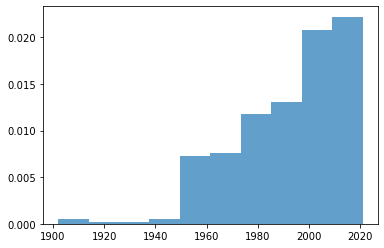

In [6]:
# by_year=movie.groupby(movie.release_date.dt.year)#['original_title'].sum()

# sns.displot(movie,x=release_date.dt.year)

plt.hist(movie.release_date.dt.year,density=1, alpha=.7)

(array([0.09721985, 0.08698618, 0.0750469 , 0.08016374, 0.09892546,
        0.09551424, 0.06993007, 0.06140201, 0.06993007, 0.17397237]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

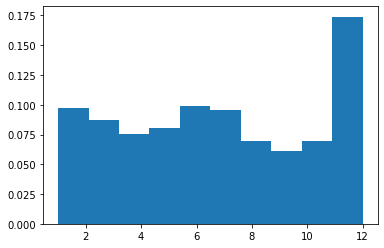

In [9]:
plt.hist(movie.release_date.dt.month,density=1)#, alpha=.7)

(array([0.05065666, 0.02814259, 0.02689181, 0.04315197, 0.03126954,
        0.02501563, 0.03627267, 0.02814259, 0.03252033, 0.03126954]),
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <a list of 10 Patch objects>)

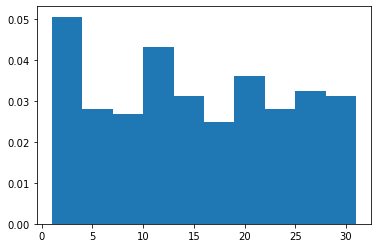

In [10]:
plt.hist(movie.release_date.dt.day,density=1)#, alpha=.7)

In [35]:
####Playing with API and Python API wrapper
#another way of pulling data with a python library
#pulled from
#https://pypi.org/project/tmdbsimple/
search = tmdb.Search()

response = search.movie(query='ufo')

UFO = search.results

for s in search.results:
    print(s['title'], s['id'], s['release_date'], s['popularity'])

print(type(UFO))

UFO 426865 2018-09-04 42.551
U.F.O. 146631 2012-12-15 11.487
The UFO Incident 86598 1975-10-20 5.593
Invasion: UFO 210198 1974-06-10 2.476
UFO Robot Grendizer vs. Great Mazinger 85311 1976-03-20 4.832
1313: UFO Invasion 95757 2012-04-03 4.178
UFO 732954 2020-09-15 1.138
UFO Syndrome 398931 1980-11-14 2.544
UFO 424222 2016-10-28 1.916
UFO: Target Earth 113824 1974-09-01 3.175
The Secret KGB UFO Files 68855 1998-01-01 3.805
UFO conspiracy: Hunt for the truth 512407 2017-01-01 3.427
UFO in Her Eyes 101958 2011-10-06 2.249
Alien Contact: The Pascagoula UFO Encounter 751702 2020-03-17 4.151
The UFO Conclusion 575350 2016-05-01 1.848
UFO Dossier - Ecuador 661817 2015-01-01 1.347
UFO Sketch 707176 2020-05-28 0.724
UFO Days 475416 2017-09-24 1.225
UFO: Showtime 226344 2005-11-08 1.214
Nazi UFO Conspiracy 74194 2012-08-04 1.331
<class 'list'>
